# MechSignal 一体化实验流水线（Notebook）
## 体外毒理（ToxCast/CTX）→ 机制表征 → 临床药物警戒（SIDER ADR + openFDA 早预警）

框架名称：**MechSignal（Mechanism-to-Signal）**

本 Notebook 将仓库中的两条研究主线整合为一个可复现的端到端流程，用于完整链路展示：

- **主线 1：SIDER ADR 多标签预测**：从公开数据构建“药物–不良反应（MedDRA PT）”多标签任务，基于结构端到端模型建立基线，并以 ToxCast/CTX 的机制输出作为特征增强。
- **主线 2：openFDA(FAERS) 季度时间切分早预警**：从 FAERS bulk 数据构建季度 drug–PT 报告计数，采用 **深度学习表征（embedding+MLP）** 进行 *t → t+1* 早预警建模，并进一步通过 **策略梯度强化学习（REINFORCE）** 直接优化排序指标（precision@K）；同时引入 ToxCast/CTX 机制特征提升可解释性。

核心连接点：**ToxCast/CTX 模型 bundle**（`data/models/toxcast_risk_target_bundle/`）提供对任意 SMILES 的：
- 风险相关回归输出（hazard / log-exposure / risk score）
- 多标签靶点概率（gene-level targets），并可选基于 invitroDB 注释构建网络扩散后的“平滑靶点”表征

主要产物：
- 处理后数据：`data/processed/`
- 训练模型与评估指标：`data/models/`


## 复现说明（建议先读）

- **GPU**：默认自动选择 `cuda`（若可用），否则回退 `cpu`。你也可以手动把 `DEVICE = "cuda"`/`"cpu"` 固定。
- **CTX API Key**：如需访问 CTX API，建议通过环境变量提供：`export CTX_API_KEY=...`（避免写入 Notebook 历史）。
- **数据体量**：默认按 openFDA 官方清单自动选择 `2004q1 → 最新季度`，并且不做文件/报告采样（全量）。如需调试，可临时把 `OPENFDA_MAX_FILES_PER_QUARTER / OPENFDA_MAX_REPORTS_PER_FILE` 设为较小整数。
- **建模窗口（建议）**：openFDA 的时间漂移较强，DL/RL 默认只用“最近若干年”的季度过渡来训练与验证（仍在最新季度做测试），以提升稳健性与降低训练成本；可在配置区通过 `OPENFDA_MODEL_*` 或环境变量覆盖。
- **默认标签与词表**：`emerging` 默认使用 `min_next_count=10`、`max_current_count=1`（更贴近“新发信号”候选）；词表默认 `top_drugs=10000`、`top_pts=5000`，可在配置区或环境变量中调整。
- **机制增强（openFDA 可选）**：openFDA 的 `DL+Mech` 默认不训练（耗时且在部分季度可能不增益）；需要时设置 `JHM_RUN_OPENFDA_DL_TOXCAST=1`。
- **缓存与落盘**：下载数据、处理中间产物与模型指标都会落盘，便于断点续跑与复现。


In [1]:
from __future__ import annotations

import json
import os
import shlex
import signal
import subprocess
import sys
from collections import deque
from pathlib import Path

import numpy as np
import pandas as pd
import torch


# --- Project root & import path ---
ROOT = Path.cwd()
if not (ROOT / "src").exists() and (ROOT / ".." / "src").exists():
    ROOT = (ROOT / "..").resolve()
os.chdir(ROOT)
sys.path.insert(0, str(ROOT / "src"))


# --- Runtime info (for reproducibility / appendix) ---
PY = sys.executable
DEVICE = "cuda"
if not torch.cuda.is_available():
    raise RuntimeError("CUDA not available. Make sure you're using the toxcast-risk kernel with a CUDA-capable PyTorch.")

# CPU 多线程：当显式切到 CPU 运行时，至少使用 12 线程
if DEVICE == "cpu":
    n_threads = max(12, int(os.cpu_count() or 12))
    os.environ["OMP_NUM_THREADS"] = str(n_threads)
    os.environ["MKL_NUM_THREADS"] = str(n_threads)
    try:
        torch.set_num_threads(n_threads)
        torch.set_num_interop_threads(min(4, n_threads))
    except Exception:
        pass
    print(f"[CPU threads] OMP/MKL={n_threads} torch_threads={n_threads}")

print("Python:", PY)
print("CWD:", Path.cwd())
print("DEVICE:", DEVICE)
print("torch:", torch.__version__, "| torch.version.cuda:", torch.version.cuda)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
try:
    import sklearn  # type: ignore

    print("scikit-learn:", sklearn.__version__)
except Exception as e:  # noqa: BLE001
    print("scikit-learn: <not available>", type(e).__name__)
try:
    from rdkit import rdBase  # type: ignore

    print("rdkit:", getattr(rdBase, "rdkitVersion", None))
except Exception as e:  # noqa: BLE001
    print("rdkit: <not available>", type(e).__name__)


def run(cmd: list[str | Path]) -> None:
    """Run a command and stream combined stdout/stderr.

    Notebook 中的长流程（下载/构建/训练）需要实时输出以便观察进度；
    同时，当命令失败时打印尾部日志用于快速定位根因。
    """

    cmd_str = [str(x) for x in cmd]
    pretty = " ".join(shlex.quote(s) for s in cmd_str)
    print()  # keep outputs visually separated
    print("$", pretty)

    env = os.environ.copy()
    if cmd_str and cmd_str[0] == sys.executable:
        env.setdefault("PYTHONUNBUFFERED", "1")

    proc = subprocess.Popen(
        cmd_str,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True,
        bufsize=1,
        env=env,
        start_new_session=(os.name != "nt"),
    )
    assert proc.stdout is not None

    tail = deque(maxlen=120)
    try:
        for line in proc.stdout:
            print(line, end="")
            tail.append(line.rstrip())
    except KeyboardInterrupt:
        print("\n[Interrupted] terminating subprocess...", flush=True)
        if proc.poll() is None:
            try:
                if os.name != "nt":
                    os.killpg(proc.pid, signal.SIGINT)
                else:
                    proc.send_signal(signal.SIGINT)
            except Exception:
                pass

            try:
                proc.wait(timeout=10)
            except subprocess.TimeoutExpired:
                try:
                    if os.name != "nt":
                        os.killpg(proc.pid, signal.SIGTERM)
                    else:
                        proc.terminate()
                except Exception:
                    pass
                try:
                    proc.wait(timeout=10)
                except subprocess.TimeoutExpired:
                    try:
                        if os.name != "nt":
                            os.killpg(proc.pid, signal.SIGKILL)
                        else:
                            proc.kill()
                    except Exception:
                        pass
                    proc.wait()

        if tail:
            print("[Last output lines]")
            for t in tail:
                print(t)
        raise
    finally:
        try:
            proc.stdout.close()
        except Exception:
            pass

    rc = proc.wait()
    if rc != 0:
        print()
        print("[Command failed] return code:", rc)
        print("[Last output lines]")
        for t in tail:
            print(t)
        raise subprocess.CalledProcessError(rc, cmd_str)


def read_json(path: Path) -> dict:
    return json.loads(path.read_text(encoding="utf-8"))

def apply_quarter_ticks(ax, quarters: list[str], *, max_labels: int = 12) -> None:
    """Set sparse x-ticks for quarter strings like 2004q1.

    Large time ranges (e.g., 2004q1–2025q3) easily produce overlapping tick labels.
    This helper prefers year boundaries (q1) and falls back to regular subsampling.
    """

    n = int(len(quarters))
    if n <= 0:
        return
    max_labels = int(max(3, max_labels))

    idx = [0]
    for i, q in enumerate(quarters):
        if i == 0 or i == n - 1:
            continue
        s = str(q).strip().lower()
        if s.endswith("q1"):
            idx.append(i)
    if (n - 1) not in idx:
        idx.append(n - 1)
    idx = sorted(set(int(i) for i in idx))
    if len(idx) > max_labels:
        step = int(np.ceil(len(idx) / max_labels))
        idx = idx[::step]
        if idx[-1] != n - 1:
            idx.append(n - 1)

    ax.set_xticks(idx)
    ax.set_xticklabels([quarters[int(i)] for i in idx], rotation=45, ha="right")
    ax.tick_params(axis="x", labelsize=8)
    ax.set_xlim(-0.5, n - 0.5)


Python: /home/xuchengjie/miniconda3/envs/toxcast-risk/bin/python
CWD: /media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/JHM
DEVICE: cuda
torch: 2.9.1 | torch.version.cuda: 12.9
numpy: 2.4.1
pandas: 2.3.3
scikit-learn: 1.8.0
rdkit: 2025.09.4


In [2]:
# =========================
# Configuration (editable)
# =========================

SEED = 42

# --- ToxCast/CTX bundle (mechanistic model outputs) ---
BUNDLE_DIR = Path("data/models/toxcast_risk_target_bundle")
FORCE_REBUILD_TOXCAST_BUNDLE = False

# --- SIDER ADR task ---
SIDER_DATA_DIR = Path("data/processed/sider")
FORCE_REBUILD_SIDER_DATASET = False
FORCE_REBUILD_SIDER_BASELINE = False
FORCE_REBUILD_SIDER_TOXCAST = False

SIDER_MIN_SUPPORT = 50
SIDER_TOP_LABELS = 300
SIDER_MAX_LABELS_PER_DRUG = 300  # None to disable
SIDER_EPOCHS = 80
SIDER_BATCH_SIZE = 64
SIDER_HIDDEN_DIM = 640
SIDER_DROPOUT = 0.25
SIDER_LR = 8e-4
SIDER_WEIGHT_DECAY = 2e-4
SIDER_MAX_ATOMS = 128
SIDER_FP_RADIUS = 3
SIDER_FP_N_BITS = 4096
SIDER_CLS_LOSS = "focal"
SIDER_FOCAL_GAMMA = 2.0
SIDER_FOCAL_ALPHA = 0.25
SIDER_TOXCAST_INIT_FROM_BASELINE = True
SIDER_TOXCAST_MC_SAMPLES = 30
SIDER_TOXCAST_WARMSTART_TOX_ZERO = False
SIDER_TOXCAST_EARLY_STOP_PATIENCE = 12
SIDER_TOXCAST_EARLY_STOP_MIN_DELTA = 0.0
SIDER_TOXCAST_EARLY_STOP_INIT_EVAL = False

# ToxCast-enhanced SIDER can use separate hyperparams
SIDER_TOXCAST_DROPOUT = 0.35
SIDER_TOXCAST_LR = 3e-4
SIDER_TOXCAST_CLS_LOSS = "focal"
SIDER_TOXCAST_FOCAL_GAMMA = 2.0
SIDER_TOXCAST_FOCAL_ALPHA = 0.25

SIDER_BASELINE_OUT = Path("data/models/sider_adr_pt")
SIDER_TOXCAST_OUT = Path("data/models/sider_adr_pt_toxcast")
SIDER_TOXCAST_OUT_DIFFUSED = Path("data/models/sider_adr_pt_toxcast_diffused")

# Mechanistic feature options
# - SIDER 默认使用 MC-dropout 平滑 toxcast 机制特征（提升泛化/稳定性）
# - openFDA 的 toxcast 特征覆盖药物词表较大，默认不做 MC 采样（避免无谓耗时）
OPENFDA_TOXCAST_MC_SAMPLES = 0
TOXCAST_INCLUDE_DIFFUSED = False

# --- openFDA early-warning task (FAERS bulk -> quarterly counts -> time-split prediction) ---
OPENFDA_RAW_DIR = Path("data/raw/openfda/drug_event")
FORCE_REBUILD_OPENFDA_COUNTS = False
FORCE_REBUILD_OPENFDA_RL = False

# openFDA counts 数据质量过滤（建议开启；会显著影响 counts，需要配合 overwrite 重建）
OPENFDA_COUNTS_NAME_STRATEGY = "prefer_substance"  # {all, prefer_substance}
OPENFDA_COUNTS_FILTER_LOW_QUALITY = True
OPENFDA_COUNTS_MAX_DRUGS_PER_REPORT = 8  # None to disable
OPENFDA_COUNTS_MAX_PTS_PER_REPORT = 50  # None to disable

# openFDA 建模阶段过滤：进一步去掉“当前季度极低曝光”的 drug / PT（0 表示不启用）
OPENFDA_MIN_DRUG_REPORTS = int(os.getenv("JHM_OPENFDA_MIN_DRUG_REPORTS", "100"))
OPENFDA_MIN_PT_REPORTS = int(os.getenv("JHM_OPENFDA_MIN_PT_REPORTS", "100"))

# RL 可复现性：显式 seed（建议与 SEED 一致）
OPENFDA_RL_SEED = int(SEED)

# 说明：openFDA 早预警主线默认采用深度学习 + 强化学习（不使用传统 LR/SGD 作为主干）。
RUN_OPENFDA_DL = os.getenv("JHM_RUN_OPENFDA_DL", "1").strip().lower() not in {"0", "false", "no"}
RUN_OPENFDA_DL_TOXCAST = os.getenv("JHM_RUN_OPENFDA_DL_TOXCAST", "0").strip().lower() not in {"0", "false", "no"}
RUN_OPENFDA_RL = os.getenv("JHM_RUN_OPENFDA_RL", "1").strip().lower() not in {"0", "false", "no"}
OPENFDA_RL_BASE_MODEL = os.getenv("JHM_OPENFDA_RL_BASE_MODEL", "toxcast").strip().lower()  # {plain,toxcast}

# Deep model hyper-parameters（GPU 可用时默认走 CUDA；算力成本不做限制）
OPENFDA_DL_EPOCHS = int(os.getenv("JHM_OPENFDA_DL_EPOCHS", "4"))
OPENFDA_DL_STEPS_PER_TRANSITION = int(os.getenv("JHM_OPENFDA_DL_STEPS_PER_TRANSITION", "20"))
OPENFDA_DL_BATCH_SIZE = int(os.getenv("JHM_OPENFDA_DL_BATCH_SIZE", "4096"))
OPENFDA_DL_POS_FRACTION = float(os.getenv("JHM_OPENFDA_DL_POS_FRACTION", "0.5"))
OPENFDA_DL_PAIR_HISTORY_LAGS = int(os.getenv("JHM_OPENFDA_DL_PAIR_HISTORY_LAGS", "4"))
OPENFDA_DL_EMB_DIM = int(os.getenv("JHM_OPENFDA_DL_EMB_DIM", "64"))
OPENFDA_DL_EMB_INTERACTIONS = os.getenv("JHM_OPENFDA_DL_EMB_INTERACTIONS", "1").strip().lower() not in {"0", "false", "no"}
OPENFDA_DL_HIDDEN_DIM = int(os.getenv("JHM_OPENFDA_DL_HIDDEN_DIM", "512"))
OPENFDA_DL_DROPOUT = float(os.getenv("JHM_OPENFDA_DL_DROPOUT", "0.2"))
OPENFDA_DL_LR = float(os.getenv("JHM_OPENFDA_DL_LR", "0.002"))
OPENFDA_DL_WEIGHT_DECAY = float(os.getenv("JHM_OPENFDA_DL_WEIGHT_DECAY", "0.0001"))
OPENFDA_DL_LR_SCHEDULE = os.getenv("JHM_OPENFDA_DL_LR_SCHEDULE", "cosine").strip().lower()  # {none,cosine,plateau}
OPENFDA_DL_LR_MIN_FACTOR = float(os.getenv("JHM_OPENFDA_DL_LR_MIN_FACTOR", "0.05"))
OPENFDA_DL_PLATEAU_FACTOR = float(os.getenv("JHM_OPENFDA_DL_PLATEAU_FACTOR", "0.5"))
OPENFDA_DL_PLATEAU_PATIENCE = int(os.getenv("JHM_OPENFDA_DL_PLATEAU_PATIENCE", "1"))
OPENFDA_DL_LOSS = os.getenv("JHM_OPENFDA_DL_LOSS", "bce+bpr").strip().lower()  # {bce,bce+bpr}
OPENFDA_DL_BPR_WEIGHT = float(os.getenv("JHM_OPENFDA_DL_BPR_WEIGHT", "1.0"))
OPENFDA_DL_BPR_MAX_PAIRS = int(os.getenv("JHM_OPENFDA_DL_BPR_MAX_PAIRS", "8192"))
OPENFDA_DL_SELECT_METRIC = os.getenv("JHM_OPENFDA_DL_SELECT_METRIC", "auprc").strip().lower()  # {auprc,p@k}
OPENFDA_DL_EARLY_STOP_PATIENCE = int(os.getenv("JHM_OPENFDA_DL_EARLY_STOP_PATIENCE", "3"))
OPENFDA_DL_EARLY_STOP_MIN_DELTA = float(os.getenv("JHM_OPENFDA_DL_EARLY_STOP_MIN_DELTA", "0.0"))
OPENFDA_DL_AMP = os.getenv("JHM_OPENFDA_DL_AMP", "1").strip().lower() not in {"0", "false", "no"}

# Evaluation knobs
OPENFDA_EVAL_TOPK = int(os.getenv("JHM_OPENFDA_EVAL_TOPK", "200"))

# RL fine-tuning hyper-parameters（控制在 2 小时内）
OPENFDA_RL_EPOCHS = int(os.getenv("JHM_OPENFDA_RL_EPOCHS", "1"))
OPENFDA_RL_TOPK = int(os.getenv("JHM_OPENFDA_RL_TOPK", str(OPENFDA_EVAL_TOPK)))
OPENFDA_RL_NEG_CANDIDATES = int(os.getenv("JHM_OPENFDA_RL_NEG_CANDIDATES", "3000"))
OPENFDA_RL_EPISODES_PER_TRANSITION = int(os.getenv("JHM_OPENFDA_RL_EPISODES_PER_TRANSITION", "1"))
OPENFDA_RL_TRAIN_LAST_N_TRANSITIONS = int(os.getenv("JHM_OPENFDA_RL_TRAIN_LAST_N_TRANSITIONS", "4"))
OPENFDA_RL_LR = float(os.getenv("JHM_OPENFDA_RL_LR", "0.00003"))
OPENFDA_RL_TEMPERATURE = float(os.getenv("JHM_OPENFDA_RL_TEMPERATURE", "1.0"))
OPENFDA_RL_ENTROPY_BETA = float(os.getenv("JHM_OPENFDA_RL_ENTROPY_BETA", "0.01"))
OPENFDA_RL_BATCH_SIZE = int(os.getenv("JHM_OPENFDA_RL_BATCH_SIZE", "8192"))
OPENFDA_RL_EARLY_STOP_PATIENCE = int(os.getenv("JHM_OPENFDA_RL_EARLY_STOP_PATIENCE", "1"))
OPENFDA_RL_EARLY_STOP_MIN_DELTA = float(os.getenv("JHM_OPENFDA_RL_EARLY_STOP_MIN_DELTA", "0.0"))

OPENFDA_RL_MAX_CANDIDATES = int(os.getenv("JHM_OPENFDA_RL_MAX_CANDIDATES", "10000"))
OPENFDA_RL_MAX_POS = os.getenv("JHM_OPENFDA_RL_MAX_POS", "").strip()
OPENFDA_RL_MAX_POS = int(OPENFDA_RL_MAX_POS) if OPENFDA_RL_MAX_POS else None
OPENFDA_RL_AMP = os.getenv("JHM_OPENFDA_RL_AMP", "1").strip().lower() not in {"0", "false", "no"}


def quarter_to_idx(q: str) -> int:
    q = q.strip().lower()
    if len(q) != 6 or q[4] != "q":
        raise ValueError(f"Invalid quarter: {q} (expected like 2004q1)")
    year = int(q[:4])
    quarter = int(q[5])
    if quarter not in (1, 2, 3, 4):
        raise ValueError(f"Invalid quarter: {q} (q must be 1-4)")
    return year * 4 + (quarter - 1)


def idx_to_quarter(i: int) -> str:
    year = i // 4
    quarter = (i % 4) + 1
    return f"{year}q{quarter}"


def quarter_range(start: str, end: str) -> list[str]:
    a = quarter_to_idx(start)
    b = quarter_to_idx(end)
    if b < a:
        raise ValueError("OPENFDA_END_QUARTER must be >= OPENFDA_START_QUARTER")
    return [idx_to_quarter(i) for i in range(a, b + 1)]


def env_int(name: str, default: int | None) -> int | None:
    v = os.getenv(name)
    if v is None or not str(v).strip():
        return default
    if str(v).strip().lower() in {"none", "null"}:
        return None
    return int(str(v).strip())

# 评估/回测若用全量 (drug, PT) union 会非常慢；默认做一个上限采样以保证 notebook 可跑通。
OPENFDA_EVAL_MAX_PAIRS = env_int("JHM_OPENFDA_EVAL_MAX_PAIRS", 50000)

# rolling backtest 默认只跑最近若干个过渡（None 表示全量）
OPENFDA_BACKTEST_LAST_N_TRANSITIONS = env_int("JHM_OPENFDA_BACKTEST_LAST_N_TRANSITIONS", 12)


# openFDA 提供了官方 download manifest（https://api.fda.gov/download.json），
# 这里用它来自动确定“可用季度集合”，并把默认季度范围设为：2004q1 → 最新季度。
try:
    from jhm_toxcast.openfda import fetch_openfda_download_manifest, list_openfda_drug_event_partitions

    _manifest = fetch_openfda_download_manifest()
    _parts = list_openfda_drug_event_partitions(_manifest)
    _available_quarters = sorted(_parts["quarter"].astype(str).unique().tolist(), key=quarter_to_idx)
except Exception as e:  # noqa: BLE001
    print("[openFDA] Failed to fetch download manifest; falling back to a static range.")
    print("Reason:", type(e).__name__, str(e))
    _available_quarters = []

_default_start = _available_quarters[0] if _available_quarters else "2004q1"
_default_end = _available_quarters[-1] if _available_quarters else "2024q4"

# 全量运行默认值（如需调试，可用环境变量覆盖；或者直接在本配置区编辑常量）
OPENFDA_START_QUARTER = os.getenv("JHM_OPENFDA_START_QUARTER", _default_start)
OPENFDA_END_QUARTER = os.getenv("JHM_OPENFDA_END_QUARTER", _default_end)

if _available_quarters:
    a = quarter_to_idx(OPENFDA_START_QUARTER)
    b = quarter_to_idx(OPENFDA_END_QUARTER)
    OPENFDA_QUARTERS = [q for q in _available_quarters if a <= quarter_to_idx(q) <= b]
else:
    OPENFDA_QUARTERS = quarter_range(OPENFDA_START_QUARTER, OPENFDA_END_QUARTER)

_OPENFDA_COUNTS_TAG = f"{OPENFDA_START_QUARTER}_{OPENFDA_END_QUARTER}"
OPENFDA_COUNTS_DIR = Path(os.getenv("JHM_OPENFDA_COUNTS_DIR", f"data/processed/openfda_counts_{_OPENFDA_COUNTS_TAG}"))

# 建模窗口（默认取最近若干年，以降低时间漂移；不影响 counts_dir 覆盖的全量季度）
OPENFDA_MODEL_END_QUARTER = os.getenv("JHM_OPENFDA_MODEL_END_QUARTER", OPENFDA_END_QUARTER).strip().lower()
OPENFDA_MODEL_RECENT_YEARS = int(os.getenv("JHM_OPENFDA_MODEL_RECENT_YEARS", "5"))
_default_model_start = OPENFDA_START_QUARTER
try:
    if quarter_to_idx(OPENFDA_MODEL_END_QUARTER) > quarter_to_idx(OPENFDA_END_QUARTER):
        OPENFDA_MODEL_END_QUARTER = OPENFDA_END_QUARTER
    _end_i = quarter_to_idx(OPENFDA_MODEL_END_QUARTER)
    _start_i = _end_i - 4 * int(OPENFDA_MODEL_RECENT_YEARS) + 1
    _cand = idx_to_quarter(_start_i)
    if quarter_to_idx(_cand) < quarter_to_idx(OPENFDA_START_QUARTER):
        _cand = OPENFDA_START_QUARTER
    _default_model_start = _cand
except Exception:
    _default_model_start = OPENFDA_START_QUARTER
OPENFDA_MODEL_START_QUARTER = os.getenv("JHM_OPENFDA_MODEL_START_QUARTER", _default_model_start).strip().lower()
if quarter_to_idx(OPENFDA_MODEL_END_QUARTER) < quarter_to_idx(OPENFDA_MODEL_START_QUARTER):
    raise ValueError("OPENFDA_MODEL_END_QUARTER must be >= OPENFDA_MODEL_START_QUARTER")
a_model = quarter_to_idx(OPENFDA_MODEL_START_QUARTER)
b_model = quarter_to_idx(OPENFDA_MODEL_END_QUARTER)
OPENFDA_MODEL_QUARTERS = [q for q in OPENFDA_QUARTERS if a_model <= quarter_to_idx(q) <= b_model]

# Optional: restrict training to the most recent N training transitions (excludes val/test)
OPENFDA_TRAIN_LAST_N_TRANSITIONS = env_int("JHM_OPENFDA_TRAIN_LAST_N_TRANSITIONS", 8)

_OPENFDA_MODEL_TAG = f"{OPENFDA_MODEL_START_QUARTER}_{OPENFDA_MODEL_END_QUARTER}"

# 默认不做任何采样：每季度全部分区文件、每个分区全部报告
OPENFDA_MAX_FILES_PER_QUARTER = env_int("JHM_OPENFDA_MAX_FILES_PER_QUARTER", None)
OPENFDA_MAX_REPORTS_PER_FILE = env_int("JHM_OPENFDA_MAX_REPORTS_PER_FILE", None)

OPENFDA_PREFER_OPENFDA_NAME = True
OPENFDA_SUSPECT_ONLY = True

# openFDA 早预警标签（建议用 emerging；默认阈值适度放宽以提升正例密度）
OPENFDA_LABEL_MODE = os.getenv("JHM_OPENFDA_LABEL_MODE", "threshold").strip().lower()  # {threshold, emerging}
OPENFDA_MIN_NEXT_COUNT = int(os.getenv("JHM_OPENFDA_MIN_NEXT_COUNT", "1"))
OPENFDA_MAX_CURRENT_COUNT = int(os.getenv("JHM_OPENFDA_MAX_CURRENT_COUNT", "5"))

_OPENFDA_LABEL_TAG = f"{OPENFDA_LABEL_MODE}_next{OPENFDA_MIN_NEXT_COUNT}"
if OPENFDA_LABEL_MODE == "emerging":
    _OPENFDA_LABEL_TAG += f"_curle{OPENFDA_MAX_CURRENT_COUNT}"

_loss_tag = str(OPENFDA_DL_LOSS).replace("+", "_")
_trainlast_tag = "" if OPENFDA_TRAIN_LAST_N_TRANSITIONS is None else f"_trainlast{int(OPENFDA_TRAIN_LAST_N_TRANSITIONS)}"
_OPENFDA_FEAT_TAG = f"hist{int(OPENFDA_DL_PAIR_HISTORY_LAGS)}_embint{int(OPENFDA_DL_EMB_INTERACTIONS)}_{_loss_tag}{_trainlast_tag}"

# 词表默认使用更紧凑的配置：提升信噪比并减轻极端稀疏。
OPENFDA_TOP_DRUGS = int(os.getenv("JHM_OPENFDA_TOP_DRUGS", "5000"))
OPENFDA_TOP_PTS = int(os.getenv("JHM_OPENFDA_TOP_PTS", "2000"))

OPENFDA_DL_OUT = Path(
    os.getenv("JHM_OPENFDA_DL_OUT", f"data/models/openfda_ew_dl_{_OPENFDA_MODEL_TAG}_{_OPENFDA_LABEL_TAG}_{_OPENFDA_FEAT_TAG}")
)
OPENFDA_DL_TOXCAST_OUT = Path(
    os.getenv(
        "JHM_OPENFDA_DL_TOXCAST_OUT",
        f"data/models/openfda_ew_dl_toxcast_{_OPENFDA_MODEL_TAG}_{_OPENFDA_LABEL_TAG}_{_OPENFDA_FEAT_TAG}",
    )
)
OPENFDA_DL_TOXCAST_OUT_DIFFUSED = Path(
    os.getenv(
        "JHM_OPENFDA_DL_TOXCAST_OUT_DIFFUSED",
        f"data/models/openfda_ew_dl_toxcast_diffused_{_OPENFDA_MODEL_TAG}_{_OPENFDA_LABEL_TAG}_{_OPENFDA_FEAT_TAG}",
    )
)

OPENFDA_RL_OUT_PLAIN = Path(
    os.getenv(
        "JHM_OPENFDA_RL_OUT_PLAIN",
        f"data/models/openfda_policy_rl_plain_{_OPENFDA_MODEL_TAG}_{_OPENFDA_LABEL_TAG}_{_OPENFDA_FEAT_TAG}",
    )
)
OPENFDA_RL_OUT_TOXCAST = Path(
    os.getenv(
        "JHM_OPENFDA_RL_OUT_TOXCAST",
        f"data/models/openfda_policy_rl_toxcast_{_OPENFDA_MODEL_TAG}_{_OPENFDA_LABEL_TAG}_{_OPENFDA_FEAT_TAG}",
    )
)

print(f"openFDA counts window: {OPENFDA_START_QUARTER} -> {OPENFDA_END_QUARTER} (n={len(OPENFDA_QUARTERS)})")
print(f"openFDA model window: {OPENFDA_MODEL_START_QUARTER} -> {OPENFDA_MODEL_END_QUARTER} (n={len(OPENFDA_MODEL_QUARTERS)})")
if OPENFDA_TRAIN_LAST_N_TRANSITIONS is not None:
    print(f"openFDA train_last_n_transitions: {int(OPENFDA_TRAIN_LAST_N_TRANSITIONS)}")

from jhm_toxcast import featurize  # noqa: E402

featurize.set_global_seed(SEED)


openFDA counts window: 2004q1 -> 2025q3 (n=87)
openFDA model window: 2020q4 -> 2025q3 (n=20)
openFDA train_last_n_transitions: 8


## A) 机制模型准备：确保 ToxCast/CTX bundle 可用

该 bundle 由 `01_toxcast_risk_target_end2end.ipynb` 生成，包含：
- 一个结构端到端的多任务网络（风险回归 + 多标签靶点预测）
- 一个指纹端到端的基线模型（用于 ensemble 与兜底预测）
- 标准化参数与元信息（genes、risk 分位点等）

为了保证跨环境复现稳定，本 Notebook 会先尝试加载 bundle；如检测到版本不兼容（例如 joblib/NumPy/Sklearn 反序列化失败），会自动重新执行 `01` 来重建 bundle。


In [3]:
need = [
    BUNDLE_DIR / "net.pt",
    BUNDLE_DIR / "metadata.json",
    BUNDLE_DIR / "baseline_reg.joblib",
    BUNDLE_DIR / "baseline_clf.joblib",
]

ok = False
if (not FORCE_REBUILD_TOXCAST_BUNDLE) and all(p.exists() for p in need):
    try:
        from jhm_toxcast.inference import load_bundle  # noqa: PLC0415

        _ = load_bundle(BUNDLE_DIR, device="cpu")
        ok = True
        print("ToxCast bundle exists and is loadable:", BUNDLE_DIR)
    except Exception as e:  # noqa: BLE001
        print("ToxCast bundle exists but is not loadable; will rebuild.")
        print("Reason:", type(e).__name__, str(e))

if not ok:
    run([PY, "scripts/run_notebook.py", "notebooks/01_toxcast_risk_target_end2end.ipynb"])
    from jhm_toxcast.inference import load_bundle  # noqa: PLC0415

    _ = load_bundle(BUNDLE_DIR, device="cpu")
    print("ToxCast bundle rebuilt and verified:", BUNDLE_DIR)


/home/xuchengjie/miniconda3/envs/toxcast-risk/lib/python3.11/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator HistGradientBoostingRegressor from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/xuchengjie/miniconda3/envs/toxcast-risk/lib/python3.11/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator _BinMapper from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/xuchengjie/miniconda3/envs/toxcast-risk/lib/python3.11/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to

ToxCast bundle exists and is loadable: data/models/toxcast_risk_target_bundle


/home/xuchengjie/miniconda3/envs/toxcast-risk/lib/python3.11/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/xuchengjie/miniconda3/envs/toxcast-risk/lib/python3.11/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/xuchengjie/miniconda3/envs/toxcast-risk/lib/python3.11/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpick

In [4]:
meta = read_json(BUNDLE_DIR / "metadata.json")
genes = list(meta.get("genes", []))
print("#genes:", len(genes))
print("risk_score_q25:", meta.get("extra", {}).get("risk_score_q25"))
print("risk_score_q75:", meta.get("extra", {}).get("risk_score_q75"))

pd.DataFrame({"gene": genes}).head(20)


#genes: 20
risk_score_q25: -1.1344282076424637
risk_score_q75: 0.7625413937457142


gene
0      ESR1
1        AR
2     NR3C1
3     PPARG
4       PGR
5      TP53
6      ESR2
7      THRA
8      THRB
9     CXCL8
10    NR3C2
11    NR1I2
12    NR1H4
13     CCL2
14  CYP2C19
15    PPARA
16      SRC
17    VCAM1
18     TSHR
19     RXRA

In [5]:
from jhm_toxcast.inference import load_bundle, predict_smiles  # noqa: PLC0415

bundle = load_bundle(BUNDLE_DIR, device=DEVICE)

# 一致性检查：确保风险与靶点预测可用
example_smiles = [
    "CC(=O)Oc1ccccc1C(=O)O",  # aspirin
    "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",  # caffeine
    "CCO",  # ethanol
]

pred = predict_smiles(bundle, example_smiles, device=DEVICE, mc_samples=20, topk=8)
pred.summary


/home/xuchengjie/miniconda3/envs/toxcast-risk/lib/python3.11/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator HistGradientBoostingRegressor from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/xuchengjie/miniconda3/envs/toxcast-risk/lib/python3.11/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator _BinMapper from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/xuchengjie/miniconda3/envs/toxcast-risk/lib/python3.11/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to

smiles status note  hazard_pred  log_exposure_pred  \
0         CC(=O)Oc1ccccc1C(=O)O     ok          0.063664          -5.799637   
1  CN1C=NC2=C1C(=O)N(C(=O)N2C)C     ok          0.037970          -5.833547   
2                           CCO     ok          0.184918          -4.373416   

   exposure_mgkgday_pred  risk_score_pred  hazard_pred_baseline  \
0               0.000002        -0.388781              0.002251   
1               0.000001        -0.450525              0.032631   
2               0.000042         1.255611              0.096073   

   log_exposure_pred_baseline  exposure_mgkgday_pred_baseline  \
0                   -5.358302                        0.000004   
1                   -5.650333                        0.000002   
2                   -4.686115                        0.000021   

   risk_score_pred_baseline  risk_score_pred_ensemble  risk_score_pred_mc_std  \
0                 -0.589677                 -0.489229                0.102345   
1                 -0.397046                 -0.423786                0.103633   
2                  0.624975                  0.940293                0.155066   

  risk_score_pred_ensemble_band  \
0                        medium   
1                        medium   
2                          high   

                                         top_targets  
0  CCL2:0.281; NR1I2:0.254; NR3C1:0.253; CXCL8:0....  
1  CCL2:0.284; NR1I2:0.265; CYP2C19:0.261; NR3C1:...  
2  ESR1:0.325; VCAM1:0.285; CCL2:0.262; CXCL8:0.2...

## B) SIDER：ADR 多标签预测（基线模型 → 机制增强模型）

### 任务定义

- 数据来源：SIDER（药物不良反应整理），标签为 MedDRA 的 **PT** 级别术语。
- 输入：药物结构（SMILES）。
- 输出：多标签 ADR 概率向量（PT 术语集合）。
- 切分：Murcko scaffold split（避免同骨架泄漏，强调结构外推能力）。

### 两个模型设置

1) **Baseline**：仅使用结构端到端模型（图编码器 + Morgan 指纹全局特征）。
2) **Mechanism-informed**：在 baseline 的全局特征中追加 **ToxCast/CTX 机制特征**（risk + 靶点概率，可选网络扩散），用于“体外→临床”桥接与可解释性增强。


In [6]:
# --- 1) 构建/加载 SIDER 数据集（自动下载 + PubChem SMILES）

if FORCE_REBUILD_SIDER_DATASET or not (SIDER_DATA_DIR / "meta.json").exists():
    run(
        [
            PY,
            "scripts/build_sider_dataset.py",
            "--out-dir",
            str(SIDER_DATA_DIR),
            "--term-type",
            "PT",
            "--overwrite",
        ]
    )

sider_meta = read_json(SIDER_DATA_DIR / "meta.json")
print(json.dumps(sider_meta, ensure_ascii=False, indent=2))

drugs = pd.read_csv(SIDER_DATA_DIR / "drugs.tsv", sep="	", dtype=str)
edges = pd.read_csv(SIDER_DATA_DIR / "drug_pt_edges.tsv", sep="	", dtype=str)
print("drugs:", drugs.shape, "| edges:", edges.shape)
print("drugs with SMILES:", int(drugs["smiles"].notna().sum()))


{
  "term_type": "PT",
  "n_drugs": 1430,
  "n_edges": 145321,
  "n_drugs_with_smiles": 1430,
  "n_unique_terms": 4251
}
drugs: (1430, 10) | edges: (145321, 2)
drugs with SMILES: 1430


#unique PT: 4251
support (PT -> #drugs) summary:
count    4251.000000
mean       34.185133
std        99.589968
min         1.000000
25%         1.000000
50%         4.000000
75%        17.000000
max      1207.000000
Name: stitch_id, dtype: float64


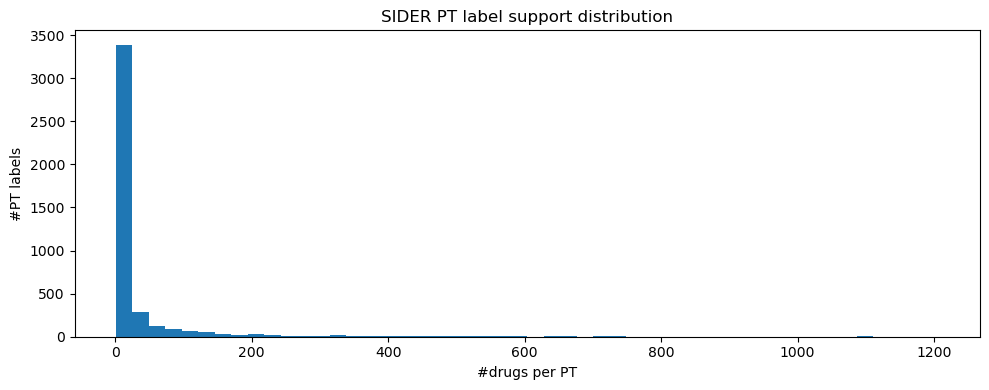

In [7]:
# --- 2) 标签分布概览：PT 支持度（每个 PT 覆盖的药物数）

import matplotlib.pyplot as plt

support = edges.groupby("pt_term")["stitch_id"].nunique().sort_values(ascending=False)
print("#unique PT:", int(support.shape[0]))
print("support (PT -> #drugs) summary:")
print(support.describe())

top_terms = support.head(20).reset_index()
top_terms.columns = ["pt_term", "n_drugs"]
top_terms

plt.figure(figsize=(10, 4))
plt.hist(support.values, bins=50)
plt.title("SIDER PT label support distribution")
plt.xlabel("#drugs per PT")
plt.ylabel("#PT labels")
plt.tight_layout()
plt.show()


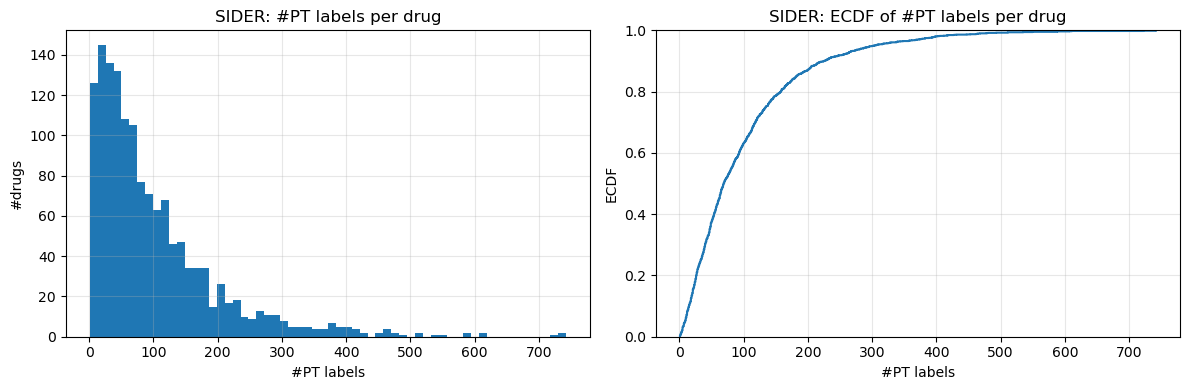

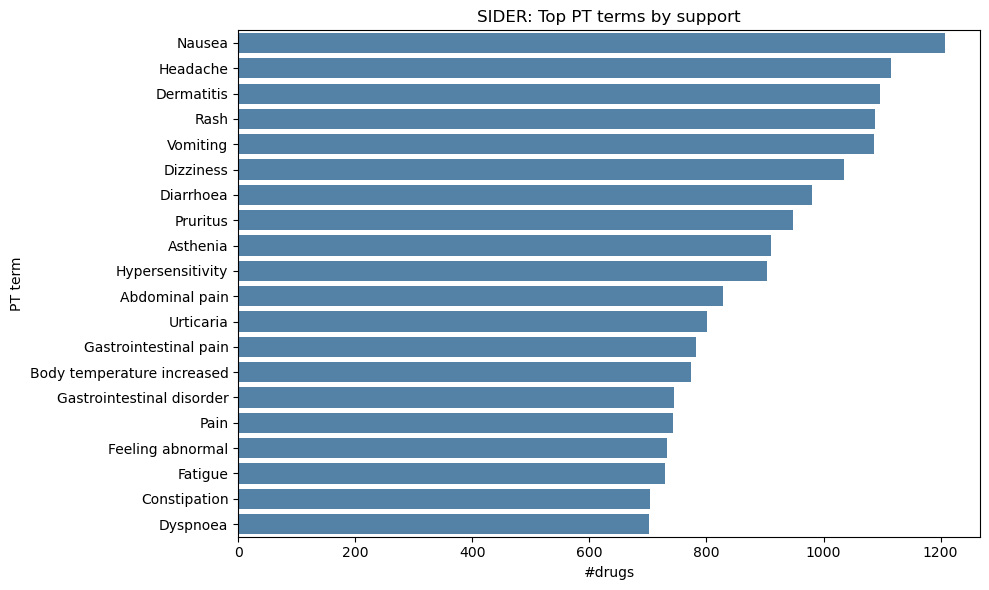

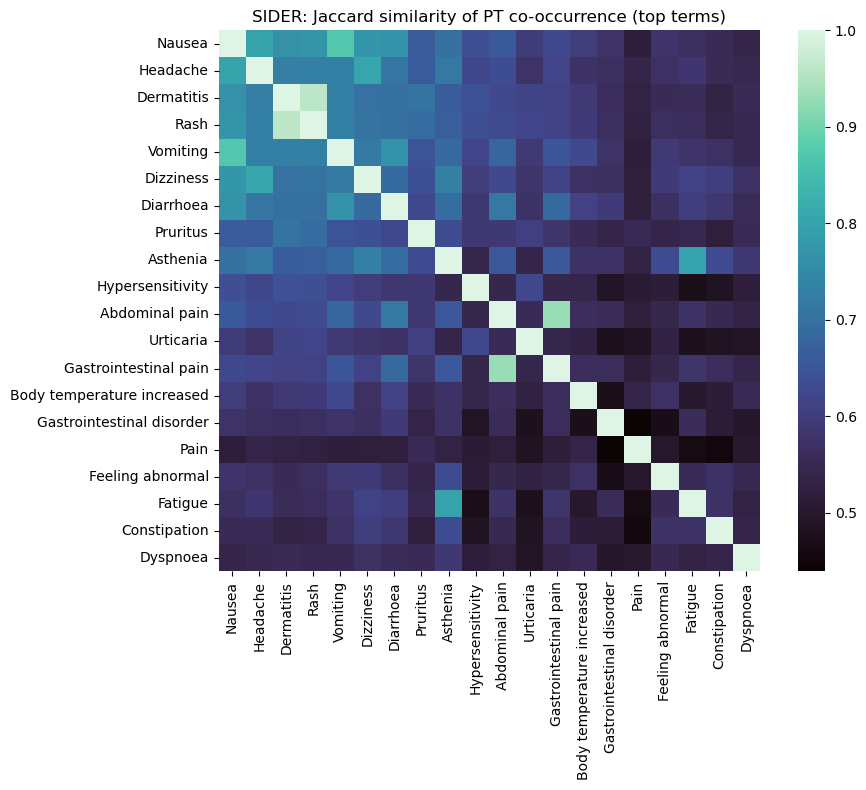

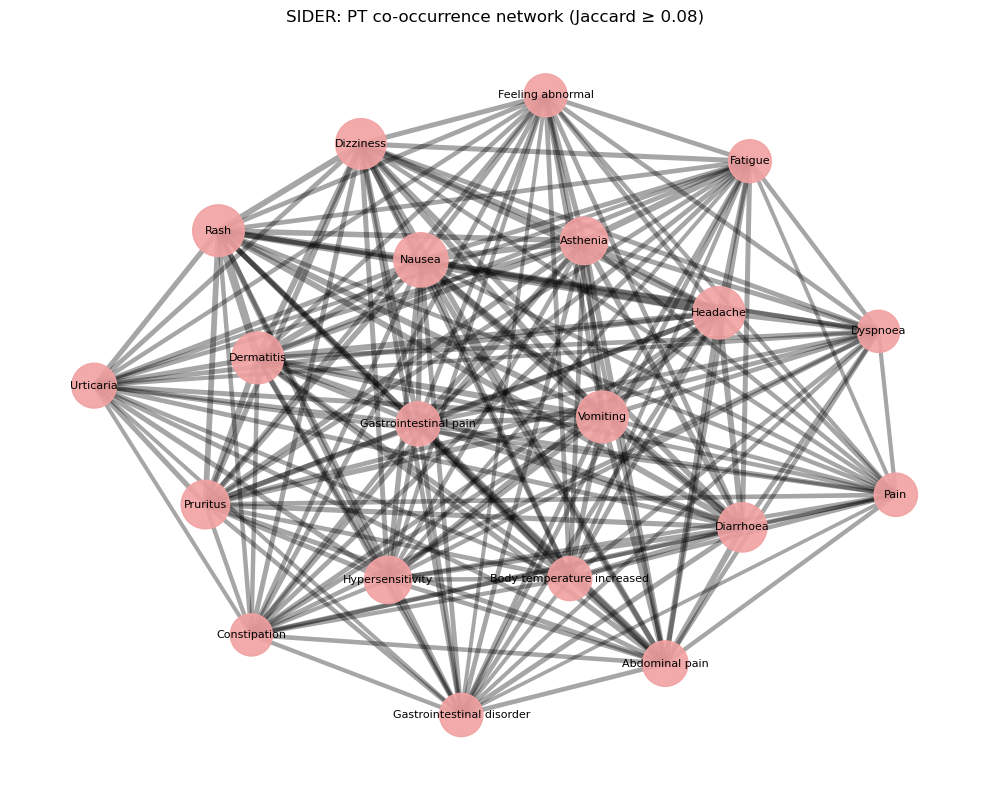

In [8]:
# --- 3) 任务难度与结构：标签密度 + 共现关系（用于结果解读与论文描述）

import seaborn as sns
import networkx as nx

# 每个药物的 PT 标签数（多标签稀疏性 / 任务难度）
labels_per_drug = edges.groupby("stitch_id")["pt_term"].nunique().astype(int)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].hist(labels_per_drug.values, bins=60)
ax[0].set_title("SIDER: #PT labels per drug")
ax[0].set_xlabel("#PT labels")
ax[0].set_ylabel("#drugs")
ax[0].grid(True, alpha=0.3)

sns.ecdfplot(labels_per_drug.values, ax=ax[1])
ax[1].set_title("SIDER: ECDF of #PT labels per drug")
ax[1].set_xlabel("#PT labels")
ax[1].set_ylabel("ECDF")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Top PT terms（支持度最高的 ADR 标签）
top_n = 20
top_terms = support.head(top_n).reset_index()
top_terms.columns = ["pt_term", "n_drugs"]

plt.figure(figsize=(10, 6))
sns.barplot(data=top_terms, x="n_drugs", y="pt_term", color="steelblue")
plt.title("SIDER: Top PT terms by support")
plt.xlabel("#drugs")
plt.ylabel("PT term")
plt.tight_layout()
plt.show()

# 标签共现：在 top terms 上构建 Jaccard 相似度（反映 ADR 模式/簇结构）
terms = top_terms["pt_term"].tolist()
sub_edges = edges[edges["pt_term"].isin(terms)].copy()

# drug-term 二值矩阵（行：drug；列：PT term）
drug_term = pd.crosstab(sub_edges["stitch_id"], sub_edges["pt_term"]).astype(np.int16)
co = drug_term.T @ drug_term  # 共现计数

jacc = pd.DataFrame(0.0, index=terms, columns=terms)
for t1 in terms:
    for t2 in terms:
        inter = float(co.loc[t1, t2])
        union = float(co.loc[t1, t1] + co.loc[t2, t2] - inter)
        jacc.loc[t1, t2] = inter / union if union > 0 else 0.0

plt.figure(figsize=(10, 8))
sns.heatmap(jacc, cmap="mako", square=True)
plt.title("SIDER: Jaccard similarity of PT co-occurrence (top terms)")
plt.tight_layout()
plt.show()

# 共现网络（阈值可调，用于论文图示）
thr = 0.08
G = nx.Graph()
for t in terms:
    G.add_node(t, support=float(co.loc[t, t]))
for i, t1 in enumerate(terms):
    for t2 in terms[i + 1 :]:
        w = float(jacc.loc[t1, t2])
        if w >= thr:
            G.add_edge(t1, t2, weight=w)

pos = nx.spring_layout(G, seed=SEED)
plt.figure(figsize=(10, 8))
node_sizes = [80 + 1.2 * G.nodes[n]["support"] for n in G.nodes]
edge_widths = [6.0 * G[u][v]["weight"] for u, v in G.edges]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="#f2a1a1", alpha=0.9)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.35)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title(f"SIDER: PT co-occurrence network (Jaccard ≥ {thr:.2f})")
plt.axis("off")
plt.tight_layout()
plt.show()


### B1) Baseline：结构端到端多标签模型

该基线用于回答：在 scaffold split 的严格评估下，仅靠结构信息可以达到怎样的 ADR 多标签性能。

实现要点（对应脚本 `scripts/train_sider_adr.py`）：
- 结构图编码器 + 注意力汇聚（输出用于解释）
- Morgan 指纹作为全局特征补充
- 多标签 BCEWithLogitsLoss（按标签支持度计算 `pos_weight`）


In [9]:
baseline_required = [
    SIDER_BASELINE_OUT / "net.pt",
    SIDER_BASELINE_OUT / "metrics.json",
    SIDER_BASELINE_OUT / "history.json",
    SIDER_BASELINE_OUT / "run_config.json",
    SIDER_BASELINE_OUT / "per_label_metrics.tsv",
    SIDER_BASELINE_OUT / "test_samples.tsv",
    SIDER_BASELINE_OUT / "test_predictions.npz",
]

import hashlib


def sha256_file(p: Path) -> str:
    h = hashlib.sha256()
    with Path(p).open("rb") as f:
        for chunk in iter(lambda: f.read(1024 * 1024), b""):
            h.update(chunk)
    return h.hexdigest()


baseline_code_hash = sha256_file(Path("scripts/train_sider_adr.py"))
dataset_fp = {
    "meta": (read_json(SIDER_DATA_DIR / "meta.json") if (SIDER_DATA_DIR / "meta.json").exists() else None),
    "drugs_sha256": sha256_file(SIDER_DATA_DIR / "drugs.tsv"),
    "edges_sha256": sha256_file(SIDER_DATA_DIR / "drug_pt_edges.tsv"),
}

baseline_ready = (not bool(FORCE_REBUILD_SIDER_BASELINE)) and all(p.exists() for p in baseline_required)
if baseline_ready:
    # 若训练配置改变（如 hidden_dim/lr/dropout 等），为保证可复现性则自动重训。
    try:
        rc = read_json(SIDER_BASELINE_OUT / "run_config.json")
        expected = {
            "min_support": int(SIDER_MIN_SUPPORT),
            "top_labels": int(SIDER_TOP_LABELS),
            "max_labels_per_drug": None if SIDER_MAX_LABELS_PER_DRUG is None else int(SIDER_MAX_LABELS_PER_DRUG),
            "max_atoms": int(SIDER_MAX_ATOMS),
            "fp_radius": int(SIDER_FP_RADIUS),
            "fp_n_bits": int(SIDER_FP_N_BITS),
            "hidden_dim": int(SIDER_HIDDEN_DIM),
            "dropout": float(SIDER_DROPOUT),
            "epochs": int(SIDER_EPOCHS),
            "batch_size": int(SIDER_BATCH_SIZE),
            "lr": float(SIDER_LR),
            "weight_decay": float(SIDER_WEIGHT_DECAY),
            "cls_loss": str(SIDER_CLS_LOSS),
            "focal_gamma": float(SIDER_FOCAL_GAMMA),
            "focal_alpha": float(SIDER_FOCAL_ALPHA),
        }
        mismatch = {k: (rc.get(k), v) for k, v in expected.items() if rc.get(k) != v}
        # Optional metadata checks (older artifacts may not have these fields)
        if rc.get("code_hash") is not None and rc.get("code_hash") != baseline_code_hash:
            mismatch["code_hash"] = (rc.get("code_hash"), baseline_code_hash)
        if rc.get("dataset_fingerprint") is not None and rc.get("dataset_fingerprint") != dataset_fp:
            mismatch["dataset_fingerprint"] = (rc.get("dataset_fingerprint"), dataset_fp)
        if rc.get("code_hash") is None or rc.get("dataset_fingerprint") is None:
            print(
                "[SIDER baseline] Warning: run_config.json missing fingerprint fields; "
                "set FORCE_REBUILD_SIDER_BASELINE=True to retrain if you suspect stale artifacts."
            )
        if mismatch:
            print("[SIDER baseline] run_config mismatch; will retrain.")
            print("mismatch:", mismatch)
            baseline_ready = False
    except Exception as e:  # noqa: BLE001
        print("[SIDER baseline] Failed to validate run_config.json; will retrain.")
        print("Reason:", type(e).__name__, str(e))
        baseline_ready = False

if not baseline_ready:
    cmd = [
        PY,
        "scripts/train_sider_adr.py",
        "--dataset-dir",
        str(SIDER_DATA_DIR),
        "--min-support",
        str(SIDER_MIN_SUPPORT),
        "--top-labels",
        str(SIDER_TOP_LABELS),
        "--hidden-dim",
        str(int(SIDER_HIDDEN_DIM)),
        "--max-atoms",
        str(int(SIDER_MAX_ATOMS)),
        "--fp-radius",
        str(int(SIDER_FP_RADIUS)),
        "--fp-n-bits",
        str(int(SIDER_FP_N_BITS)),
        "--dropout",
        str(float(SIDER_DROPOUT)),
        "--epochs",
        str(SIDER_EPOCHS),
        "--batch-size",
        str(SIDER_BATCH_SIZE),
        "--lr",
        str(float(SIDER_LR)),
        "--weight-decay",
        str(float(SIDER_WEIGHT_DECAY)),
        "--cls-loss",
        str(SIDER_CLS_LOSS),
        "--focal-gamma",
        str(float(SIDER_FOCAL_GAMMA)),
        "--focal-alpha",
        str(float(SIDER_FOCAL_ALPHA)),
        "--device",
        DEVICE,
        "--out-dir",
        str(SIDER_BASELINE_OUT),
    ]
    if SIDER_MAX_LABELS_PER_DRUG is not None:
        cmd += ["--max-labels-per-drug", str(int(SIDER_MAX_LABELS_PER_DRUG))]
    run(cmd)
else:
    print("Found baseline artifacts (skip training):", SIDER_BASELINE_OUT)


Found baseline artifacts (skip training): data/models/sider_adr_pt


{
  "micro_auroc": 0.6961183627026796,
  "micro_auprc": 0.43062119036227553,
  "n_train": 1056,
  "n_val": 132,
  "n_test": 132,
  "n_labels": 300
}


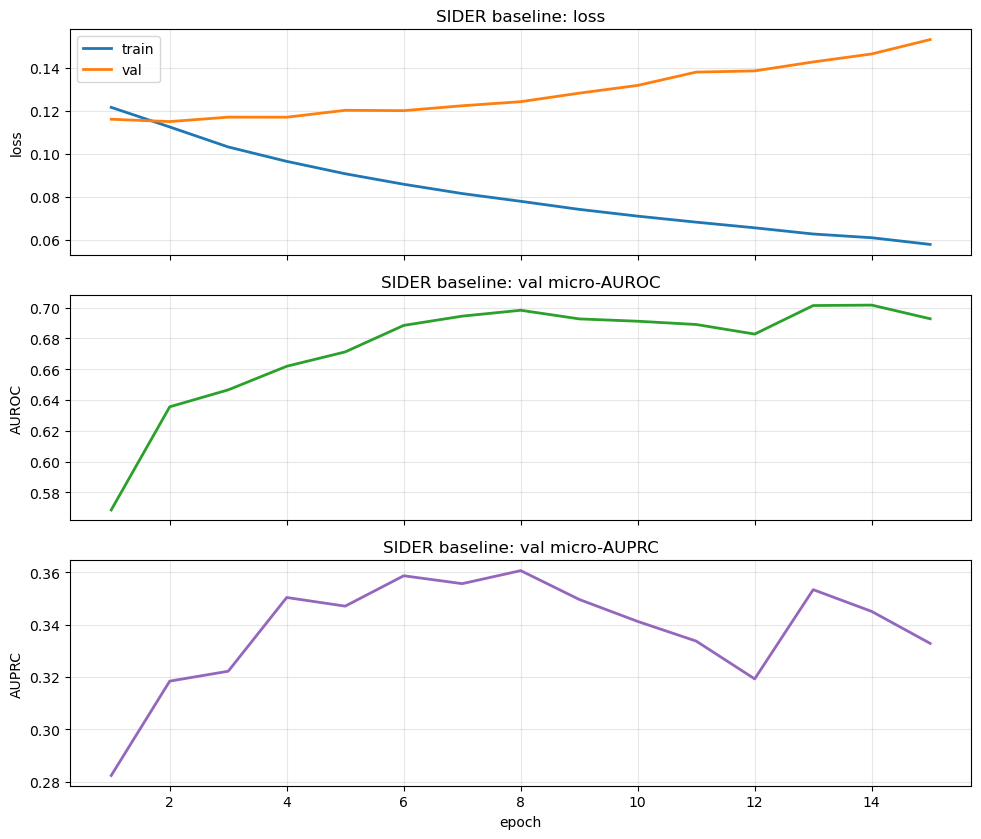

In [10]:
baseline_metrics = read_json(SIDER_BASELINE_OUT / "metrics.json")
baseline_history = read_json(SIDER_BASELINE_OUT / "history.json")

print(json.dumps(baseline_metrics, ensure_ascii=False, indent=2))

epochs = np.arange(1, len(baseline_history["train_loss"]) + 1)
val_auroc = baseline_history.get("val_micro_auroc", [])
val_auprc = baseline_history.get("val_micro_auprc", [])

fig, axes = plt.subplots(3, 1, figsize=(10, 8.5), sharex=True)

axes[0].plot(epochs, baseline_history["train_loss"], label="train", lw=2)
axes[0].plot(epochs, baseline_history["val_loss"], label="val", lw=2)
axes[0].set_title("SIDER baseline: loss")
axes[0].set_xlabel("")
axes[0].set_ylabel("loss")
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].tick_params(axis="x", labelbottom=False)

if val_auroc:
    axes[1].plot(epochs, val_auroc, color="tab:green", lw=2)
axes[1].set_title("SIDER baseline: val micro-AUROC")
axes[1].set_xlabel("")
axes[1].set_ylabel("AUROC")
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis="x", labelbottom=False)

if val_auprc:
    axes[2].plot(epochs, val_auprc, color="tab:purple", lw=2)
axes[2].set_title("SIDER baseline: val micro-AUPRC")
axes[2].set_xlabel("epoch")
axes[2].set_ylabel("AUPRC")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### B2) Mechanism-informed：追加 ToxCast/CTX 机制特征的 ADR 模型

该模型用于回答：将体外毒理/靶点层面的机制信号（risk + targets）作为特征注入后，是否能在临床 ADR 任务上获得收益，并提供机制可解释性支撑。

实现要点（对应脚本 `scripts/train_sider_adr_toxcast.py`）：
- 对每个药物 SMILES 调用 ToxCast/CTX bundle，得到风险三元组 + gene-level 靶点概率
- （可选）基于 invitroDB 的 intended target family 构建基因相似网络，对靶点概率做扩散平滑
- 将机制特征做 z-score（仅在训练集拟合），与 Morgan 指纹拼接后作为全局特征输入
- 若机制增强曲线与 baseline 几乎重合，常见原因是 warm-start + early-stop 让模型“停留在 baseline”；本 Notebook 默认关闭该退化路径。


In [11]:
tox_out = SIDER_TOXCAST_OUT_DIFFUSED if TOXCAST_INCLUDE_DIFFUSED else SIDER_TOXCAST_OUT

tox_required = [
    tox_out / "net.pt",
    tox_out / "metrics.json",
    tox_out / "history.json",
    tox_out / "run_config.json",
    tox_out / "labels.json",
    tox_out / "toxcast_features.json",
    tox_out / "per_label_metrics.tsv",
    tox_out / "test_samples.tsv",
    tox_out / "test_predictions.npz",
]

import hashlib


def sha256_file(p: Path) -> str:
    h = hashlib.sha256()
    with Path(p).open("rb") as f:
        for chunk in iter(lambda: f.read(1024 * 1024), b""):
            h.update(chunk)
    return h.hexdigest()


toxcast_code_hash = sha256_file(Path("scripts/train_sider_adr_toxcast.py"))
dataset_fp = {
    "meta": (read_json(SIDER_DATA_DIR / "meta.json") if (SIDER_DATA_DIR / "meta.json").exists() else None),
    "drugs_sha256": sha256_file(SIDER_DATA_DIR / "drugs.tsv"),
    "edges_sha256": sha256_file(SIDER_DATA_DIR / "drug_pt_edges.tsv"),
}

tox_ready = (not bool(FORCE_REBUILD_SIDER_TOXCAST)) and all(p.exists() for p in tox_required)
if tox_ready:
    # 若上游 toxcast bundle 的 gene 集合发生变化，则需要重训下游机制增强模型以保持一致。
    try:
        tox_meta = read_json(tox_out / "toxcast_features.json")
        trained_genes = list(tox_meta.get("toxcast_genes", []))
        if trained_genes and trained_genes != genes:
            print("[SIDER] ToxCast gene set mismatch; will retrain toxcast-enhanced model.")
            print("  bundle_genes :", genes)
            print("  trained_genes:", trained_genes)
            tox_ready = False
        if bool(tox_meta.get("include_diffused", False)) != bool(TOXCAST_INCLUDE_DIFFUSED):
            print("[SIDER] include_diffused mismatch; will retrain toxcast-enhanced model.")
            tox_ready = False
        if bool(tox_meta.get("init_from_baseline", False)) != bool(SIDER_TOXCAST_INIT_FROM_BASELINE):
            print("[SIDER] init_from_baseline mismatch; will retrain toxcast-enhanced model.")
            tox_ready = False
        if bool(tox_meta.get("warmstart_tox_zero", True)) != bool(SIDER_TOXCAST_WARMSTART_TOX_ZERO):
            print("[SIDER] warmstart_tox_zero mismatch; will retrain toxcast-enhanced model.")
            tox_ready = False
        if bool(tox_meta.get("early_stop_init_eval", True)) != bool(SIDER_TOXCAST_EARLY_STOP_INIT_EVAL):
            print("[SIDER] early_stop_init_eval mismatch; will retrain toxcast-enhanced model.")
            tox_ready = False
        if float(tox_meta.get("early_stop_min_delta", 0.0)) != float(SIDER_TOXCAST_EARLY_STOP_MIN_DELTA):
            print("[SIDER] early_stop_min_delta mismatch; will retrain toxcast-enhanced model.")
            tox_ready = False
        if int(tox_meta.get("mc_samples", -1)) != int(SIDER_TOXCAST_MC_SAMPLES):
            print("[SIDER] mc_samples mismatch; will retrain toxcast-enhanced model.")
            tox_ready = False
    except Exception as e:  # noqa: BLE001
        print("[SIDER] Failed to validate toxcast_features.json; will retrain.")
        print("Reason:", type(e).__name__, str(e))
        tox_ready = False
    try:
        rc = read_json(tox_out / "run_config.json")
        expected = {
            "toxcast_bundle_dir": str(BUNDLE_DIR),
            "min_support": int(SIDER_MIN_SUPPORT),
            "top_labels": int(SIDER_TOP_LABELS),
            "max_labels_per_drug": None if SIDER_MAX_LABELS_PER_DRUG is None else int(SIDER_MAX_LABELS_PER_DRUG),
            "seed": int(SEED),
            "max_atoms": int(SIDER_MAX_ATOMS),
            "fp_radius": int(SIDER_FP_RADIUS),
            "fp_n_bits": int(SIDER_FP_N_BITS),
            "hidden_dim": int(SIDER_HIDDEN_DIM),
            "dropout": float(SIDER_TOXCAST_DROPOUT),
            "epochs": int(SIDER_EPOCHS),
            "batch_size": int(SIDER_BATCH_SIZE),
            "lr": float(SIDER_TOXCAST_LR),
            "weight_decay": float(SIDER_WEIGHT_DECAY),
            "cls_loss": str(SIDER_TOXCAST_CLS_LOSS),
            "focal_gamma": float(SIDER_TOXCAST_FOCAL_GAMMA),
            "focal_alpha": float(SIDER_TOXCAST_FOCAL_ALPHA),
            "include_diffused": bool(TOXCAST_INCLUDE_DIFFUSED),
            "mc_samples": int(SIDER_TOXCAST_MC_SAMPLES),
            "warmstart_tox_zero": bool(SIDER_TOXCAST_WARMSTART_TOX_ZERO),
            "early_stop_patience": int(SIDER_TOXCAST_EARLY_STOP_PATIENCE),
            "early_stop_min_delta": float(SIDER_TOXCAST_EARLY_STOP_MIN_DELTA),
            "early_stop_init_eval": bool(SIDER_TOXCAST_EARLY_STOP_INIT_EVAL),
        }
        mismatch = {k: (rc.get(k), v) for k, v in expected.items() if rc.get(k) != v}
        # Optional metadata checks (older artifacts may not have these fields)
        if rc.get("code_hash") is not None and rc.get("code_hash") != toxcast_code_hash:
            mismatch["code_hash"] = (rc.get("code_hash"), toxcast_code_hash)
        if rc.get("dataset_fingerprint") is not None and rc.get("dataset_fingerprint") != dataset_fp:
            mismatch["dataset_fingerprint"] = (rc.get("dataset_fingerprint"), dataset_fp)
        if rc.get("code_hash") is None or rc.get("dataset_fingerprint") is None:
            print(
                "[SIDER toxcast] Warning: run_config.json missing fingerprint fields; "
                "set FORCE_REBUILD_SIDER_TOXCAST=True to retrain if you suspect stale artifacts."
            )
        # init_from_baseline 在 run_config.json 中是路径/None；此处只比较布尔含义
        if bool(rc.get("init_from_baseline")) != bool(SIDER_TOXCAST_INIT_FROM_BASELINE):
            mismatch["init_from_baseline"] = (bool(rc.get("init_from_baseline")), bool(SIDER_TOXCAST_INIT_FROM_BASELINE))
        if mismatch:
            print("[SIDER] run_config mismatch; will retrain toxcast-enhanced model.")
            print("mismatch:", mismatch)
            tox_ready = False
    except Exception as e:  # noqa: BLE001
        print("[SIDER] Failed to validate run_config.json; will retrain.")
        print("Reason:", type(e).__name__, str(e))
        tox_ready = False

# 额外健壮性检查：若机制增强模型输出与 baseline 几乎完全一致，说明 tox 特征被“完全忽略”或被回滚。
# 为避免出现退化对比图，这里会触发重训（使用更积极的初始化/早停设置）。
if tox_ready:
    try:
        b_pred = np.load(SIDER_BASELINE_OUT / "test_predictions.npz")["y_prob"].astype(np.float32)
        t_pred = np.load(tox_out / "test_predictions.npz")["y_prob"].astype(np.float32)
        max_abs = float(np.max(np.abs(b_pred - t_pred)))
        if max_abs < 1e-4:
            print(f"[SIDER] Degenerate comparison detected (max|Δprob|={max_abs:.2e}); will retrain toxcast-enhanced model.")
            tox_ready = False
    except Exception:
        pass
if not tox_ready:
    cmd = [
        PY,
        "scripts/train_sider_adr_toxcast.py",
        "--dataset-dir",
        str(SIDER_DATA_DIR),
        "--toxcast-bundle-dir",
        str(BUNDLE_DIR),
        "--toxcast-device",
        DEVICE,
        "--mc-samples",
        str(int(SIDER_TOXCAST_MC_SAMPLES)),
        "--min-support",
        str(SIDER_MIN_SUPPORT),
        "--top-labels",
        str(SIDER_TOP_LABELS),
        "--seed",
        str(int(SEED)),
        "--max-atoms",
        str(int(SIDER_MAX_ATOMS)),
        "--fp-radius",
        str(int(SIDER_FP_RADIUS)),
        "--fp-n-bits",
        str(int(SIDER_FP_N_BITS)),
        "--hidden-dim",
        str(int(SIDER_HIDDEN_DIM)),
        "--dropout",
        str(float(SIDER_TOXCAST_DROPOUT)),
        "--epochs",
        str(SIDER_EPOCHS),
        "--batch-size",
        str(SIDER_BATCH_SIZE),
        "--lr",
        str(float(SIDER_TOXCAST_LR)),
        "--weight-decay",
        str(float(SIDER_WEIGHT_DECAY)),
        "--cls-loss",
        str(SIDER_TOXCAST_CLS_LOSS),
        "--focal-gamma",
        str(float(SIDER_TOXCAST_FOCAL_GAMMA)),
        "--focal-alpha",
        str(float(SIDER_TOXCAST_FOCAL_ALPHA)),
        "--early-stop-patience",
        str(int(SIDER_TOXCAST_EARLY_STOP_PATIENCE)),
        "--early-stop-min-delta",
        str(float(SIDER_TOXCAST_EARLY_STOP_MIN_DELTA)),
        "--device",
        DEVICE,
        "--out-dir",
        str(tox_out),
    ]
    if bool(SIDER_TOXCAST_INIT_FROM_BASELINE):
        cmd += ["--init-from-baseline", str(SIDER_BASELINE_OUT / "net.pt")]
    if SIDER_MAX_LABELS_PER_DRUG is not None:
        cmd += ["--max-labels-per-drug", str(int(SIDER_MAX_LABELS_PER_DRUG))]
    if not bool(SIDER_TOXCAST_WARMSTART_TOX_ZERO):
        cmd.append("--no-warmstart-tox-zero")
    if not bool(SIDER_TOXCAST_EARLY_STOP_INIT_EVAL):
        cmd.append("--no-early-stop-init-eval")
    if TOXCAST_INCLUDE_DIFFUSED:
        cmd.append("--include-diffused")
    run(cmd)
else:
    print("Found toxcast-enhanced artifacts (skip training):", tox_out)


Found toxcast-enhanced artifacts (skip training): data/models/sider_adr_pt_toxcast


{
  "micro_auroc": 0.6975335144619579,
  "micro_auprc": 0.4388561711052223,
  "n_train": 1056,
  "n_val": 132,
  "n_test": 132,
  "n_labels": 300
}


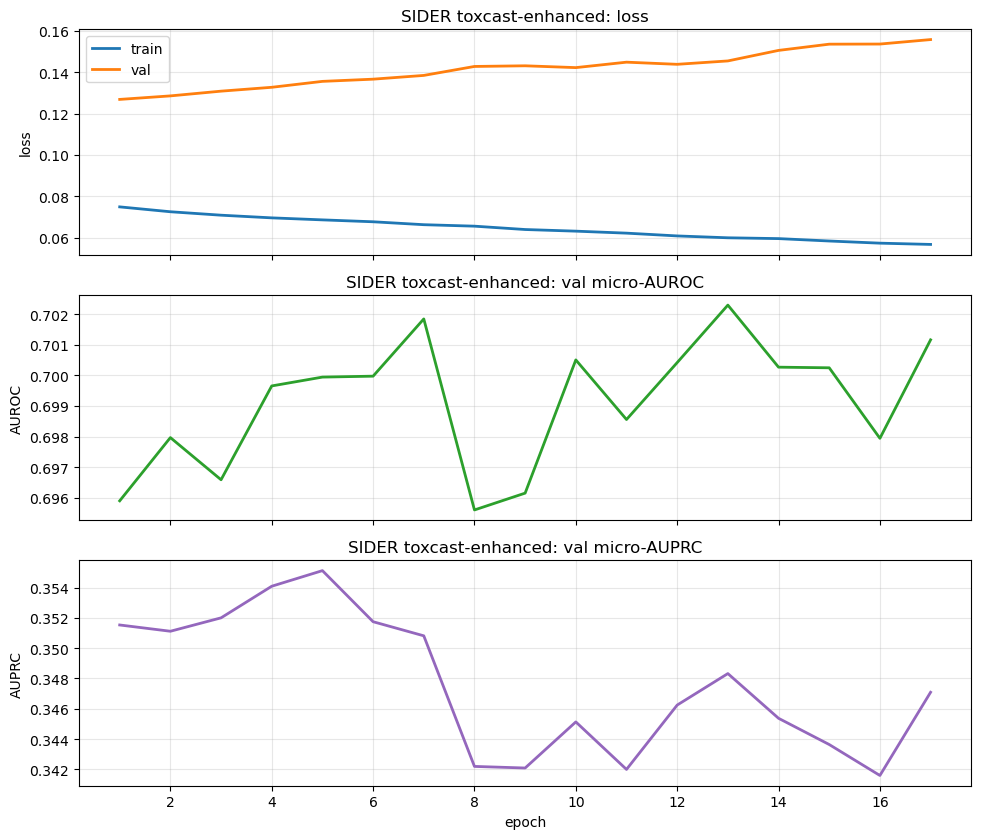

In [12]:
tox_metrics = read_json(tox_out / "metrics.json")
print(json.dumps(tox_metrics, ensure_ascii=False, indent=2))

comparison = pd.DataFrame(
    [
        {
            "model": "baseline",
            "micro_auroc": float(baseline_metrics.get("micro_auroc", np.nan)),
            "micro_auprc": float(baseline_metrics.get("micro_auprc", np.nan)),
        },
        {
            "model": "mechanism_informed" + ("_diffused" if TOXCAST_INCLUDE_DIFFUSED else ""),
            "micro_auroc": float(tox_metrics.get("micro_auroc", np.nan)),
            "micro_auprc": float(tox_metrics.get("micro_auprc", np.nan)),
        },
    ]
)
comparison

# Training curves
tox_history = read_json(tox_out / "history.json")

epochs = np.arange(1, len(tox_history["train_loss"]) + 1)
val_auroc = tox_history.get("val_micro_auroc", [])
val_auprc = tox_history.get("val_micro_auprc", [])

fig, axes = plt.subplots(3, 1, figsize=(10, 8.5), sharex=True)

axes[0].plot(epochs, tox_history["train_loss"], label="train", lw=2)
axes[0].plot(epochs, tox_history["val_loss"], label="val", lw=2)
axes[0].set_title("SIDER toxcast-enhanced: loss")
axes[0].set_xlabel("")
axes[0].set_ylabel("loss")
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].tick_params(axis="x", labelbottom=False)

if val_auroc:
    axes[1].plot(epochs, val_auroc, color="tab:green", lw=2)
axes[1].set_title("SIDER toxcast-enhanced: val micro-AUROC")
axes[1].set_xlabel("")
axes[1].set_ylabel("AUROC")
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis="x", labelbottom=False)

if val_auprc:
    axes[2].plot(epochs, val_auprc, color="tab:purple", lw=2)
axes[2].set_title("SIDER toxcast-enhanced: val micro-AUPRC")
axes[2].set_xlabel("epoch")
axes[2].set_ylabel("AUPRC")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [13]:
# 机制特征说明（用于方法与补充材料）

tox_feat_path = tox_out / "toxcast_features.json"
if tox_feat_path.exists():
    tox_feat_meta = read_json(tox_feat_path)
    print("include_diffused:", tox_feat_meta.get("include_diffused"))
    print("#tox_genes:", len(tox_feat_meta.get("toxcast_genes", [])))
    print("#tox_features:", len(tox_feat_meta.get("feature_names", [])))
    pd.DataFrame({"feature": tox_feat_meta.get("feature_names", [])}).head(30)
else:
    print("Missing:", tox_feat_path)


include_diffused: False
#tox_genes: 20
#tox_features: 23


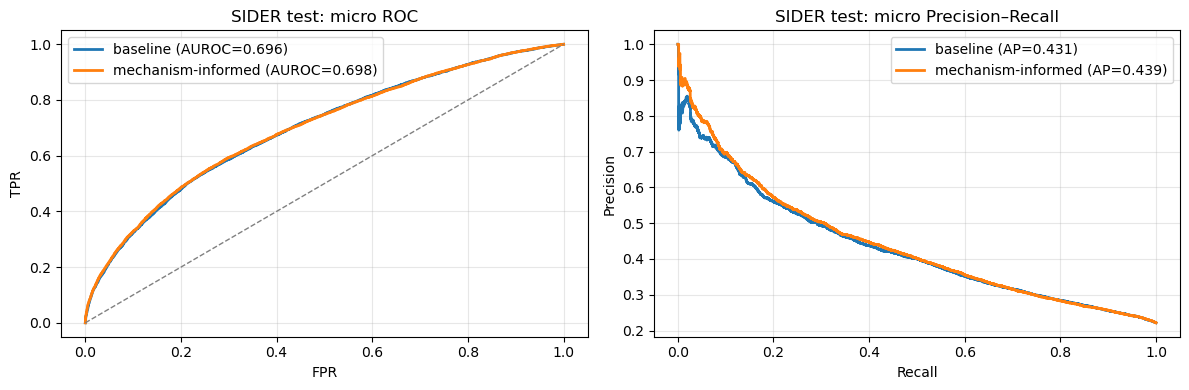

Per-label deltas: max|ΔAUROC|=0.0854  max|ΔAUPRC|=0.1147


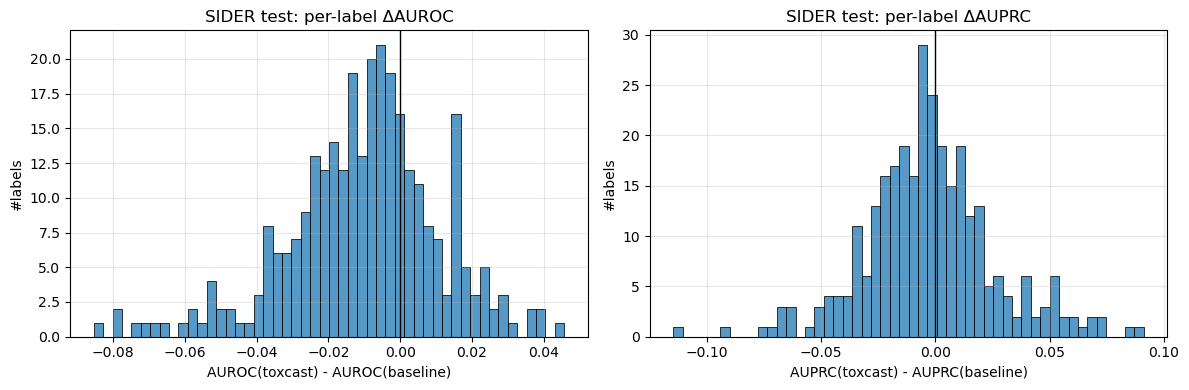

pt_term  support_test_baseline  auprc_baseline  \
284                    Aggression                      6        0.483670   
288                 Extravasation                     12        0.293676   
108         Myocardial infarction                     30        0.355491   
71                    Nervousness                     43        0.557522   
204             Vaginal infection                     14        0.139819   
223          Vaginal inflammation                     13        0.133067   
72                        Tension                     43        0.567121   
158      Cerebrovascular accident                     21        0.382046   
260                Hyperuricaemia                      9        0.136107   
297          Myocardial ischaemia                     12        0.141278   
261                       Melaena                     14        0.157178   
221             Mental disability                     15        0.375586   
184       Injection site reaction                     17        0.364760   
227       Salivary hypersecretion                     14        0.193683   
168               Cardiac failure                     15        0.357217   
104                    Haematuria                     24        0.233516   
127                   Pollakiuria                     29        0.352665   
147                      Lethargy                     22        0.334307   
246           Respiratory failure                      9        0.132102   
251  Tubulointerstitial nephritis                     10        0.186464   

     auprc_toxcast  delta_auprc  
284       0.574875     0.091205  
288       0.378963     0.085287  
108       0.428433     0.072942  
71        0.628877     0.071355  
204       0.206961     0.067142  
223       0.199740     0.066673  
72        0.630437     0.063316  
158       0.444150     0.062104  
260       0.197297     0.061190  
297       0.198662     0.057385  
261       0.214331     0.057153  
221       0.429322     0.053736  
184       0.417698     0.052938  
227       0.245648     0.051965  
168       0.409101     0.051884  
104       0.284161     0.050645  
127       0.403154     0.050489  
147       0.383797     0.049490  
246       0.179597     0.047495  
251       0.233158     0.046695

In [14]:
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)


def micro_roc_pr(y_true: np.ndarray, y_prob: np.ndarray):
    y = y_true.ravel().astype(int)
    p = y_prob.ravel().astype(float)

    fpr, tpr, _ = roc_curve(y, p)
    auroc = float(roc_auc_score(y, p)) if len(np.unique(y)) > 1 else float("nan")

    precision, recall, _ = precision_recall_curve(y, p)
    ap = float(average_precision_score(y, p)) if len(np.unique(y)) > 1 else float("nan")

    return (fpr, tpr, auroc), (recall, precision, ap)


b_npz = np.load(SIDER_BASELINE_OUT / "test_predictions.npz")
t_npz = np.load(tox_out / "test_predictions.npz")

b_roc, b_pr = micro_roc_pr(b_npz["y_true"], b_npz["y_prob"])
t_roc, t_pr = micro_roc_pr(t_npz["y_true"], t_npz["y_prob"])

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(b_roc[0], b_roc[1], lw=2, label=f"baseline (AUROC={b_roc[2]:.3f})")
ax[0].plot(t_roc[0], t_roc[1], lw=2, label=f"mechanism-informed (AUROC={t_roc[2]:.3f})")
ax[0].plot([0, 1], [0, 1], ls="--", lw=1, color="gray")
ax[0].set_title("SIDER test: micro ROC")
ax[0].set_xlabel("FPR")
ax[0].set_ylabel("TPR")
ax[0].grid(True, alpha=0.3)
ax[0].legend()

ax[1].plot(b_pr[0], b_pr[1], lw=2, label=f"baseline (AP={b_pr[2]:.3f})")
ax[1].plot(t_pr[0], t_pr[1], lw=2, label=f"mechanism-informed (AP={t_pr[2]:.3f})")
ax[1].set_title("SIDER test: micro Precision–Recall")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].grid(True, alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.show()

# per-label improvements
b_pl = pd.read_csv(SIDER_BASELINE_OUT / "per_label_metrics.tsv", sep="	")
t_pl = pd.read_csv(tox_out / "per_label_metrics.tsv", sep="	")
m = b_pl.merge(t_pl, on="pt_term", suffixes=("_baseline", "_toxcast"))

m["delta_auroc"] = m["auroc_toxcast"] - m["auroc_baseline"]
m["delta_auprc"] = m["auprc_toxcast"] - m["auprc_baseline"]

max_abs_d_auroc = float(m["delta_auroc"].abs().max())
max_abs_d_auprc = float(m["delta_auprc"].abs().max())
print(f"Per-label deltas: max|ΔAUROC|={max_abs_d_auroc:.4f}  max|ΔAUPRC|={max_abs_d_auprc:.4f}")
if max_abs_d_auroc < 1e-6 and max_abs_d_auprc < 1e-6:
    print("[SIDER] Warning: toxcast-enhanced metrics are numerically identical to baseline; verify the training step.")

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(m["delta_auroc"].dropna(), bins=50, ax=ax[0])
ax[0].axvline(0, color="black", lw=1)
ax[0].set_title("SIDER test: per-label ΔAUROC")
ax[0].set_xlabel("AUROC(toxcast) - AUROC(baseline)")
ax[0].set_ylabel("#labels")
ax[0].grid(True, alpha=0.3)

sns.histplot(m["delta_auprc"].dropna(), bins=50, ax=ax[1])
ax[1].axvline(0, color="black", lw=1)
ax[1].set_title("SIDER test: per-label ΔAUPRC")
ax[1].set_xlabel("AUPRC(toxcast) - AUPRC(baseline)")
ax[1].set_ylabel("#labels")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 展示提升最大的若干 ADR 标签（便于论文/报告摘录）
show_cols = [
    "pt_term",
    "support_test_baseline",
    "auprc_baseline",
    "auprc_toxcast",
    "delta_auprc",
]

m.sort_values("delta_auprc", ascending=False).head(20)[show_cols]


### B3) 专家式解读：为什么 micro 下降？哪些 PT 反而提升？

- 机制特征可能只对**少数 ADR 标签**显著有帮助，但 micro 指标会被高频标签主导；
- 因此需要同时报告：**(1) micro 指标的不确定性（bootstrap CI）** 与 **(2) per-label 的提升/下降列表**；
- 后续如果要做机制驱动实验验证，优先从 **ΔAUPRC 提升显著且支持度足够的 PT** 入手。


In [15]:
# --- B3) Bootstrap CI for micro metrics + export per-label gain/loss lists

import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from sklearn.metrics import average_precision_score, roc_auc_score

# Ensure inputs exist
tox_out = SIDER_TOXCAST_OUT_DIFFUSED if TOXCAST_INCLUDE_DIFFUSED else SIDER_TOXCAST_OUT
b_npz = np.load(SIDER_BASELINE_OUT / 'test_predictions.npz')
t_npz = np.load(tox_out / 'test_predictions.npz')

y_b = b_npz['y_true'].astype(np.int8)
p_b = b_npz['y_prob'].astype(np.float32)
y_t = t_npz['y_true'].astype(np.int8)
p_t = t_npz['y_prob'].astype(np.float32)

def micro_metrics(y_true: np.ndarray, y_prob: np.ndarray) -> tuple[float, float]:
    y = y_true.reshape(-1).astype(int)
    p = y_prob.reshape(-1).astype(float)
    auroc = float(roc_auc_score(y, p)) if np.unique(y).size > 1 else float('nan')
    auprc = float(average_precision_score(y, p)) if np.unique(y).size > 1 else float('nan')
    return auroc, auprc

def bootstrap_ci(y_true: np.ndarray, y_prob: np.ndarray, *, n_boot: int = 1000, seed: int = 42):
    rng = np.random.default_rng(int(seed))
    n = int(y_true.shape[0])
    auroc = np.empty((n_boot,), dtype=np.float32)
    auprc = np.empty((n_boot,), dtype=np.float32)
    for i in range(int(n_boot)):
        idx = rng.integers(0, n, size=n, endpoint=False)
        a, b = micro_metrics(y_true[idx], y_prob[idx])
        auroc[i] = a
        auprc[i] = b
    def _ci(x: np.ndarray):
        x = x[np.isfinite(x)]
        return float(np.nanmean(x)), float(np.nanpercentile(x, 2.5)), float(np.nanpercentile(x, 97.5))
    return {'auroc': _ci(auroc), 'auprc': _ci(auprc)}

base = micro_metrics(y_b, p_b)
mech = micro_metrics(y_t, p_t)
ci_b = bootstrap_ci(y_b, p_b, n_boot=800, seed=int(SEED))
ci_t = bootstrap_ci(y_t, p_t, n_boot=800, seed=int(SEED) + 1)

summary = pd.DataFrame(
    [
        {'model': 'baseline', 'metric': 'micro_auroc', 'mean': base[0], 'ci_low': ci_b['auroc'][1], 'ci_high': ci_b['auroc'][2]},
        {'model': 'baseline', 'metric': 'micro_auprc', 'mean': base[1], 'ci_low': ci_b['auprc'][1], 'ci_high': ci_b['auprc'][2]},
        {'model': 'mech', 'metric': 'micro_auroc', 'mean': mech[0], 'ci_low': ci_t['auroc'][1], 'ci_high': ci_t['auroc'][2]},
        {'model': 'mech', 'metric': 'micro_auprc', 'mean': mech[1], 'ci_low': ci_t['auprc'][1], 'ci_high': ci_t['auprc'][2]},
        {'model': 'mech-baseline', 'metric': 'micro_auroc', 'mean': mech[0] - base[0], 'ci_low': float('nan'), 'ci_high': float('nan')},
        {'model': 'mech-baseline', 'metric': 'micro_auprc', 'mean': mech[1] - base[1], 'ci_low': float('nan'), 'ci_high': float('nan')},
    ]
)
display(Markdown('**Bootstrap 置信区间（drug-level 重采样）**：micro 指标差异是否显著？'))
display(summary)

# Per-label gain/loss export
b_pl = pd.read_csv(SIDER_BASELINE_OUT / 'per_label_metrics.tsv', sep='	')
t_pl = pd.read_csv(tox_out / 'per_label_metrics.tsv', sep='	')
m = b_pl.merge(t_pl, on='pt_term', suffixes=('_baseline', '_mech'))
m['delta_auroc'] = m['auroc_mech'] - m['auroc_baseline']
m['delta_auprc'] = m['auprc_mech'] - m['auprc_baseline']

out_dir = Path('data/outputs')
out_dir.mkdir(parents=True, exist_ok=True)
all_path = out_dir / 'sider_per_label_deltas.tsv'
m.to_csv(all_path, sep='	', index=False)

top_gain = m.sort_values('delta_auprc', ascending=False).head(30)
top_loss = m.sort_values('delta_auprc', ascending=True).head(30)
gain_path = out_dir / 'sider_top_gain_by_auprc.tsv'
loss_path = out_dir / 'sider_top_loss_by_auprc.tsv'
top_gain.to_csv(gain_path, sep='	', index=False)
top_loss.to_csv(loss_path, sep='	', index=False)

display(Markdown(f'已导出 per-label 对比表：`{all_path}`'))
display(Markdown(f'Top gain: `{gain_path}`  |  Top loss: `{loss_path}`'))

# Build a mechanism-helpful PT subset for targeted evaluation
min_support = 10
min_delta = 0.02
helpful = m[(m['support_test_baseline'] >= min_support) & (m['delta_auprc'] >= min_delta)].copy()
helpful = helpful.sort_values('delta_auprc', ascending=False).reset_index(drop=True)
helpful_path = out_dir / f'sider_mech_helpful_pts_support{min_support}_dauprc{min_delta}.tsv'
helpful.to_csv(helpful_path, sep='	', index=False)
display(Markdown(f'机制提升显著的 PT 子集（用于后续验证/写作）：`{helpful_path}`  (n={helpful.shape[0]})'))

# Micro metrics restricted to the helpful PT subset (often shows clearer gains)
labels = read_json(SIDER_BASELINE_OUT / 'labels.json').get('labels') or []
label_to_idx = {str(x): int(i) for i, x in enumerate(labels)}
sel = [label_to_idx.get(str(pt)) for pt in helpful['pt_term'].astype(str).tolist() if str(pt) in label_to_idx]
sel = [int(i) for i in sel if i is not None]
if sel:
    yb_s = y_b[:, sel]
    pb_s = p_b[:, sel]
    yt_s = y_t[:, sel]
    pt_s = p_t[:, sel]
    base_s = micro_metrics(yb_s, pb_s)
    mech_s = micro_metrics(yt_s, pt_s)
    display(Markdown('**仅在“机制明显提升”的 PT 子集上计算 micro 指标**：'))
    display(pd.DataFrame([
        {'subset': f'helpful_pts(n={len(sel)})', 'model': 'baseline', 'micro_auroc': base_s[0], 'micro_auprc': base_s[1]},
        {'subset': f'helpful_pts(n={len(sel)})', 'model': 'mech', 'micro_auroc': mech_s[0], 'micro_auprc': mech_s[1]},
        {'subset': f'helpful_pts(n={len(sel)})', 'model': 'mech-baseline', 'micro_auroc': mech_s[0]-base_s[0], 'micro_auprc': mech_s[1]-base_s[1]},
    ]))
else:
    print('No PT selected for subset micro-metrics (helpful list empty or label mismatch).')


**Bootstrap 置信区间（drug-level 重采样）**：micro 指标差异是否显著？

model       metric      mean    ci_low   ci_high
0       baseline  micro_auroc  0.696118  0.667489  0.727592
1       baseline  micro_auprc  0.430621  0.379761  0.480636
2           mech  micro_auroc  0.697534  0.665671  0.730567
3           mech  micro_auprc  0.438856  0.385797  0.490118
4  mech-baseline  micro_auroc  0.001415       NaN       NaN
5  mech-baseline  micro_auprc  0.008235       NaN       NaN

已导出 per-label 对比表：`data/outputs/sider_per_label_deltas.tsv`

Top gain: `data/outputs/sider_top_gain_by_auprc.tsv`  |  Top loss: `data/outputs/sider_top_loss_by_auprc.tsv`

机制提升显著的 PT 子集（用于后续验证/写作）：`data/outputs/sider_mech_helpful_pts_support10_dauprc0.02.tsv`  (n=41)

**仅在“机制明显提升”的 PT 子集上计算 micro 指标**：

subset          model  micro_auroc  micro_auprc
0  helpful_pts(n=41)       baseline     0.677798     0.359100
1  helpful_pts(n=41)           mech     0.686945     0.400451
2  helpful_pts(n=41)  mech-baseline     0.009147     0.041352

/home/xuchengjie/miniconda3/envs/toxcast-risk/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_779249/463435500.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Reds")


IG target label: Aggression (index=299)
Example drug: 
SMILES: COC(=O)C(C1CCCCN1)C2=CC=CC=C2
Top predicted ADR labels:
  Dizziness: 0.791
  Asthenia: 0.745
  Nausea: 0.738
  Headache: 0.733
  Somnolence: 0.708


IG label: Aggression | y_true=1 | y_pred=0.538


/tmp/ipykernel_779249/463435500.py:209: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=show, x="attr", y="feature", palette="coolwarm")


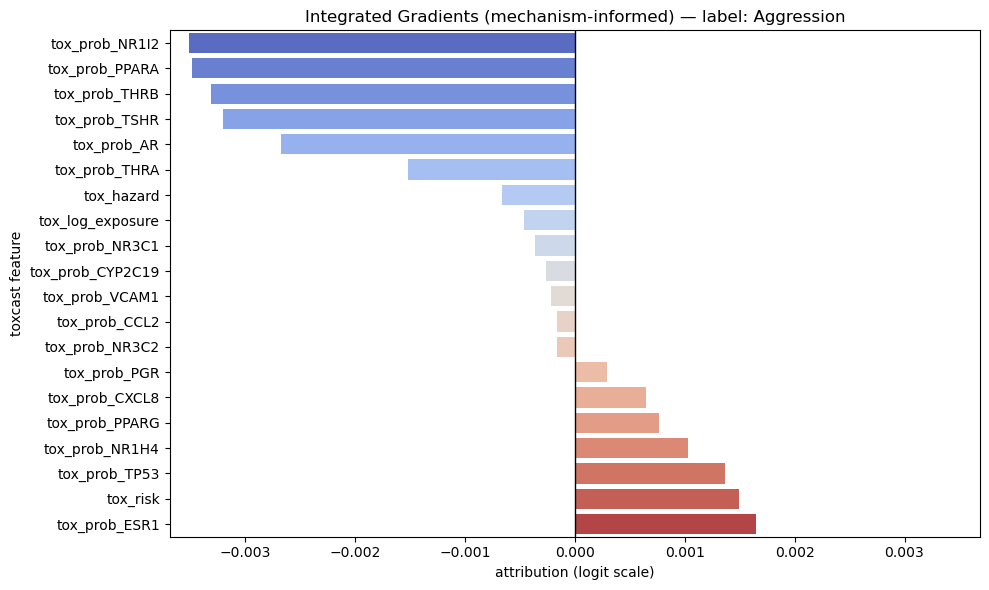

In [16]:
from captum.attr import IntegratedGradients
from rdkit.Chem import Draw
import matplotlib.cm as cm

from jhm_toxcast.featurize import morgan_fp, safe_mol_from_smiles
from jhm_toxcast.model import MultiTaskNet, mol_to_graph_tensors


def load_multitask_net(model_dir: Path) -> MultiTaskNet:
    payload = torch.load(model_dir / "net.pt", map_location="cpu")
    net = MultiTaskNet(**payload["model_kwargs"])
    net.load_state_dict(payload["state_dict"])
    net.to(DEVICE)
    net.eval()
    return net


def mol_attention_image(mol, weights: np.ndarray, *, size=(360, 260)):
    n_atoms = mol.GetNumAtoms()
    w = np.asarray(weights[:n_atoms], dtype=float)
    w = (w - w.min()) / (w.max() - w.min() + 1e-12)

    cmap = cm.get_cmap("Reds")
    atom_colors = {i: tuple(cmap(float(v))[:3]) for i, v in enumerate(w)}

    return Draw.MolToImage(
        mol,
        size=size,
        highlightAtoms=list(atom_colors.keys()),
        highlightAtomColors=atom_colors,
    )


# 选取一个测试集样本（以 toxcast-enhanced 模型的最高置信样本为例）
side_test = pd.read_csv(tox_out / "test_samples.tsv", sep="	")
pred_npz = np.load(tox_out / "test_predictions.npz")
y_true = pred_npz["y_true"].astype(int)
probs = pred_npz["y_prob"].astype(float)
labels = read_json(tox_out / "labels.json")["labels"]

# IG 目标标签选择策略：优先挑选“机制增强在 test 上提升最大的标签”（若上一步已计算 per-label ΔAUPRC）。
# 若不可用，则回退到“该样本最自信的预测标签”。
label_idx = None
label_name = None
if "m" in globals() and isinstance(m, pd.DataFrame) and {"pt_term", "delta_auprc"}.issubset(set(m.columns)):
    best = m.sort_values("delta_auprc", ascending=False).iloc[0]["pt_term"]
    if isinstance(best, str) and best in labels:
        label_name = best
        label_idx = int(labels.index(best))

if label_idx is None:
    row0 = int(np.argmax(probs.max(axis=1)))
    label_idx = int(np.argmax(probs[row0]))
    label_name = str(labels[label_idx])

# 样本选择：若该标签在 test 中存在正样本，则取预测概率最高的正样本；否则取该标签预测概率最高的样本。
pos = np.where(y_true[:, label_idx] > 0)[0]
if pos.size > 0:
    row = int(pos[np.argmax(probs[pos, label_idx])])
else:
    row = int(np.argmax(probs[:, label_idx]))
smiles = str(side_test.iloc[row]["smiles"])
name = str(side_test.iloc[row].get("name", ""))
print(f"IG target label: {label_name} (index={int(label_idx)})")

mol = safe_mol_from_smiles(smiles)
if mol is None:
    raise ValueError("Invalid SMILES in test_samples.tsv")

# 计算图输入
x, adj, mask = mol_to_graph_tensors(mol, max_atoms=128)
x_b = x.unsqueeze(0).to(DEVICE)
adj_b = adj.unsqueeze(0).to(DEVICE)
mask_b = mask.unsqueeze(0).to(DEVICE)

# baseline: global feat = Morgan FP
fp = morgan_fp(smiles, n_bits=int(SIDER_FP_N_BITS))
if fp is None:
    raise ValueError("Morgan fingerprint failed")
fp_b = torch.tensor(fp[None, :], dtype=torch.float32, device=DEVICE)

# toxcast-enhanced: global feat = [Morgan FP ; z-scored toxcast features]
tox_feat_meta = read_json(tox_out / "toxcast_features.json")
feat_names = list(tox_feat_meta.get("feature_names", []))
mean = np.asarray(tox_feat_meta.get("zscore_mean", []), dtype=np.float32)
std = np.asarray(tox_feat_meta.get("zscore_std", []), dtype=np.float32)

# ToxCast/CTX features via bundle prediction
mc_samples = int(tox_feat_meta.get("mc_samples", SIDER_TOXCAST_MC_SAMPLES))
pred = predict_smiles(bundle, [smiles], device=DEVICE, mc_samples=mc_samples, topk=0)
base = pred.summary.loc[0, ["hazard_pred", "log_exposure_pred", "risk_score_pred_ensemble"]].to_numpy(dtype=np.float32)

tox_genes = list(tox_feat_meta.get("toxcast_genes", [])) or list(pred.target_probs.columns)
prob_s = pred.target_probs.loc[0]
prob = prob_s.reindex(tox_genes).to_numpy(dtype=np.float32)
prob = np.nan_to_num(prob, nan=0.0)

include_diffused = bool(tox_feat_meta.get("include_diffused", False)) or any(
    str(n).startswith("tox_prob_diff_") for n in feat_names
)
diff = None
if include_diffused:
    from jhm_toxcast.data_sources import fetch_invitrodb_artifacts
    from jhm_toxcast.mechanistic import build_gene_network_from_invitrodb, diffuse_gene_scores
    from jhm_toxcast.pipeline import read_assay_annotations, read_assay_target_mappings

    art = fetch_invitrodb_artifacts()
    assay_ann = read_assay_annotations(str(art.assay_annotations_xlsx))
    assay_map = read_assay_target_mappings(str(art.assay_target_mappings_xlsx))
    gene_network = build_gene_network_from_invitrodb(assay_map, assay_ann, tox_genes)
    diff = diffuse_gene_scores(prob[None, :], gene_network).astype(np.float32)[0]

gene_to_idx = {g: i for i, g in enumerate(tox_genes)}

# 构造与训练时一致的机制特征向量（严格按 toxcast_features.json 的 feature_names 顺序）
feat_vals: list[float] = []
for name_ in feat_names:
    if name_ == "tox_hazard":
        feat_vals.append(float(base[0]))
    elif name_ == "tox_log_exposure":
        feat_vals.append(float(base[1]))
    elif name_ == "tox_risk":
        feat_vals.append(float(base[2]))
    elif str(name_).startswith("tox_prob_diff_"):
        g = str(name_).removeprefix("tox_prob_diff_")
        if diff is None or g not in gene_to_idx:
            feat_vals.append(0.0)
        else:
            feat_vals.append(float(diff[gene_to_idx[g]]))
    elif str(name_).startswith("tox_prob_"):
        g = str(name_).removeprefix("tox_prob_")
        feat_vals.append(float(prob[gene_to_idx[g]]) if g in gene_to_idx else 0.0)
    else:
        raise ValueError(f"Unknown toxcast feature name: {name_}")

feat = np.asarray(feat_vals, dtype=np.float32)
if mean.shape[0] != feat.shape[0] or std.shape[0] != feat.shape[0]:
    raise ValueError("toxcast feature dimension mismatch; rerun toxcast-enhanced training to refresh toxcast_features.json")
feat_z = (feat - mean) / (std + 1e-12)

global_feat = np.concatenate([fp.astype(np.float32), feat_z.astype(np.float32)], axis=0)
global_b = torch.tensor(global_feat[None, :], dtype=torch.float32, device=DEVICE)

# load models
net_base = load_multitask_net(SIDER_BASELINE_OUT)
net_tox = load_multitask_net(tox_out)

with torch.no_grad():
    _, logits_base, attn_base = net_base(x_b, adj_b, mask_b, fp_b)
    _, logits_tox, attn_tox = net_tox(x_b, adj_b, mask_b, global_b)

p_tox = torch.sigmoid(logits_tox).detach().cpu().numpy()[0]
top_idx = np.argsort(-p_tox)[:5]
print("Example drug:", name)
print("SMILES:", smiles)
print("Top predicted ADR labels:")
for j in top_idx:
    print(f"  {labels[j]}: {p_tox[j]:.3f}")

img_base = mol_attention_image(mol, attn_base.detach().cpu().numpy()[0])
img_tox = mol_attention_image(mol, attn_tox.detach().cpu().numpy()[0])

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(img_base)
ax[0].set_title("Atom-level attention (baseline)")
ax[0].axis("off")

ax[1].imshow(img_tox)
ax[1].set_title("Atom-level attention (mechanism-informed)")
ax[1].axis("off")

plt.suptitle("SIDER: qualitative interpretability")
plt.tight_layout()
plt.show()

# Integrated Gradients: attribute global features (focus on toxcast part)
ig_label_idx = int(label_idx)
print(
    f"IG label: {labels[ig_label_idx]} | y_true={int(y_true[row, ig_label_idx])} | y_pred={float(p_tox[ig_label_idx]):.3f}"
)

# Wrap the network to attribute only global_feat while holding graph input fixed

def forward_global(g: torch.Tensor) -> torch.Tensor:
    # Captum 会在内部把输入沿 batch 维度堆叠（例如 n_steps=64），
    # 因此需要把图输入复制到同样的 batch 大小，避免 shape mismatch。
    bsz = int(g.shape[0])
    x_rep = x_b.expand(bsz, -1, -1)
    adj_rep = adj_b.expand(bsz, -1, -1)
    mask_rep = mask_b.expand(bsz, -1)
    _, logits, _ = net_tox(x_rep, adj_rep, mask_rep, g)
    return logits[:, ig_label_idx]

ig = IntegratedGradients(forward_global)
attr = ig.attribute(global_b, baselines=torch.zeros_like(global_b), n_steps=64)
attr_np = attr.detach().cpu().numpy()[0]

fp_dim = int(global_b.shape[1] - len(feat_names))
tox_attr = attr_np[fp_dim:]

attr_df = pd.DataFrame({"feature": feat_names, "attr": tox_attr})
attr_df["abs_attr"] = attr_df["attr"].abs()

show = attr_df.sort_values("abs_attr", ascending=False).head(20).sort_values("attr")
max_abs_attr = float(show["abs_attr"].max()) if len(show) else 0.0
if max_abs_attr < 1e-8:
    print("[IG] Warning: toxcast feature attributions are ~0; this usually means the model is effectively ignoring the mechanism block.")
plt.figure(figsize=(10, 6))
sns.barplot(data=show, x="attr", y="feature", palette="coolwarm")
if max_abs_attr > 0:
    plt.xlim(-1.05 * max_abs_attr, 1.05 * max_abs_attr)
plt.axvline(0, color="black", lw=1)
plt.title(f"Integrated Gradients (mechanism-informed) — label: {labels[ig_label_idx]}")
plt.xlabel("attribution (logit scale)")
plt.ylabel("toxcast feature")
plt.tight_layout()
plt.show()


## C) openFDA(FAERS)：季度时间切分早预警（深度学习 + 强化学习排序优化）

### 任务定义

- 数据来源：openFDA 提供的 FAERS bulk 分区（按季度）。
- 预处理：按季度统计 `drug` / `PT` / `drug–PT` 报告计数（可选仅使用 suspect drugs）。
- 早预警目标：对季度 *t* 的 drug–PT 对，预测其在 *t+1* 是否形成“可关注信号”。本 Notebook 默认采用 threshold 标签（min_next_count=1；见配置区 `OPENFDA_LABEL_MODE`）。

### 两条主线（本 Notebook 默认全量运行）

1) **深度学习早预警（PyTorch）**：drug/PT embedding + disproportionality 数值特征（ROR/PRR/IC 等），以时间切分方式训练并在最后一次过渡上测试。
2) **强化学习微调（REINFORCE）**：在深度模型基础上，将“挑选 top-K 信号”的动作显式建模为策略，并直接优化 `precision@K`（更贴近药物警戒的排序目标）。

> 注：传统线性模型（LR/SGD）在此不作为主干方法；如果需要可另行作为附录对照。


In [17]:
# --- 1) 构建 openFDA 季度计数表（v2 格式；全量 + 断点续跑）
#
# 说明：
# - 构建脚本输出“按季度的中间产物”，并以 out_dir/quarters/<q>/meta.json 作为断点标记。
# - 若中途中断，只要重新运行本单元即可继续（默认 --resume）。
# - 为避免“meta.json 存在但覆盖范围不完整”的误判，这里会校验 quarters_processed 是否覆盖配置的季度范围。

required_quarters = [str(q).strip().lower() for q in OPENFDA_QUARTERS]


def openfda_counts_ready() -> tuple[bool, bool]:
    meta_path = OPENFDA_COUNTS_DIR / "meta.json"
    if not meta_path.exists():
        return False, False
    try:
        meta = read_json(meta_path)
    except Exception:  # noqa: BLE001
        return False, False

    if int(meta.get("format_version") or 0) != 2:
        return False, True
    if bool(meta.get("suspect_only")) != bool(OPENFDA_SUSPECT_ONLY):
        return False, True
    if bool(meta.get("prefer_openfda")) != bool(OPENFDA_PREFER_OPENFDA_NAME):
        return False, True

    # 配置变化需要覆盖重建；否则 build 脚本会在 --resume 下跳过已有季度，导致“看似重跑但未生效”。
    if str(meta.get("name_strategy") or "all").strip().lower() != str(OPENFDA_COUNTS_NAME_STRATEGY).strip().lower():
        return False, True
    if bool(meta.get("filter_low_quality", False)) != bool(OPENFDA_COUNTS_FILTER_LOW_QUALITY):
        return False, True
    if meta.get("max_drugs_per_report") != OPENFDA_COUNTS_MAX_DRUGS_PER_REPORT:
        return False, True
    if meta.get("max_pts_per_report") != OPENFDA_COUNTS_MAX_PTS_PER_REPORT:
        return False, True

    processed = {str(x).strip().lower() for x in (meta.get("quarters_processed") or [])}
    missing = [q for q in required_quarters if q not in processed]

    # 全局汇总文件用于后续词表与归一化，缺失时也应触发重建（不会覆盖已完成季度）
    needed = [
        OPENFDA_COUNTS_DIR / "total_reports.tsv",
        OPENFDA_COUNTS_DIR / "drug_totals.tsv",
        OPENFDA_COUNTS_DIR / "pt_totals.tsv",
    ]
    if any(not p.exists() for p in needed):
        return False, False

    if missing:
        print(f"[openFDA] counts cache incomplete: missing {len(missing)} quarters (example={missing[:5]})")
        return False, False
    return True, False


counts_ready, need_overwrite = openfda_counts_ready()
if FORCE_REBUILD_OPENFDA_COUNTS or not counts_ready:
    cmd = [
        PY,
        "scripts/build_openfda_event_counts.py",
        "--raw-dir",
        str(OPENFDA_RAW_DIR),
        "--out-dir",
        str(OPENFDA_COUNTS_DIR),
        "--start-quarter",
        str(OPENFDA_START_QUARTER),
        "--end-quarter",
        str(OPENFDA_END_QUARTER),
        "--download-retries",
        "5",
    ]
    if FORCE_REBUILD_OPENFDA_COUNTS or need_overwrite:
        cmd.append("--overwrite")
    cmd += ["--name-strategy", str(OPENFDA_COUNTS_NAME_STRATEGY)]
    if OPENFDA_COUNTS_FILTER_LOW_QUALITY:
        cmd.append("--filter-low-quality")
    if OPENFDA_COUNTS_MAX_DRUGS_PER_REPORT is not None:
        cmd += ["--max-drugs-per-report", str(int(OPENFDA_COUNTS_MAX_DRUGS_PER_REPORT))]
    if OPENFDA_COUNTS_MAX_PTS_PER_REPORT is not None:
        cmd += ["--max-pts-per-report", str(int(OPENFDA_COUNTS_MAX_PTS_PER_REPORT))]
    if OPENFDA_MAX_FILES_PER_QUARTER is not None:
        cmd += ["--max-files-per-quarter", str(int(OPENFDA_MAX_FILES_PER_QUARTER))]
    if OPENFDA_MAX_REPORTS_PER_FILE is not None:
        cmd += ["--max-reports-per-file", str(int(OPENFDA_MAX_REPORTS_PER_FILE))]
    if OPENFDA_PREFER_OPENFDA_NAME:
        cmd.append("--prefer-openfda")
    if OPENFDA_SUSPECT_ONLY:
        cmd.append("--suspect-only")
    run(cmd)
else:
    print("Found existing openFDA counts (complete), skip build:", OPENFDA_COUNTS_DIR)


Found existing openFDA counts (complete), skip build: data/processed/openfda_counts_2004q1_2025q3


In [18]:
openfda_meta = read_json(OPENFDA_COUNTS_DIR / "meta.json")
print("format_version:", openfda_meta.get("format_version"))
print("n_partitions:", openfda_meta.get("n_partitions"))
print("suspect_only:", openfda_meta.get("suspect_only"), "| prefer_openfda:", openfda_meta.get("prefer_openfda"))
print(
    "max_files_per_quarter:",
    openfda_meta.get("max_files_per_quarter"),
    "| max_reports_per_file:",
    openfda_meta.get("max_reports_per_file"),
)

quarters_processed = [str(x).strip().lower() for x in (openfda_meta.get("quarters_processed") or [])]
print("quarters_processed:", f"n={len(quarters_processed)}")

# 全局季度报告数（用于后续归一化 / 绘图 / rolling backtest）
total_reports = pd.read_csv(OPENFDA_COUNTS_DIR / "total_reports.tsv", sep="	", dtype={"quarter": str})
total_reports["quarter"] = total_reports["quarter"].astype(str).str.lower()
total_reports = total_reports.sort_values("quarter", key=lambda s: s.map(quarter_to_idx))

print("total_reports.tsv:", total_reports.shape)
total_reports.head(10)


format_version: 2
n_partitions: 1678
suspect_only: True | prefer_openfda: True
max_files_per_quarter: None | max_reports_per_file: None
quarters_processed: n=87
total_reports.tsv: (87, 2)


quarter  n_reports
0  2004q1      50654
1  2004q2      49964
2  2004q3      52846
3  2004q4      56532
4  2005q1      59845
5  2005q2      54286
6  2005q3      57759
7  2005q4      58406
8  2006q1      61218
9  2006q2      55885

### C0) openFDA 数据概览与探索性分析（工作量可见）

该部分用于回答：在我们选择的季度范围内，FAERS 报告体量、drug/PT 词表规模以及 drug–PT 对的稀疏性如何。
这些统计图既是结果解释的前提，也可以直接用于报告/补充材料的数据描述部分。


In [19]:
# --- 0) 读取计数元数据：季度概览 + top-k 词表

from collections import Counter

OPENFDA_QUARTERS_DIR = OPENFDA_COUNTS_DIR / "quarters"
if not OPENFDA_QUARTERS_DIR.exists():
    raise FileNotFoundError(
        f"Expected v2 openFDA counts under {OPENFDA_COUNTS_DIR}, but missing: {OPENFDA_QUARTERS_DIR}"
    )

available_quarters = [p.name.lower() for p in OPENFDA_QUARTERS_DIR.iterdir() if p.is_dir()]
available_quarters = sorted(set(available_quarters), key=quarter_to_idx)

openfda_quarters = [q for q in OPENFDA_QUARTERS if q in set(available_quarters)]
openfda_quarters = sorted(openfda_quarters, key=quarter_to_idx)
if len(openfda_quarters) < 3:
    raise ValueError("Need at least 3 quarters to do time-split evaluation.")

print("available_quarters:", f"{available_quarters[0]} → {available_quarters[-1]} (n={len(available_quarters)})")
print("openfda_quarters (used):", f"{openfda_quarters[0]} → {openfda_quarters[-1]} (n={len(openfda_quarters)})")

# 季度统计优先使用 quarter/meta.json（避免扫描大体量 pair 文件）
q_stats = []
total_map = total_reports.set_index("quarter")["n_reports"].astype(float).to_dict()
for q in openfda_quarters:
    qmeta = read_json(OPENFDA_QUARTERS_DIR / q / "meta.json")
    q_stats.append(
        {
            "quarter": q,
            "n_reports": float(total_map.get(q, qmeta.get("n_reports") or 0.0)),
            "n_unique_drugs": int(qmeta.get("n_unique_drugs") or 0),
            "n_unique_pts": int(qmeta.get("n_unique_pts") or 0),
            "n_pairs": int(qmeta.get("n_pairs") or 0),
        }
    )
q_stats = pd.DataFrame(q_stats).sort_values("quarter", key=lambda s: s.map(quarter_to_idx))

# 全局 top-k 词表：优先读取 build_openfda_event_counts.py 输出的汇总文件
p_drug_totals = OPENFDA_COUNTS_DIR / "drug_totals.tsv"
p_pt_totals = OPENFDA_COUNTS_DIR / "pt_totals.tsv"
if p_drug_totals.exists() and p_pt_totals.exists():
    drug_totals = pd.read_csv(p_drug_totals, sep="	", dtype={"drug": str})
    pt_totals = pd.read_csv(p_pt_totals, sep="	", dtype={"pt": str})
    drug_sum = drug_totals.set_index("drug")["n_reports"].astype(float)
    pt_sum = pt_totals.set_index("pt")["n_reports"].astype(float)
else:
    drug_c = Counter()
    pt_c = Counter()
    for q in openfda_quarters:
        ddf = pd.read_csv(OPENFDA_QUARTERS_DIR / q / "drug_counts.tsv", sep="	", dtype={"drug": str})
        pdf = pd.read_csv(OPENFDA_QUARTERS_DIR / q / "pt_counts.tsv", sep="	", dtype={"pt": str})
        for d, n in zip(ddf["drug"].astype(str), ddf["n_reports"].astype(float), strict=False):
            drug_c[d] += int(n)
        for pt, n in zip(pdf["pt"].astype(str), pdf["n_reports"].astype(float), strict=False):
            pt_c[pt] += int(n)
    drug_sum = pd.Series(drug_c, dtype=float)
    pt_sum = pd.Series(pt_c, dtype=float)

keep_drugs = set(drug_sum.sort_values(ascending=False).head(int(OPENFDA_TOP_DRUGS)).index.tolist())
keep_pts = set(pt_sum.sort_values(ascending=False).head(int(OPENFDA_TOP_PTS)).index.tolist())

print("keep_drugs:", len(keep_drugs), "| keep_pts:", len(keep_pts))
q_stats


available_quarters: 2004q1 → 2025q3 (n=87)
openfda_quarters (used): 2004q1 → 2025q3 (n=87)
keep_drugs: 5000 | keep_pts: 2000


quarter  n_reports  n_unique_drugs  n_unique_pts  n_pairs
0   2004q1    50654.0            6569          6259   157762
1   2004q2    49964.0            6536          6332   153287
2   2004q3    52846.0            6915          6620   160215
3   2004q4    56532.0            7074          6632   163301
4   2005q1    59845.0            7340          6976   178840
..     ...        ...             ...           ...      ...
82  2024q3   338026.0            4496         11504   417140
83  2024q4   331565.0            4629         11797   416849
84  2025q1   327195.0            4640         11689   413367
85  2025q2   340874.0            4540         12162   439018
86  2025q3   423812.0            4752         12932   520853

[87 rows x 5 columns]

### C0.5) 05-25（2005–2025）采样报告：化合物（drug）全量清单导出

openFDA counts 的全局汇总文件 `drug_totals.tsv` 可能包含 **数十万** 个不同药名。
直接在 Notebook 输出区完整打印会非常卡顿，因此这里将**全量清单写入文件**，并在 Notebook 中只展示行数与预览。


In [20]:
# --- C0.5) Export full compound list (avoid printing 200k+ lines in output)

from IPython.display import FileLink, Markdown, display

if 'drug_totals' not in globals():
    p_drug_totals = OPENFDA_COUNTS_DIR / 'drug_totals.tsv'
    drug_totals = pd.read_csv(p_drug_totals, sep='	', dtype={'drug': str})

q0 = str(openfda_quarters[0])
q1 = str(openfda_quarters[-1])
out_dir = Path('data/outputs')
out_dir.mkdir(parents=True, exist_ok=True)
out_tsv = out_dir / f'openfda_compounds_{q0}_{q1}.tsv'
out_txt = out_dir / f'openfda_compounds_{q0}_{q1}.txt'

# Save full table + a plain list (one drug per line)
drug_totals[['drug','n_reports']].to_csv(out_tsv, sep='	', index=False)
out_txt.write_text('\n'.join(drug_totals['drug'].astype(str).tolist()) + '\n', encoding='utf-8')

display(Markdown(f'Exported `{len(drug_totals)}` drug names to `{out_txt}` and totals table to `{out_tsv}`'))
display(FileLink(str(out_txt)))
display(drug_totals.head(30))

# --- 05-25（2005–2025）采样表：化合物 × 疾病(Indication) × 不良反应(PT)
# 说明：这里按“每年取一个季度 + 每季度取最小的 1 个分区文件 + 每文件最多 N 条报告”的方式做快速采样，
# 用于 Notebook 中快速生成可读表格；如需更精确统计，可增大采样规模或做全量扫描。

sample_out = out_dir / 'openfda_05_25_drug_disease_adr_sample.tsv'
sample_meta = out_dir / 'openfda_05_25_drug_disease_adr_sample.meta.json'

if sample_out.exists() and sample_meta.exists():
    display(Markdown(f'Found existing 05-25 sampled table: `{sample_out}` (meta: `{sample_meta}`)'))
else:
    cmd = [
        PY,
        'scripts/export_openfda_drug_disease_adr_table.py',
        '--raw-dir', str(OPENFDA_RAW_DIR),
        '--counts-dir', str(OPENFDA_COUNTS_DIR),
        '--start-year', '2005',
        '--end-year', '2025',
        '--quarter', '1',
        '--max-files-per-quarter', '1',
        '--max-reports-per-file', '500',
        '--top-drugs', '50',
        '--topk-indications', '3',
        '--topk-pts', '5',
        '--name-strategy', str(OPENFDA_COUNTS_NAME_STRATEGY),
        '--filter-low-quality',
        '--out-tsv', str(sample_out),
        '--out-meta', str(sample_meta),
    ]
    if bool(OPENFDA_SUSPECT_ONLY):
        cmd.append('--suspect-only')
    if bool(OPENFDA_PREFER_OPENFDA_NAME):
        cmd.append('--prefer-openfda')
    run(cmd)
    display(Markdown(f'05-25 sampled drug+disease+ADR table saved to `{sample_out}` (meta: `{sample_meta}`)'))

tbl = pd.read_csv(sample_out, sep='\t')
display(tbl.head(30))


Exported `220255` drug names to `data/outputs/openfda_compounds_2004q1_2025q3.txt` and totals table to `data/outputs/openfda_compounds_2004q1_2025q3.tsv`

/media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/JHM/data/outputs/openfda_compounds_2004q1_2025q3.txt

drug  n_reports
0                  ZOLEDRONIC ACID      23773
1                        CLOZAPINE     107253
2                        VALSARTAN     144984
3                           PLETAL       1135
4                        CELECOXIB      46429
5                           BEXTRA      11208
6                          LEVITRA       4844
7         FLUOXETINE HYDROCHLORIDE      36066
8                           STADOL        393
9         PAROXETINE HYDROCHLORIDE      34233
10                        DECADRON       4261
11                      PREDNISONE     118807
12       DOXORUBICIN HYDROCHLORIDE      55721
13                     THALIDOMIDE      29395
14                     VINCRISTINE      38512
15        SERTRALINE HYDROCHLORIDE      67998
16                           VIOXX      38057
17                   OXCARBAZEPINE      13568
18                        RIVOTRIL       6594
19  LANTAREL(METHOTREXATE, UNSPEC)          1
20                      ETANERCEPT     535975
21                      VANCOMYCIN      25144
22        VANCOMYCIN HYDROCHLORIDE      25435
23                     SIMVASTATIN      38460
24                     MEPRONIZINE        171
25                      FUROSEMIDE      40225
26                      ALPRAZOLAM      49823
27                        DIAZEPAM      34920
28  PREDNISONE(ROXANE)(PREDNISONE)          1
29          MELPHALAN (MELPHALAN,)          1

Found existing 05-25 sampled table: `data/outputs/openfda_05_25_drug_disease_adr_sample.tsv` (meta: `data/outputs/openfda_05_25_drug_disease_adr_sample.meta.json`)

drug  n_reports_sampled  \
0                    ZANTAC                495   
1                 DUPILUMAB                187   
2         DIMETHYL FUMARATE                169   
3                 CLOZAPINE                121   
4                ADALIMUMAB                111   
5              LENALIDOMIDE                 65   
6            LEVONORGESTREL                 65   
7                 DENOSUMAB                 55   
8                   ELIQUIS                 31   
9               BEVACIZUMAB                 30   
10      QUETIAPINE FUMARATE                 28   
11             TREPROSTINIL                 27   
12            ACETAMINOPHEN                 21   
13         INSULIN GLARGINE                 20   
14             POMALIDOMIDE                 19   
15      TOFACITINIB CITRATE                 19   
16                RITUXIMAB                 13   
17              AMBRISENTAN                 12   
18                ABATACEPT                 10   
19       CERTOLIZUMAB PEGOL                 10   
20       INTERFERON BETA-1A                  7   
21  METFORMIN HYDROCHLORIDE                  6   
22               INFLIXIMAB                  4   
23                IBUPROFEN                  2   
24  OXYCODONE HYDROCHLORIDE                  2   
25              RISPERIDONE                  2   
26               PREGABALIN                  1   
27               TACROLIMUS                  1   
28                ADAPALENE                  0   
29               APREMILAST                  0   

                                      top_indications  \
0   DYSPEPSIA (333); GASTROOESOPHAGEAL REFLUX DISE...   
1    DERMATITIS ATOPIC (88); ECZEMA (22); ASTHMA (20)   
2   MULTIPLE SCLEROSIS (159); RELAPSING-REMITTING ...   
3   SCHIZOPHRENIA (78); SCHIZOAFFECTIVE DISORDER (...   
4   CROHN'S DISEASE (39); PSORIASIS (23); RHEUMATO...   
5   MULTIPLE MYELOMA (44); PLASMA CELL MYELOMA (5)...   
6   POST COITAL CONTRACEPTION (50); CONTRACEPTION ...   
7   OSTEOPOROSIS (9); OSTEOPOROSIS POSTMENOPAUSAL ...   
8   DEEP VEIN THROMBOSIS (2); ATRIAL FIBRILLATION ...   
9   OVARIAN CANCER (3); RENAL CELL CARCINOMA (2); ...   
10   DEPRESSION (4); SLEEP DISORDER (3); INSOMNIA (2)   
11  PULMONARY ARTERIAL HYPERTENSION (22); PULMONAR...   
12  HEADACHE (3); INSOMNIA (2); RHEUMATOID ARTHRIT...   
13  DIABETES MELLITUS (8); TYPE 2 DIABETES MELLITU...   
14  PLASMA CELL MYELOMA (17); PLASMA CELL MYELOMA ...   
15  RHEUMATOID ARTHRITIS (3); PSORIATIC ARTHROPATH...   
16  IMMUNE THROMBOCYTOPENIA (1); RHEUMATOID ARTHRI...   
17  PULMONARY ARTERIAL HYPERTENSION (11); PULMONAR...   
18  RHEUMATOID ARTHRITIS (8); PSORIATIC ARTHROPATH...   
19  RHEUMATOID ARTHRITIS (3); PSORIATIC ARTHROPATH...   
20  MULTIPLE SCLEROSIS (6); RELAPSING-REMITTING MU...   
21  INCORRECT DOSE ADMINISTERED (1); TYPE 2 DIABET...   
22  CROHN'S DISEASE (2); RHEUMATOID ARTHRITIS (2);...   
23                               SEASONAL ALLERGY (1)   
24                                                NaN   
25  AFFECTIVE DISORDER (1); IRRITABILITY (1); AGGR...   
26                                                NaN   
27                                                NaN   
28                                                NaN   
29                                                NaN   

                                             top_adrs  
0   PROSTATE CANCER (67); COLORECTAL CANCER (58); ...  
1   DERMATITIS ATOPIC (22); PRODUCT USE IN UNAPPRO...  
2   FLUSHING (21); FATIGUE (10); MEMORY IMPAIRMENT...  
3   DEATH (19); HOSPITALISATION (16); TREATMENT NO...  
4   INJECTION SITE PAIN (9); INJECTION SITE ERYTHE...  
5   DEATH (17); MULTIPLE MYELOMA (9); RASH (4); WH...  
6   MENSTRUATION IRREGULAR (32); PELVIC PAIN (7); ...  
7   PRODUCT STORAGE ERROR (21); CIRCUMSTANCE OR IN...  
8   DEATH (12); PAIN IN EXTREMITY (1); ATRIAL FIBR...  
9   FATIGUE (3); NAUSEA (2); ILL-DEFINED DISORDER ...  
10  DRUG DOSE OMISSION (8); SOMNOLENCE (3); INSOMN...  
11  DYSPNOEA (3); DIARRHOEA (3);

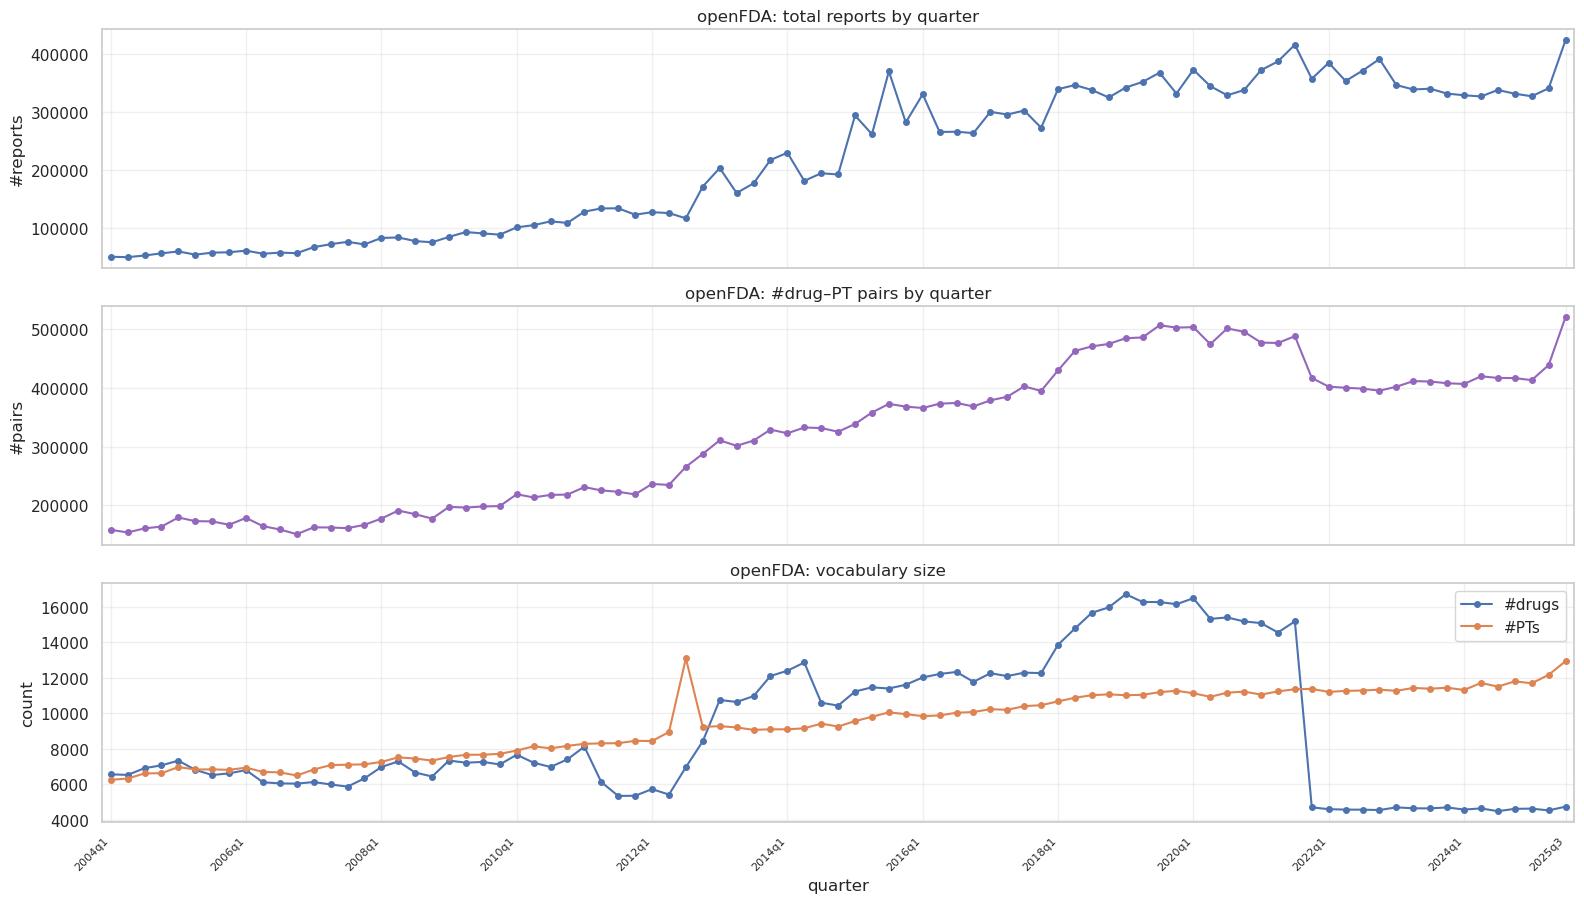

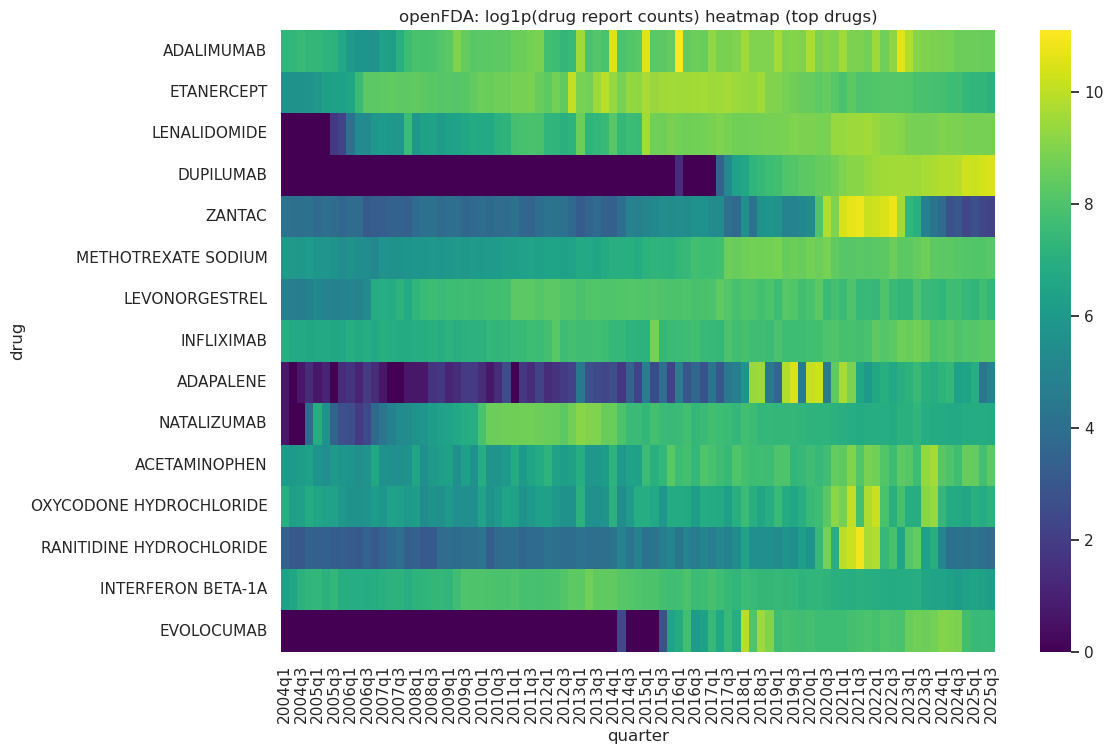

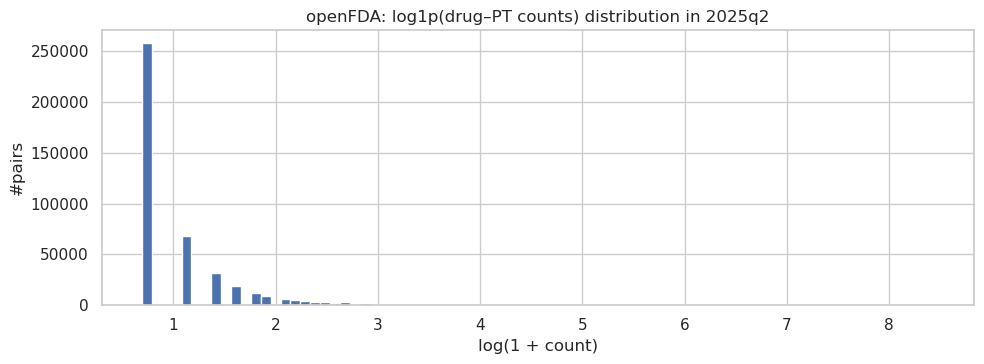

[openFDA] label_mode != emerging; skip candidate-set diagnostics.


In [21]:
# --- 0) 可视化：报告体量、词表规模、以及稀疏性

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

import numpy as np

quarters = q_stats["quarter"].astype(str).tolist()
x = np.arange(len(quarters))

# Quarter tick helper is defined in the utilities cell.

fig, ax = plt.subplots(3, 1, figsize=(16, 9.2), sharex=True)

ax[0].plot(x, q_stats["n_reports"].to_numpy(dtype=float), marker="o", linewidth=1.5, markersize=4)
ax[0].set_title("openFDA: total reports by quarter")
ax[0].set_ylabel("#reports")
ax[0].grid(True, alpha=0.3)

ax[1].plot(
    x,
    q_stats["n_pairs"].to_numpy(dtype=float),
    marker="o",
    linewidth=1.5,
    markersize=4,
    color="tab:purple",
)
ax[1].set_title("openFDA: #drug–PT pairs by quarter")
ax[1].set_ylabel("#pairs")
ax[1].grid(True, alpha=0.3)

ax[2].plot(x, q_stats["n_unique_drugs"].to_numpy(dtype=float), marker="o", linewidth=1.5, markersize=4, label="#drugs")
ax[2].plot(x, q_stats["n_unique_pts"].to_numpy(dtype=float), marker="o", linewidth=1.5, markersize=4, label="#PTs")
ax[2].set_title("openFDA: vocabulary size")
ax[2].set_xlabel("quarter")
ax[2].set_ylabel("count")
ax[2].grid(True, alpha=0.3)
ax[2].legend()

ax[0].tick_params(axis="x", labelbottom=False)
ax[1].tick_params(axis="x", labelbottom=False)
apply_quarter_ticks(ax[2], quarters, max_labels=12)

plt.tight_layout()
plt.show()

# top-k 基础统计

top_k = 20

drug_sum_sorted = drug_sum.sort_values(ascending=False)
pt_sum_sorted = pt_sum.sort_values(ascending=False)

top_drugs = drug_sum_sorted.head(top_k).reset_index()
top_drugs.columns = ["drug", "n_reports"]
top_pts = pt_sum_sorted.head(top_k).reset_index()
top_pts.columns = ["pt", "n_reports"]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=top_drugs, x="n_reports", y="drug", color="steelblue", ax=ax[0])
ax[0].set_title("openFDA: top drugs by total reports")
ax[0].set_xlabel("#reports")
ax[0].set_ylabel("drug")

sns.barplot(data=top_pts, x="n_reports", y="pt", color="darkorange", ax=ax[1])
ax[1].set_title("openFDA: top PTs by total reports")
ax[1].set_xlabel("#reports")
ax[1].set_ylabel("PT")

plt.tight_layout()
plt.show()

# 热图：top drugs / top PTs 在各季度的体量变化（用于补充材料）

top_d = top_drugs["drug"].head(15).tolist()
pivot_d = pd.DataFrame(0.0, index=top_d, columns=openfda_quarters)
for q in openfda_quarters:
    ddf = pd.read_csv(
        OPENFDA_QUARTERS_DIR / q / "drug_counts.tsv",
        sep="	",
        dtype={"drug": str},
        usecols=["drug", "n_reports"],
    )
    sub = ddf[ddf["drug"].isin(top_d)].copy()
    if not sub.empty:
        pivot_d.loc[sub["drug"].tolist(), q] = sub["n_reports"].to_numpy(dtype=float)

plt.figure(figsize=(12, 0.38 * len(top_d) + 2.0))
sns.heatmap(np.log1p(pivot_d), cmap="viridis")
plt.title("openFDA: log1p(drug report counts) heatmap (top drugs)")
plt.xlabel("quarter")
plt.ylabel("drug")
plt.tight_layout()
plt.show()


top_p = top_pts["pt"].head(15).tolist()
pivot_p = pd.DataFrame(0.0, index=top_p, columns=openfda_quarters)
for q in openfda_quarters:
    pdf = pd.read_csv(
        OPENFDA_QUARTERS_DIR / q / "pt_counts.tsv",
        sep="	",
        dtype={"pt": str},
        usecols=["pt", "n_reports"],
    )
    sub = pdf[pdf["pt"].isin(top_p)].copy()
    if not sub.empty:
        pivot_p.loc[sub["pt"].tolist(), q] = sub["n_reports"].to_numpy(dtype=float)

plt.figure(figsize=(12, 0.38 * len(top_p) + 2.0))
sns.heatmap(np.log1p(pivot_p), cmap="mako")
plt.title("openFDA: log1p(PT report counts) heatmap (top PTs)")
plt.xlabel("quarter")
plt.ylabel("PT")
plt.tight_layout()
plt.show()

# 稀疏性：drug–PT 计数分布（以 test_from 季度为例）

test_from = openfda_quarters[-2]
pair_path = OPENFDA_QUARTERS_DIR / test_from / "drug_pt_counts.tsv"
sub = pd.read_csv(pair_path, sep="	", usecols=["n_reports"])
plt.figure(figsize=(10, 3.8))
plt.hist(np.log1p(sub["n_reports"].to_numpy(dtype=float)), bins=80)
plt.title(f"openFDA: log1p(drug–PT counts) distribution in {test_from}")
plt.xlabel("log(1 + count)")
plt.ylabel("#pairs")
plt.tight_layout()
plt.show()

# Emerging-label 诊断：候选集合（current_count<=max_current）内，历史计数对“突增”是否具有区分性

if str(OPENFDA_LABEL_MODE).strip().lower() != "emerging":
    print("[openFDA] label_mode != emerging; skip candidate-set diagnostics.")
else:
    import csv

    q_prev = openfda_quarters[-3] if len(openfda_quarters) >= 3 else None
    q_from = openfda_quarters[-2]
    q_to = openfda_quarters[-1]
    thr = int(OPENFDA_MIN_NEXT_COUNT)
    max_cur = int(OPENFDA_MAX_CURRENT_COUNT)

    sample_n = 120_000
    rng = np.random.default_rng(int(SEED))

    # 以 q_to 的观测对为抽样母体（覆盖 a=0 的情形），再回查 q_from/q_prev 的计数
    sample = []  # (drug, pt, a_next)
    seen = 0
    with (OPENFDA_QUARTERS_DIR / q_to / "drug_pt_counts.tsv").open("r", encoding="utf-8", newline="") as f:
        r = csv.DictReader(f, delimiter="\t")
        for row in r:
            d = str(row.get("drug") or "").strip()
            pt = str(row.get("pt") or "").strip()
            if d not in keep_drugs or pt not in keep_pts:
                continue
            seen += 1
            a_next = float(row.get("n_reports") or 0.0)
            item = (d, pt, a_next)
            if len(sample) < int(sample_n):
                sample.append(item)
            else:
                j = int(rng.integers(0, seen))
                if j < int(sample_n):
                    sample[j] = item

    sample_set = {(d, pt) for d, pt, _ in sample}
    cur = {}
    with (OPENFDA_QUARTERS_DIR / q_from / "drug_pt_counts.tsv").open("r", encoding="utf-8", newline="") as f:
        r = csv.DictReader(f, delimiter="\t")
        for row in r:
            d = str(row.get("drug") or "").strip()
            pt = str(row.get("pt") or "").strip()
            k = (d, pt)
            if k not in sample_set:
                continue
            cur[k] = float(row.get("n_reports") or 0.0)

    prev = {}
    if q_prev is not None:
        with (OPENFDA_QUARTERS_DIR / q_prev / "drug_pt_counts.tsv").open("r", encoding="utf-8", newline="") as f:
            r = csv.DictReader(f, delimiter="\t")
            for row in r:
                d = str(row.get("drug") or "").strip()
                pt = str(row.get("pt") or "").strip()
                k = (d, pt)
                if k not in sample_set:
                    continue
                prev[k] = float(row.get("n_reports") or 0.0)

    rows = []
    for d, pt, a_next in sample:
        a = float(cur.get((d, pt), 0.0))
        if a > float(max_cur):
            continue
        rows.append(
            {
                "drug": d,
                "pt": pt,
                "current_count": a,
                "prev_count": float(prev.get((d, pt), 0.0)),
                "next_count": float(a_next),
                "is_emerging": int(a_next >= float(thr)),
            }
        )

    diag = pd.DataFrame(rows)
    print(
        f"[openFDA] emerging candidate diagnostics on {q_from}->{q_to}: "
        f"n={diag.shape[0]} pos={int(diag['is_emerging'].sum())} pos_rate={diag['is_emerging'].mean():.4f}"
    )

    # current_count in {0,1,2} distribution (pos vs neg)
    fig, ax = plt.subplots(1, 2, figsize=(12, 3.8))
    tmp = diag.copy()
    tmp["current_count"] = tmp["current_count"].astype(int)
    tmp = tmp[tmp["current_count"].isin([0, 1, 2])]
    tmp["label"] = tmp["is_emerging"].map({0: "non-emerging", 1: "emerging"})
    sns.countplot(data=tmp, x="current_count", hue="label", ax=ax[0])
    ax[0].set_title("Candidate-set current-quarter pair count (pos vs neg)")
    ax[0].set_xlabel("current-quarter pair count")
    ax[0].set_ylabel("#pairs")
    ax[0].legend(title="label")

    # prev_count distribution on log-scale (pos vs neg)
    pos = diag[diag["is_emerging"] == 1]["prev_count"].to_numpy(dtype=float)
    neg = diag[diag["is_emerging"] == 0]["prev_count"].to_numpy(dtype=float)
    ax[1].hist(np.log1p(neg), bins=50, alpha=0.6, label="non-emerging")
    ax[1].hist(np.log1p(pos), bins=50, alpha=0.6, label="emerging")
    ax[1].set_title("log1p(prev_count) distribution (pos vs neg)")
    ax[1].set_xlabel("log(1 + prev_count)")
    ax[1].set_ylabel("#pairs")
    ax[1].legend()

    plt.tight_layout()
    plt.show()


### C1) Deep Early-Warning：Embedding + 统计数值特征（PyTorch）

本节将 openFDA 的季度计数任务建模为一个严格的**时间切分二元预测**问题：
对季度 *t* 的 drug–PT 对 *(d, PT)*，预测其在 *t+1* 是否形成“可关注信号”。

- 当 `OPENFDA_LABEL_MODE = threshold`：正例定义为 *a_next ≥ OPENFDA_MIN_NEXT_COUNT*。
- 当 `OPENFDA_LABEL_MODE = emerging`（更严格）：正例定义为 *a ≤ OPENFDA_MAX_CURRENT_COUNT 且 a_next ≥ OPENFDA_MIN_NEXT_COUNT*，即从“低基线”到“快速升高”的新发/突增信号，更贴近真实早预警工作流。

为避免大量“已存在的大计数对”（在 emerging 模式下属于明显负例）造成指标虚高，**emerging 模式的评估默认在候选集合 `a ≤ OPENFDA_MAX_CURRENT_COUNT` 上计算**，与实际早预警场景中“先筛候选、再做排序”的流程一致。

模型输入由三部分构成：

1) **离散表征**：drug embedding 与 PT embedding；
2) **统计特征**：由计数构造的数值特征（log-count、ROR/PRR/IC 等），用于捕捉 disproportionality 结构信息。
3) **时间滞后特征（pair-history lags）**：追加若干个历史季度的 `(d, PT)` 报告计数（默认 4 个滞后），强化对“逐步出现 → 突增”的识别能力。

训练/验证/测试按时间顺序划分（避免信息泄漏）：
- Train：较早的季度过渡
- Val：倒数第二个过渡
- Test：最后一个过渡


In [22]:
# --- C1) 训练深度学习基线（不使用 toxcast 特征）

if not bool(RUN_OPENFDA_DL):
    print("RUN_OPENFDA_DL=False; skip training.")
else:
    required = [OPENFDA_DL_OUT / "metrics.json", OPENFDA_DL_OUT / "model.pt"]
    dl_ready = all(p.exists() for p in required)

    if dl_ready:
        try:
            m = read_json(OPENFDA_DL_OUT / "metrics.json")
            expected = {
                "start_quarter": str(OPENFDA_MODEL_START_QUARTER).strip().lower(),
                "end_quarter": str(OPENFDA_MODEL_END_QUARTER).strip().lower(),
                "min_next_count": int(OPENFDA_MIN_NEXT_COUNT),
                "label_mode": str(OPENFDA_LABEL_MODE).strip().lower(),
                "max_current_count": (
                    int(OPENFDA_MAX_CURRENT_COUNT) if str(OPENFDA_LABEL_MODE).strip().lower() == "emerging" else None
                ),
                "pair_history_lags": int(OPENFDA_DL_PAIR_HISTORY_LAGS),
                "top_drugs": int(OPENFDA_TOP_DRUGS),
                "top_pts": int(OPENFDA_TOP_PTS),
                "min_drug_reports": int(OPENFDA_MIN_DRUG_REPORTS),
                "min_pt_reports": int(OPENFDA_MIN_PT_REPORTS),
                "train_last_n_transitions": OPENFDA_TRAIN_LAST_N_TRANSITIONS,
                "emb_dim": int(OPENFDA_DL_EMB_DIM),
                "emb_interactions": bool(OPENFDA_DL_EMB_INTERACTIONS),
                "hidden_dim": int(OPENFDA_DL_HIDDEN_DIM),
                "dropout": float(OPENFDA_DL_DROPOUT),
                "lr": float(OPENFDA_DL_LR),
                "weight_decay": float(OPENFDA_DL_WEIGHT_DECAY),
                "lr_schedule": str(OPENFDA_DL_LR_SCHEDULE),
                "loss": str(OPENFDA_DL_LOSS),
                "bpr_weight": float(OPENFDA_DL_BPR_WEIGHT),
                "bpr_max_pairs": int(OPENFDA_DL_BPR_MAX_PAIRS),
                "select_metric": str(OPENFDA_DL_SELECT_METRIC),
                "early_stop_patience": int(OPENFDA_DL_EARLY_STOP_PATIENCE),
                "early_stop_min_delta": float(OPENFDA_DL_EARLY_STOP_MIN_DELTA),
                "amp": bool(OPENFDA_DL_AMP),
            }
            missing = [k for k in expected.keys() if k not in m]
            if missing:
                print("[openFDA-DL] metrics.json missing keys (old run); skip strict check:", missing)
            mismatch = {k: (m.get(k), v) for k, v in expected.items() if (k in m and m.get(k) != v)}
            if mismatch:
                print("[openFDA-DL] metrics.json mismatch; will retrain.")
                print("mismatch:", mismatch)
                dl_ready = False
        except Exception as e:  # noqa: BLE001
            print("[openFDA-DL] Failed to validate metrics.json; will retrain.")
            print("Reason:", type(e).__name__, str(e))
            dl_ready = False

    if not dl_ready:
        cmd = [
            PY,
            "scripts/train_openfda_early_warning_dl.py",
            "--counts-dir",
            str(OPENFDA_COUNTS_DIR),
            "--start-quarter",
            str(OPENFDA_MODEL_START_QUARTER),
            "--end-quarter",
            str(OPENFDA_MODEL_END_QUARTER),
            "--min-next-count",
            str(int(OPENFDA_MIN_NEXT_COUNT)),
            "--label-mode",
            str(OPENFDA_LABEL_MODE),
            "--top-drugs",
            str(int(OPENFDA_TOP_DRUGS)),
            "--top-pts",
            str(int(OPENFDA_TOP_PTS)),
            "--min-drug-reports",
            str(int(OPENFDA_MIN_DRUG_REPORTS)),
            "--min-pt-reports",
            str(int(OPENFDA_MIN_PT_REPORTS)),
            "--seed",
            str(int(SEED)),
            "--epochs",
            str(int(OPENFDA_DL_EPOCHS)),
            "--steps-per-transition",
            str(int(OPENFDA_DL_STEPS_PER_TRANSITION)),
            "--batch-size",
            str(int(OPENFDA_DL_BATCH_SIZE)),
            "--pos-fraction",
            str(float(OPENFDA_DL_POS_FRACTION)),
            "--pair-history-lags",
            str(int(OPENFDA_DL_PAIR_HISTORY_LAGS)),
            "--emb-dim",
            str(int(OPENFDA_DL_EMB_DIM)),
            "--hidden-dim",
            str(int(OPENFDA_DL_HIDDEN_DIM)),
            "--dropout",
            str(float(OPENFDA_DL_DROPOUT)),
            "--lr",
            str(float(OPENFDA_DL_LR)),
            "--weight-decay",
            str(float(OPENFDA_DL_WEIGHT_DECAY)),
            "--select-metric",
            str(OPENFDA_DL_SELECT_METRIC),
            "--early-stop-patience",
            str(int(OPENFDA_DL_EARLY_STOP_PATIENCE)),
            "--early-stop-min-delta",
            str(float(OPENFDA_DL_EARLY_STOP_MIN_DELTA)),
            "--device",
            DEVICE,
            "--topk",
            str(int(OPENFDA_EVAL_TOPK)),
            "--out-dir",
            str(OPENFDA_DL_OUT),
            "--save-eval-npz",
            "--save-embeddings-npz",
        ]
        if bool(OPENFDA_DL_EMB_INTERACTIONS):
            cmd.append("--emb-interactions")
        cmd += [
            "--lr-schedule",
            str(OPENFDA_DL_LR_SCHEDULE),
            "--lr-min-factor",
            str(float(OPENFDA_DL_LR_MIN_FACTOR)),
            "--plateau-factor",
            str(float(OPENFDA_DL_PLATEAU_FACTOR)),
            "--plateau-patience",
            str(int(OPENFDA_DL_PLATEAU_PATIENCE)),
            "--loss",
            str(OPENFDA_DL_LOSS),
            "--bpr-weight",
            str(float(OPENFDA_DL_BPR_WEIGHT)),
            "--bpr-max-pairs",
            str(int(OPENFDA_DL_BPR_MAX_PAIRS)),
        ]
        if str(OPENFDA_LABEL_MODE).strip().lower() == "emerging":
            cmd += ["--max-current-count", str(int(OPENFDA_MAX_CURRENT_COUNT))]
        if OPENFDA_TRAIN_LAST_N_TRANSITIONS is not None:
            cmd += ["--train-last-n-transitions", str(int(OPENFDA_TRAIN_LAST_N_TRANSITIONS))]
        if not bool(OPENFDA_DL_AMP):
            cmd.append("--no-amp")
        if OPENFDA_EVAL_MAX_PAIRS is not None:
            cmd += ["--eval-max-pairs", str(int(OPENFDA_EVAL_MAX_PAIRS))]
        run(cmd)
    else:
        print("Found existing openFDA DL model, skip training:", OPENFDA_DL_OUT)


Found existing openFDA DL model, skip training: data/models/openfda_ew_dl_2020q4_2025q3_threshold_next1_hist4_embint1_bce_bpr_trainlast8


{
  "n": 7941,
  "pos": 6494,
  "auroc": 0.8926728707526314,
  "auprc": 0.9750188980640679,
  "brier": 0.14955068000728572,
  "p@200": 1.0,
  "p@500": 1.0,
  "p@1000": 1.0,
  "p@2000": 0.9995
}
[openFDA-RL] {
  "q_from": "2025q2",
  "q_to": "2025q3",
  "n": 7941,
  "pos": 6494,
  "auroc": 0.8910637622224884,
  "auprc": 0.9743002489985968,
  "p@200": 1.0
}


model     n   pos  pos_rate     auroc     auprc     brier  p@200
0  MetaRanker  7941  6494  0.817781  0.900698  0.977125  0.097712    1.0
1    Ensemble  7941  6494  0.817781  0.895622  0.975813  0.099603    1.0
2          DL  7941  6494  0.817781  0.892673  0.975019  0.149551    1.0
3          RL  7941  6494  0.817781  0.891064  0.974300  0.153319    1.0
4     DL+Mech  7941  6494  0.817781  0.891064  0.974300  0.153319    1.0

[MetaRanker] Test AUROC=0.9007 | AUPRC=0.9771 (base=0.8178, lift=1.19x) | Brier=0.0977 | n=7941 pos=6494 pos_rate=0.8178 | union


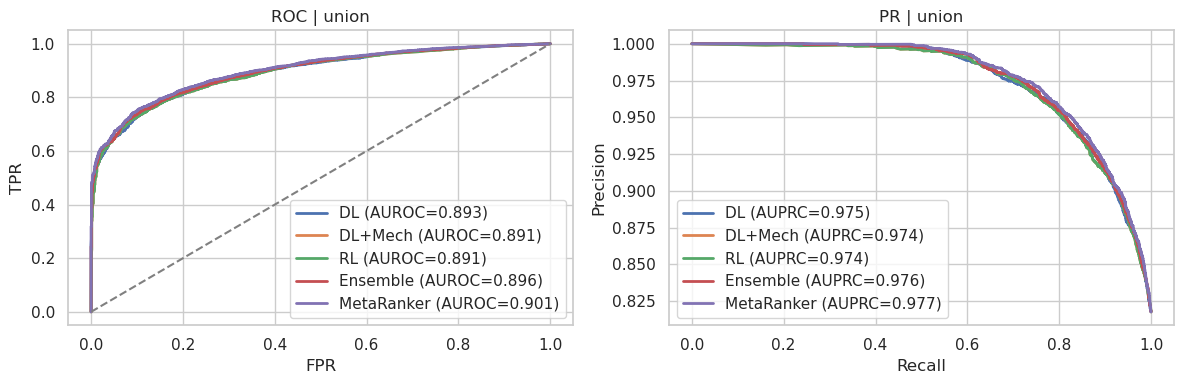

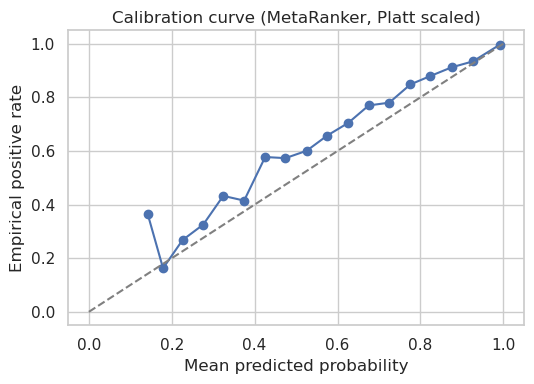

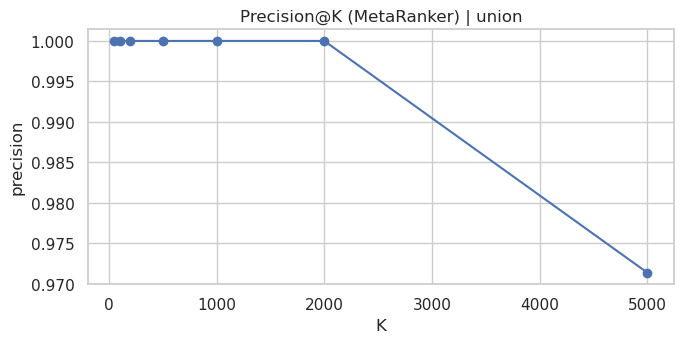

top_predictions.tsv: (5000, 8)


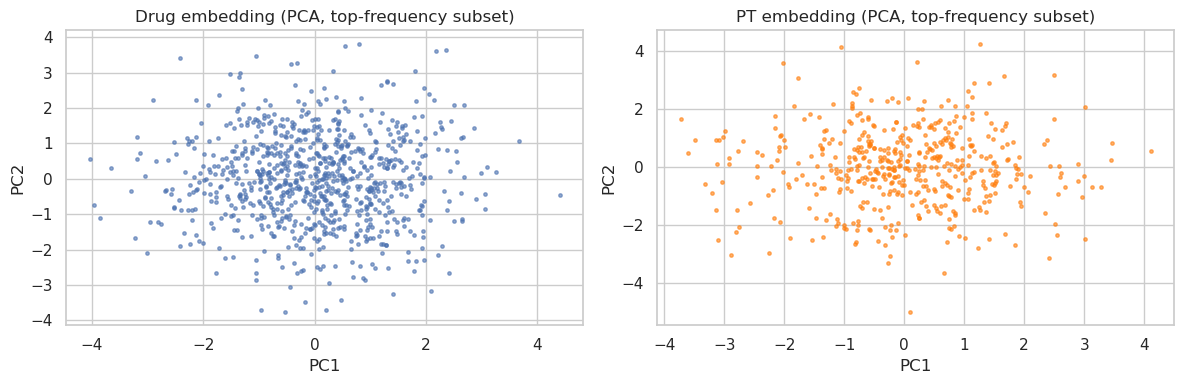

In [23]:
# --- C1) 结果读取与可视化：学习曲线、ROC/PR、Calibration、Embedding

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    average_precision_score,
    brier_score_loss,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)

sns.set_theme(style="whitegrid")

if not (OPENFDA_DL_OUT / "metrics.json").exists():
    raise FileNotFoundError(f"Missing DL outputs under: {OPENFDA_DL_OUT}")

dl_metrics = read_json(OPENFDA_DL_OUT / "metrics.json")
dl_hist = read_json(OPENFDA_DL_OUT / "history.json")
print(json.dumps(dl_metrics.get("test", {}), ensure_ascii=False, indent=2))

# 也展示 RL（若已有缓存模型），避免只看 DL 指标误判“完全不可用”
try:
    base_kind = str(OPENFDA_RL_BASE_MODEL).strip().lower()
    rl_dir = OPENFDA_RL_OUT_PLAIN if base_kind == "plain" else OPENFDA_RL_OUT_TOXCAST
    if (rl_dir / "metrics.json").exists():
        rl_m = read_json(rl_dir / "metrics.json")
        post = rl_m.get("post_test") or rl_m.get("test") or None
        if isinstance(post, dict) and post:
            print("[openFDA-RL]", json.dumps(post, ensure_ascii=False, indent=2))
except Exception:
    pass

# Learning curves（训练稳定性 + 是否“还在涨”）
hist_df = pd.DataFrame(dl_hist)
epochs = hist_df["epoch"].to_numpy(dtype=float)

fig, ax = plt.subplots(3, 1, figsize=(10, 8.8), sharex=True)

ax[0].plot(epochs, hist_df["train_loss"].to_numpy(dtype=float), marker="o", label="train_loss")
if "train_bce" in hist_df.columns:
    ax[0].plot(epochs, hist_df["train_bce"].to_numpy(dtype=float), marker="o", label="train_bce")
if "train_bpr" in hist_df.columns and float(np.nanmax(hist_df["train_bpr"].to_numpy(dtype=float))) > 0:
    ax[0].plot(epochs, hist_df["train_bpr"].to_numpy(dtype=float), marker="o", label="train_bpr")
ax[0].set_title("openFDA-DL: optimization")
ax[0].set_ylabel("loss")
ax[0].grid(True, alpha=0.3)
ax[0].legend()

ax[1].plot(epochs, hist_df["val_auprc"].to_numpy(dtype=float), marker="o", label="val_AUPRC")
ax[1].plot(epochs, hist_df["val_auroc"].to_numpy(dtype=float), marker="o", label="val_AUROC")
if "val_p@k" in hist_df.columns:
    ax[1].plot(
        epochs,
        hist_df["val_p@k"].to_numpy(dtype=float),
        marker="o",
        color="tab:orange",
        label=f"val_precision@{int(OPENFDA_EVAL_TOPK)}",
    )
ax[1].set_title("openFDA-DL: validation")
ax[1].set_ylabel("metric")
ax[1].grid(True, alpha=0.3)
ax[1].legend()

if "lr" in hist_df.columns:
    ax[2].plot(epochs, hist_df["lr"].to_numpy(dtype=float), marker="o", color="tab:gray")
ax[2].set_title("openFDA-DL: learning rate")
ax[2].set_xlabel("epoch")
ax[2].set_ylabel("lr")
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Eval arrays (for curves)

def _safe_auroc(y: np.ndarray, p: np.ndarray) -> float:
    y = y.astype(int)
    if y.size == 0 or np.unique(y).size < 2:
        return float("nan")
    return float(roc_auc_score(y, p))


def _safe_auprc(y: np.ndarray, p: np.ndarray) -> float:
    y = y.astype(int)
    if y.size == 0 or np.unique(y).size < 2:
        return float("nan")
    return float(average_precision_score(y, p))


def _p_at_k(y: np.ndarray, p: np.ndarray, k: int) -> float:
    y = y.astype(int)
    if y.size == 0:
        return float("nan")
    k = int(min(int(k), int(y.size)))
    if k <= 0:
        return float("nan")
    order = np.argsort(-p)[:k]
    return float(y[order].mean())


def _logit(p: np.ndarray) -> np.ndarray:
    eps = 1e-6
    pp = np.clip(p.astype(np.float64), eps, 1.0 - eps)
    return np.log(pp / (1.0 - pp)).astype(np.float32)


def _canon_name(name: str) -> str:
    return str(name).strip().lower().replace("+", "_").replace(" ", "_")



def _aligned(ref, cand) -> bool:
    if "keys" in ref and "keys" in cand and not np.array_equal(ref["keys"], cand["keys"]):
        return False
    if ref["y_true"].shape != cand["y_true"].shape:
        return False
    if not np.array_equal(ref["y_true"], cand["y_true"]):
        return False
    return True


def _summarize_probs(name: str, y: np.ndarray, p: np.ndarray, k: int) -> dict:
    base = float(y.mean()) if y.size else float("nan")
    return {
        "model": name,
        "n": int(y.size),
        "pos": int(y.sum()),
        "pos_rate": base,
        "auroc": _safe_auroc(y, p),
        "auprc": _safe_auprc(y, p),
        "brier": float(brier_score_loss(y, p)) if y.size else float("nan"),
        f"p@{int(k)}": _p_at_k(y, p, k),
    }


def fit_stacking_ensemble(*, models: list[str], val_arrays: dict[str, np.ndarray], test_probs: dict[str, np.ndarray]):
    if len(models) < 2:
        return None
    yv = None
    kv = None
    feats = []
    for m in models:
        z = val_arrays.get(m)
        if z is None:
            return None
        y = z["y_true"].astype(np.int8).reshape(-1)
        k = z["keys"].astype(np.int64).reshape(-1) if "keys" in z else None
        p = z["y_prob"].astype(np.float32).reshape(-1)
        if yv is None:
            yv = y
            kv = k
        else:
            if kv is not None and k is not None and not np.array_equal(kv, k):
                return None
            if y.shape != yv.shape or not np.array_equal(yv, y):
                return None
        feats.append(_logit(p))
    if yv is None:
        return None
    Xv = np.stack(feats, axis=1)
    clf = LogisticRegression(max_iter=2000, solver="lbfgs")
    clf.fit(Xv, yv.astype(int))
    Xt = np.stack([_logit(test_probs[m]) for m in models], axis=1)
    p_test = clf.predict_proba(Xt)[:, 1].astype(np.float32)
    p_val = clf.predict_proba(Xv)[:, 1].astype(np.float32)
    info = {
        "stack_intercept": float(clf.intercept_.reshape(-1)[0]),
        **{f"stack_coef_{m.lower().replace('+', '_').replace(' ', '_')}": float(c) for m, c in zip(models, clf.coef_.reshape(-1), strict=False)},
    }
    return p_test, p_val, info


def fit_platt(*, y_val: np.ndarray, p_val: np.ndarray, p_test: np.ndarray):
    Xv = _logit(p_val).reshape(-1, 1)
    clf = LogisticRegression(max_iter=2000, solver="lbfgs")
    clf.fit(Xv, y_val.astype(int))
    Xt = _logit(p_test).reshape(-1, 1)
    p_cal = clf.predict_proba(Xt)[:, 1].astype(np.float32)
    info = {
        "platt_intercept": float(clf.intercept_.reshape(-1)[0]),
        "platt_coef": float(clf.coef_.reshape(-1)[0]),
    }
    return p_cal, info


dl_test = np.load(OPENFDA_DL_OUT / "test_eval.npz")
y_true = dl_test["y_true"].astype(int)
y_prob = dl_test["y_prob"].astype(float)

subset_note = "union"
if str(OPENFDA_LABEL_MODE).strip().lower() == "emerging":
    subset_note = f"candidate(current_count<= {int(OPENFDA_MAX_CURRENT_COUNT)})"

k = int(OPENFDA_EVAL_TOPK)
models_test = {"DL": dl_test}
models_val = {}
if (OPENFDA_DL_OUT / "val_eval.npz").exists():
    models_val["DL"] = np.load(OPENFDA_DL_OUT / "val_eval.npz")

# mechanism-informed DL
_dl_tox_out = OPENFDA_DL_TOXCAST_OUT_DIFFUSED if TOXCAST_INCLUDE_DIFFUSED else OPENFDA_DL_TOXCAST_OUT
_tox_test = _dl_tox_out / "test_eval.npz"
_tox_val = _dl_tox_out / "val_eval.npz"
if _tox_test.exists():
    tox_test = np.load(_tox_test)
    if _aligned(dl_test, tox_test):
        models_test["DL+Mech"] = tox_test
    else:
        print("[openFDA] DL+Mech test eval not aligned; skip ensemble.")
if _tox_val.exists():
    models_val["DL+Mech"] = np.load(_tox_val)

# RL
base_kind = str(OPENFDA_RL_BASE_MODEL).strip().lower()
rl_dir = OPENFDA_RL_OUT_PLAIN if base_kind == "plain" else OPENFDA_RL_OUT_TOXCAST
rl_test_path = rl_dir / "test_eval_rl.npz"
rl_val_path = rl_dir / "val_eval_rl.npz"
if not rl_test_path.exists():
    alt = rl_dir / "test_eval.npz"
    if alt.exists():
        rl_test_path = alt
if not rl_val_path.exists():
    alt = rl_dir / "val_eval.npz"
    if alt.exists():
        rl_val_path = alt
if rl_test_path.exists():
    rl_test = np.load(rl_test_path)
    if _aligned(dl_test, rl_test):
        models_test["RL"] = rl_test
    else:
        print("[openFDA] RL test eval not aligned; skip ensemble.")
if rl_val_path.exists():
    models_val["RL"] = np.load(rl_val_path)

# Build test prob map
test_probs = {name: z["y_prob"].astype(np.float32) for name, z in models_test.items()}

# Optional stacking ensemble (fit on val, apply to test)
stack_models = [m for m in ["DL", "DL+Mech", "RL"] if m in test_probs and m in models_val]
val_preds = {name: (z["y_true"].astype(int), z["y_prob"].astype(np.float32)) for name, z in models_val.items()}
stack_info = {}
ens = fit_stacking_ensemble(models=stack_models, val_arrays=models_val, test_probs=test_probs)
if ens is not None:
    p_ens, p_val_ens, stack_info = ens
    test_probs["Ensemble"] = p_ens
    # use the first model's val y_true for calibration
    yv = models_val[stack_models[0]]["y_true"].astype(int) if stack_models else models_val["DL"]["y_true"].astype(int)
    val_preds["Ensemble"] = (yv, p_val_ens)

meta_ranker = None
if stack_models:
    base = stack_models[0]
    z_val = models_val.get(base)
    z_test = models_test.get(base)
    aligned = True
    for m in stack_models[1:]:
        if not _aligned(models_val[base], models_val[m]) or not _aligned(models_test[base], models_test[m]):
            aligned = False
            break
    if aligned and z_val is not None and z_test is not None and "a" in z_val and "a" in z_test:
        from scripts.train_openfda_early_warning_dl import _read_quarter_arrays, _read_quarter_n_reports  # type: ignore

        vocab = read_json(OPENFDA_DL_OUT / "vocab.json")
        keep_drugs = [str(x) for x in (vocab.get("drugs") or [])]
        keep_pts = [str(x) for x in (vocab.get("pts") or [])]
        drug_to_idx = {d: i for i, d in enumerate(keep_drugs)}
        pt_to_idx = {p: i for i, p in enumerate(keep_pts)}

        quarter_cache = {}
        pair_cache = {}

        def _quarter_pairs(q_from: str):
            q = str(q_from).strip().lower()
            if q in pair_cache:
                return pair_cache[q]
            _dr, _pr, pairs = _read_quarter_arrays(
                counts_dir=OPENFDA_COUNTS_DIR,
                quarter=q,
                drug_to_idx=drug_to_idx,
                pt_to_idx=pt_to_idx,
            )
            pair_cache[q] = pairs
            quarter_cache[q] = (
                _dr,
                _pr,
                float(_read_quarter_n_reports(OPENFDA_COUNTS_DIR, q)),
            )
            return pairs

        def _quarter_stats(q_from: str):
            q = str(q_from).strip().lower()
            if q in quarter_cache:
                return quarter_cache[q]
            _quarter_pairs(q)
            return quarter_cache[q]

        def _pair_numeric_features(z):
            q_from = str(z["q_from"][0]).strip().lower()
            keys = z["keys"].astype(np.int64)
            did = (keys >> 32).astype(np.int64)
            pid = (keys & 0xFFFFFFFF).astype(np.int64)
            a = z["a"].astype(np.float32)
            drug_reports, pt_reports, total_reports = _quarter_stats(q_from)

            drug_r = drug_reports[did]
            pt_r = pt_reports[pid]

            smoothing = 0.5
            b = np.clip(drug_r - a, a_min=0.0, a_max=None)
            c = np.clip(pt_r - a, a_min=0.0, a_max=None)
            d = np.clip(total_reports - a - b - c, a_min=0.0, a_max=None)
            ror = ((a + smoothing) * (d + smoothing)) / ((b + smoothing) * (c + smoothing))
            prr = ((a + smoothing) / np.clip(drug_r, a_min=1e-12, a_max=None)) / (
                (c + smoothing) / np.clip(total_reports - drug_r, a_min=1e-12, a_max=None)
            )
            expected = (drug_r * pt_r) / np.clip(total_reports, a_min=1e-12, a_max=None)
            ic = np.log2((a + smoothing) / (expected + smoothing))
            ic = np.clip(ic, a_min=-50.0, a_max=50.0)

            return {
                "log1p_a": np.log1p(a),
                "log1p_drug_reports": np.log1p(drug_r),
                "log1p_pt_reports": np.log1p(pt_r),
                "log1p_total_reports": np.log1p(np.full_like(a, total_reports, dtype=np.float32)),
                "log_ror": np.log(np.clip(ror, a_min=1e-12, a_max=None)),
                "log_prr": np.log(np.clip(prr, a_min=1e-12, a_max=None)),
                "ic": ic.astype(np.float32),
            }

        def _pair_history_features(z):
            lag = int(OPENFDA_DL_PAIR_HISTORY_LAGS)
            if lag <= 0:
                return {}
            q_from = str(z["q_from"][0]).strip().lower()
            quarters = list(OPENFDA_QUARTERS)
            q_pos = {q: i for i, q in enumerate(quarters)}
            pos = q_pos.get(q_from)
            if pos is None:
                return {}
            keys = z["keys"].astype(np.int64)
            a_hist = np.zeros((int(keys.shape[0]), int(lag)), dtype=np.float32)
            for j in range(1, int(lag) + 1):
                idx = int(pos) - int(j)
                if idx < 0:
                    continue
                qh = quarters[idx]
                pairs_h = _quarter_pairs(qh)
                a_hist[:, j - 1] = np.fromiter((float(pairs_h.get(int(k), 0.0)) for k in keys), dtype=np.float32)

            out = {
                "log1p_hist_sum": np.log1p(a_hist.sum(axis=1)),
                "log1p_hist_max": np.log1p(a_hist.max(axis=1)),
                "log1p_hist_last": np.log1p(a_hist[:, 0]),
            }
            if int(lag) > 1:
                out["hist_trend"] = a_hist[:, 0] - a_hist[:, 1]
            else:
                out["hist_trend"] = np.zeros((int(keys.shape[0]),), dtype=np.float32)
            return out

        yv = z_val["y_true"].astype(int)
        feat_val = _pair_numeric_features(z_val)
        feat_test = _pair_numeric_features(z_test)
        hist_val = _pair_history_features(z_val)
        hist_test = _pair_history_features(z_test)

        feat_val_all = {**feat_val, **hist_val}
        feat_test_all = {**feat_test, **hist_test}
        extra_features = list(feat_val_all.keys())
        Xv = np.stack([_logit(models_val[m]["y_prob"].astype(np.float32)) for m in stack_models] + [feat_val_all[k] for k in extra_features], axis=1)
        Xt = np.stack([_logit(models_test[m]["y_prob"].astype(np.float32)) for m in stack_models] + [feat_test_all[k] for k in extra_features], axis=1)

        scaler = StandardScaler()
        Xv_s = scaler.fit_transform(Xv)
        Xt_s = scaler.transform(Xt)
        clf = LogisticRegression(max_iter=4000, solver="lbfgs", class_weight="balanced")
        clf.fit(Xv_s, yv)
        p_meta = clf.predict_proba(Xt_s)[:, 1].astype(np.float32)
        p_meta_val = clf.predict_proba(Xv_s)[:, 1].astype(np.float32)
        platt = LogisticRegression(max_iter=2000, solver="lbfgs")
        platt.fit(_logit(p_meta_val).reshape(-1, 1), yv)
        p_meta = platt.predict_proba(_logit(p_meta).reshape(-1, 1))[:, 1].astype(np.float32)
        p_meta_val = platt.predict_proba(_logit(p_meta_val).reshape(-1, 1))[:, 1].astype(np.float32)
        test_probs["MetaRanker"] = p_meta
        val_preds["MetaRanker"] = (yv, p_meta_val)
        feature_names = [f"logit_{_canon_name(m)}" for m in stack_models] + extra_features
        meta_ranker = {
            "models": list(stack_models),
            "feature_names": feature_names,
            "coef": clf.coef_.reshape(-1).astype(float).tolist(),
            "intercept": float(clf.intercept_.reshape(-1)[0]),
            "mean": scaler.mean_.astype(float).tolist(),
            "scale": scaler.scale_.astype(float).tolist(),
            "platt_intercept": float(platt.intercept_.reshape(-1)[0]),
            "platt_coef": float(platt.coef_.reshape(-1)[0]),
        }
        meta_path = Path("data/outputs/openfda_meta_ranker.json")
        meta_path.parent.mkdir(parents=True, exist_ok=True)
        meta_path.write_text(json.dumps(meta_ranker, ensure_ascii=False, indent=2), encoding="utf-8")

        np.savez(
            Path("data/outputs/openfda_meta_ranker_eval.npz"),
            y_true=z_test["y_true"].astype(np.int8),
            y_prob=p_meta.astype(np.float32),
            keys=z_test["keys"].astype(np.int64),
            q_from=z_test["q_from"],
            q_to=z_test["q_to"],
        )
        np.savez(
            Path("data/outputs/openfda_meta_ranker_val.npz"),
            y_true=z_val["y_true"].astype(np.int8),
            y_prob=p_meta_val.astype(np.float32),
            keys=z_val["keys"].astype(np.int64),
            q_from=z_val["q_from"],
            q_to=z_val["q_to"],
        )

rows = []
for name, z in models_test.items():
    rows.append(_summarize_probs(name, z["y_true"].astype(int), z["y_prob"].astype(float), k))
for extra in ["Ensemble", "MetaRanker"]:
    if extra in test_probs:
        rows.append(_summarize_probs(extra, y_true, test_probs[extra], k))
if rows:
    metrics_df = pd.DataFrame(rows).sort_values("auprc", ascending=False).reset_index(drop=True)
    display(metrics_df)
else:
    metrics_df = pd.DataFrame()

plot_name = metrics_df["model"].iloc[0] if not metrics_df.empty else "DL"
plot_prob = test_probs.get(plot_name, y_prob)

auroc = _safe_auroc(y_true, plot_prob)
auprc = _safe_auprc(y_true, plot_prob)
brier = float(brier_score_loss(y_true, plot_prob)) if y_true.size else float("nan")

pos_rate = float(y_true.mean()) if y_true.size > 0 else float("nan")
auprc_base = pos_rate
auprc_lift = (
    (auprc / auprc_base)
    if np.isfinite(auprc) and np.isfinite(auprc_base) and float(auprc_base) > 0
    else float("nan")
)

print(
    f"[{plot_name}] Test AUROC={auroc:.4f} | AUPRC={auprc:.4f} (base={auprc_base:.4f}, lift={auprc_lift:.2f}x) | "
    f"Brier={brier:.4f} | n={y_true.size} pos={int(y_true.sum())} pos_rate={pos_rate:.4f} | {subset_note}"
)

# ROC/PR curves (all aligned models)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for name, p in test_probs.items():
    fpr, tpr, _ = roc_curve(y_true, p)
    auroc_m = _safe_auroc(y_true, p)
    ax[0].plot(fpr, tpr, lw=2, label=f"{name} (AUROC={auroc_m:.3f})")
ax[0].plot([0, 1], [0, 1], linestyle="--", color="gray")
ax[0].set_title(f"ROC | {subset_note}")
ax[0].set_xlabel("FPR")
ax[0].set_ylabel("TPR")
ax[0].legend()

for name, p in test_probs.items():
    prec, rec, _ = precision_recall_curve(y_true, p)
    auprc_m = _safe_auprc(y_true, p)
    ax[1].plot(rec, prec, lw=2, label=f"{name} (AUPRC={auprc_m:.3f})")
ax[1].set_title(f"PR | {subset_note}")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].legend()

plt.tight_layout()
plt.show()

# Calibration (reliability) for the best model (Platt-scaled if val split exists)
plot_prob_cal = plot_prob
if plot_name in val_preds:
    yv, pv = val_preds[plot_name]
    plot_prob_cal, _ = fit_platt(y_val=yv, p_val=pv, p_test=plot_prob)

frac_pos, mean_pred = calibration_curve(y_true, plot_prob_cal, n_bins=20, strategy="uniform")
plt.figure(figsize=(5.5, 4))
plt.plot(mean_pred, frac_pos, marker="o")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title(f"Calibration curve ({plot_name}, Platt scaled)")
plt.xlabel("Mean predicted probability")
plt.ylabel("Empirical positive rate")
plt.tight_layout()
plt.show()

# Precision@K curve (ranking objective) for the best model
ks = [50, 100, 200, 500, 1000, 2000, 5000]
ks = [k for k in ks if k <= y_true.size]
order = np.argsort(-plot_prob)
prec_at = []
for kk in ks:
    prec_at.append(float(y_true[order[:kk]].mean()))

plt.figure(figsize=(7, 3.6))
plt.plot(ks, prec_at, marker="o")
plt.title(f"Precision@K ({plot_name}) | {subset_note}")
plt.xlabel("K")
plt.ylabel("precision")
plt.tight_layout()
plt.show()

# Top predictions (case studies)
top_pred = pd.read_csv(OPENFDA_DL_OUT / "top_predictions.tsv", sep="	")
print("top_predictions.tsv:", top_pred.shape)
top_pred.head(20)

# Embedding visualization (PCA on a subset)
vocab = read_json(OPENFDA_DL_OUT / "vocab.json")
emb = np.load(OPENFDA_DL_OUT / "embeddings.npz")

drug_list = [str(x) for x in vocab.get("drugs") or []]
pt_list = [str(x) for x in vocab.get("pts") or []]

drug_to_i = {d: i for i, d in enumerate(drug_list)}
pt_to_i = {p: i for i, p in enumerate(pt_list)}

drug_emb = emb["drug_emb"].astype(np.float32)
pt_emb = emb["pt_emb"].astype(np.float32)

# 以全局频次最高的一部分点做可视化（避免在 3–4 万点上做非线性降维导致运行过久）
show_n = 2000
sel_drugs = [d for d in drug_sum.sort_values(ascending=False).head(show_n).index.tolist() if d in drug_to_i]
sel_pts = [p for p in pt_sum.sort_values(ascending=False).head(show_n).index.tolist() if p in pt_to_i]

Xd = drug_emb[[drug_to_i[d] for d in sel_drugs]]
Xp = pt_emb[[pt_to_i[p] for p in sel_pts]]

Zd = PCA(n_components=2, random_state=int(SEED)).fit_transform(Xd)
Zp = PCA(n_components=2, random_state=int(SEED)).fit_transform(Xp)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(Zd[:, 0], Zd[:, 1], s=6, alpha=0.6)
ax[0].set_title("Drug embedding (PCA, top-frequency subset)")
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")

ax[1].scatter(Zp[:, 0], Zp[:, 1], s=6, alpha=0.6, color="tab:orange")
ax[1].set_title("PT embedding (PCA, top-frequency subset)")
ax[1].set_xlabel("PC1")
ax[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()


In [24]:
# --- C6.5) Calibrate MetaRanker (temperature scaling)
cmd = [PY, "scripts/calibrate_openfda_meta_ranker.py", "--method", "temperature"]
run(cmd)



$ /home/xuchengjie/miniconda3/envs/toxcast-risk/bin/python scripts/calibrate_openfda_meta_ranker.py --method temperature
[MetaRanker calibration] selected: temperature
val: {'auprc': 0.9726302032294045, 'brier': 0.1020457521208554}
test: {'auprc': 0.9771249195121618, 'brier': 0.09768941363323642}


### C2) Mechanism-informed（DL）：加入 ToxCast/CTX 机制特征

在深度模型的基础上，我们将 drug-level 的机制特征并入输入：

- 风险回归输出（hazard / exposure / risk）
- 多标签靶点概率（gene-level targets）
- （可选）基于 invitroDB 注释构建基因网络后的扩散/平滑靶点表征

该设置回答两个问题：
1) 机制特征是否能提升对未来季度信号增长的识别能力？
2) 在高风险信号的排序结果中，哪些机制维度更重要（后续可解释性分析）？


In [25]:
# --- C2) 训练机制增强深度模型（toxcast features）

dl_tox_out = OPENFDA_DL_TOXCAST_OUT_DIFFUSED if TOXCAST_INCLUDE_DIFFUSED else OPENFDA_DL_TOXCAST_OUT

if not bool(RUN_OPENFDA_DL_TOXCAST):
    print("RUN_OPENFDA_DL_TOXCAST=False; skip training.")
else:
    required = [dl_tox_out / "metrics.json", dl_tox_out / "model.pt", dl_tox_out / "vocab.json"]
    dl_tox_ready = all(p.exists() for p in required)

    # 若上游 toxcast bundle 的 gene 集合发生变化，则需要重训（保证特征列一致）
    if dl_tox_ready:
        try:
            m = read_json(dl_tox_out / "metrics.json")
            feat_cols = list(m.get("toxcast_feature_cols") or [])
            expected_prob_cols = [f"tox_prob_{g}" for g in genes]
            missing = [c for c in expected_prob_cols if c not in feat_cols]
            if missing:
                print("[openFDA-DL] ToxCast gene set mismatch; will retrain.")
                print("Missing columns (head):", missing[:5], f"(total={len(missing)})")
                dl_tox_ready = False
            has_diffused = any(str(c).startswith("tox_prob_diff_") for c in feat_cols)
            if bool(has_diffused) != bool(TOXCAST_INCLUDE_DIFFUSED):
                print("[openFDA-DL] include_diffused mismatch; will retrain.")
                dl_tox_ready = False
        except Exception as e:  # noqa: BLE001
            print("[openFDA-DL] Failed to validate existing metrics; will retrain.")
            print("Reason:", type(e).__name__, str(e))
            dl_tox_ready = False

    if not dl_tox_ready:
        cmd = [
            PY,
            "scripts/train_openfda_early_warning_dl.py",
            "--counts-dir",
            str(OPENFDA_COUNTS_DIR),
            "--start-quarter",
            str(OPENFDA_MODEL_START_QUARTER),
            "--end-quarter",
            str(OPENFDA_MODEL_END_QUARTER),
            "--min-next-count",
            str(int(OPENFDA_MIN_NEXT_COUNT)),
            "--label-mode",
            str(OPENFDA_LABEL_MODE),
            "--top-drugs",
            str(int(OPENFDA_TOP_DRUGS)),
            "--top-pts",
            str(int(OPENFDA_TOP_PTS)),
            "--seed",
            str(int(SEED)),
            "--epochs",
            str(int(OPENFDA_DL_EPOCHS)),
            "--steps-per-transition",
            str(int(OPENFDA_DL_STEPS_PER_TRANSITION)),
            "--batch-size",
            str(int(OPENFDA_DL_BATCH_SIZE)),
            "--pos-fraction",
            str(float(OPENFDA_DL_POS_FRACTION)),
            "--pair-history-lags",
            str(int(OPENFDA_DL_PAIR_HISTORY_LAGS)),
            "--emb-dim",
            str(int(OPENFDA_DL_EMB_DIM)),
            "--hidden-dim",
            str(int(OPENFDA_DL_HIDDEN_DIM)),
            "--dropout",
            str(float(OPENFDA_DL_DROPOUT)),
            "--lr",
            str(float(OPENFDA_DL_LR)),
            "--weight-decay",
            str(float(OPENFDA_DL_WEIGHT_DECAY)),
            "--select-metric",
            str(OPENFDA_DL_SELECT_METRIC),
            "--early-stop-patience",
            str(int(OPENFDA_DL_EARLY_STOP_PATIENCE)),
            "--early-stop-min-delta",
            str(float(OPENFDA_DL_EARLY_STOP_MIN_DELTA)),
            "--device",
            DEVICE,
            "--topk",
            str(int(OPENFDA_EVAL_TOPK)),
            "--use-toxcast",
            "--toxcast-bundle-dir",
            str(BUNDLE_DIR),
            "--toxcast-device",
            DEVICE,
            "--toxcast-mc-samples",
            str(int(OPENFDA_TOXCAST_MC_SAMPLES)),
            "--out-dir",
            str(dl_tox_out),
            "--save-eval-npz",
            "--save-embeddings-npz",
        ]
        if bool(OPENFDA_DL_EMB_INTERACTIONS):
            cmd.append("--emb-interactions")
        cmd += [
            "--lr-schedule",
            str(OPENFDA_DL_LR_SCHEDULE),
            "--lr-min-factor",
            str(float(OPENFDA_DL_LR_MIN_FACTOR)),
            "--plateau-factor",
            str(float(OPENFDA_DL_PLATEAU_FACTOR)),
            "--plateau-patience",
            str(int(OPENFDA_DL_PLATEAU_PATIENCE)),
            "--loss",
            str(OPENFDA_DL_LOSS),
            "--bpr-weight",
            str(float(OPENFDA_DL_BPR_WEIGHT)),
            "--bpr-max-pairs",
            str(int(OPENFDA_DL_BPR_MAX_PAIRS)),
        ]
        if str(OPENFDA_LABEL_MODE).strip().lower() == "emerging":
            cmd += ["--max-current-count", str(int(OPENFDA_MAX_CURRENT_COUNT))]
        if OPENFDA_TRAIN_LAST_N_TRANSITIONS is not None:
            cmd += ["--train-last-n-transitions", str(int(OPENFDA_TRAIN_LAST_N_TRANSITIONS))]
        if not bool(OPENFDA_DL_AMP):
            cmd.append("--no-amp")
        if OPENFDA_EVAL_MAX_PAIRS is not None:
            cmd += ["--eval-max-pairs", str(int(OPENFDA_EVAL_MAX_PAIRS))]
        if TOXCAST_INCLUDE_DIFFUSED:
            cmd.append("--toxcast-include-diffused")
        run(cmd)
    else:
        print("Found existing openFDA toxcast DL model, skip training:", dl_tox_out)


RUN_OPENFDA_DL_TOXCAST=False; skip training.


In [26]:
# --- C2) 结果对比：plain DL vs mechanism-informed DL

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)

sns.set_theme(style="whitegrid")

dl_tox_out = OPENFDA_DL_TOXCAST_OUT_DIFFUSED if TOXCAST_INCLUDE_DIFFUSED else OPENFDA_DL_TOXCAST_OUT

if not (dl_tox_out / "metrics.json").exists():
    print("Missing toxcast model outputs under:", dl_tox_out)
    print("Tip: set JHM_RUN_OPENFDA_DL_TOXCAST=1 to enable, or run section C2 training first.")
else:
    plain = read_json(OPENFDA_DL_OUT / "metrics.json")
    tox = read_json(dl_tox_out / "metrics.json")

    plain_test = plain.get("test", {})
    tox_test = tox.get("test", {})

    rows = []
    for name, m in [("DL", plain_test), ("DL+ToxCast" + ("+diffused" if TOXCAST_INCLUDE_DIFFUSED else ""), tox_test)]:
        rows.append(
            {
                "model": name,
                "auroc": float(m.get("auroc", np.nan)),
                "auprc": float(m.get("auprc", np.nan)),
                f"p@{int(OPENFDA_EVAL_TOPK)}": float(m.get(f"p@{int(OPENFDA_EVAL_TOPK)}", np.nan)),
                "brier": float(m.get("brier", np.nan)),
            }
        )

    cmp = pd.DataFrame(rows)
    display(cmp)

    # PR/ROC curves
    plain_eval = np.load(OPENFDA_DL_OUT / "test_eval.npz")
    tox_eval = np.load(dl_tox_out / "test_eval.npz")

    def pr_curve(arr):
        y = arr["y_true"].astype(int)
        p = arr["y_prob"].astype(float)
        ap = float(average_precision_score(y, p)) if len(np.unique(y)) > 1 else float("nan")
        prec, rec, _ = precision_recall_curve(y, p)
        return rec, prec, ap

    def roc_curve_xy(arr):
        y = arr["y_true"].astype(int)
        p = arr["y_prob"].astype(float)
        auroc = float(roc_auc_score(y, p)) if len(np.unique(y)) > 1 else float("nan")
        fpr, tpr, _ = roc_curve(y, p)
        return fpr, tpr, auroc

    r1, p1, ap1 = pr_curve(plain_eval)
    r2, p2, ap2 = pr_curve(tox_eval)

    f1, t1, auc1 = roc_curve_xy(plain_eval)
    f2, t2, auc2 = roc_curve_xy(tox_eval)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(r1, p1, label=f"DL (AP={ap1:.3f})")
    ax[0].plot(r2, p2, label=f"DL+ToxCast (AP={ap2:.3f})")
    ax[0].set_title("PR curve (test)")
    ax[0].set_xlabel("Recall")
    ax[0].set_ylabel("Precision")
    ax[0].legend()

    ax[1].plot(f1, t1, label=f"DL (AUROC={auc1:.3f})")
    ax[1].plot(f2, t2, label=f"DL+ToxCast (AUROC={auc2:.3f})")
    ax[1].plot([0, 1], [0, 1], linestyle="--", color="gray")
    ax[1].set_title("ROC curve (test)")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    # toxcast feature mapping rate (how many drugs have tox_available=1)
    feat_path = dl_tox_out / ("drug_toxcast_features_diffused.tsv" if TOXCAST_INCLUDE_DIFFUSED else "drug_toxcast_features.tsv")
    if feat_path.exists():
        tox_feat = pd.read_csv(feat_path, sep="\t")
        if "tox_available" in tox_feat.columns:
            mapped = int((tox_feat["tox_available"].astype(float) > 0).sum())
            print(f"toxcast-mapped drugs: {mapped}/{tox_feat.shape[0]} ({mapped/tox_feat.shape[0]:.1%})")


model     auroc     auprc  p@200     brier
0          DL  0.892673  0.975019    1.0  0.149551
1  DL+ToxCast  0.891064  0.974300    1.0  0.153319

toxcast-mapped drugs: 1906/5000 (38.1%)


### C3) 强化学习微调（REINFORCE）：直接优化 `precision@K`

在药物警戒场景中，模型的输出通常以“**排序列表**”的形式被消费：
我们更关心 top-K 候选信号里有多少是真阳性，而不仅仅是全量样本上的概率校准。

因此，本节在深度模型基础上进行策略梯度微调：
- **动作**：从候选集合中采样一组 top-K（无放回）
- **奖励**：该 top-K 的平均真阳性比例（precision@K）
- **目标**：最大化期望奖励，同时加入熵正则避免过早塌缩

该设计的优点是：训练目标与最终使用指标一致，可作为方法学亮点与创新点。


In [27]:
# --- C3) 运行 RL fine-tuning（基于 DL checkpoint）

# 可选：让 GPU 负载更明显（会显著增加训练成本）
GPU_HEAVY = False
if GPU_HEAVY and DEVICE == "cuda":
    OPENFDA_RL_MAX_CANDIDATES = max(int(OPENFDA_RL_MAX_CANDIDATES), 40000)
    OPENFDA_RL_NEG_CANDIDATES = max(int(OPENFDA_RL_NEG_CANDIDATES), 25000)
    OPENFDA_RL_EPISODES_PER_TRANSITION = max(int(OPENFDA_RL_EPISODES_PER_TRANSITION), 6)
    OPENFDA_RL_BATCH_SIZE = max(int(OPENFDA_RL_BATCH_SIZE), 16384)
    print(
        "[GPU heavy] max_candidates=", OPENFDA_RL_MAX_CANDIDATES,
        "neg_candidates=", OPENFDA_RL_NEG_CANDIDATES,
        "episodes=", OPENFDA_RL_EPISODES_PER_TRANSITION,
        "batch_size=", OPENFDA_RL_BATCH_SIZE,
    )

# 进度打印：每 N 个 transition 打印一次（0 关闭）
OPENFDA_RL_LOG_EVERY_TRANSITIONS = int(os.getenv("JHM_OPENFDA_RL_LOG_EVERY_TRANSITIONS", "1"))
# CPU 并行：构建候选集时的并行 worker 数（0 关闭）
OPENFDA_RL_CPU_WORKERS = max(12, int(os.getenv("JHM_OPENFDA_RL_CPU_WORKERS", "12")))
# 训练最长 walltime（分钟），0 表示不限制
OPENFDA_RL_MAX_WALLTIME_MIN = int(os.getenv("JHM_OPENFDA_RL_MAX_WALLTIME_MIN", "0"))

if not bool(RUN_OPENFDA_RL):
    print("RUN_OPENFDA_RL=False; skip RL fine-tuning.")
else:
    dl_tox_out = OPENFDA_DL_TOXCAST_OUT_DIFFUSED if TOXCAST_INCLUDE_DIFFUSED else OPENFDA_DL_TOXCAST_OUT

    base_kind = str(OPENFDA_RL_BASE_MODEL).strip().lower()
    if base_kind not in {"plain", "toxcast"}:
        raise ValueError(f"OPENFDA_RL_BASE_MODEL must be 'plain' or 'toxcast', got: {OPENFDA_RL_BASE_MODEL!r}")

    base_model_dir = OPENFDA_DL_OUT if base_kind == "plain" else dl_tox_out
    out_dir = OPENFDA_RL_OUT_PLAIN if base_kind == "plain" else OPENFDA_RL_OUT_TOXCAST

    required = [out_dir / "metrics.json", out_dir / "model_rl.pt"]
    rl_ready = all(p.exists() for p in required)

    if rl_ready and not FORCE_REBUILD_OPENFDA_RL:
        try:
            m = read_json(out_dir / "metrics.json")
            expected = {
                "topk": int(OPENFDA_RL_TOPK),
                "min_next_count": int(OPENFDA_MIN_NEXT_COUNT),
                "label_mode": str(OPENFDA_LABEL_MODE).strip().lower(),
                "max_current_count": (
                    int(OPENFDA_MAX_CURRENT_COUNT) if str(OPENFDA_LABEL_MODE).strip().lower() == "emerging" else None
                ),
                "pair_history_lags": int(OPENFDA_DL_PAIR_HISTORY_LAGS),
                "seed": int(OPENFDA_RL_SEED),
                "min_drug_reports": int(OPENFDA_MIN_DRUG_REPORTS),
                "min_pt_reports": int(OPENFDA_MIN_PT_REPORTS),
                "neg_candidates": int(OPENFDA_RL_NEG_CANDIDATES),
                "episodes_per_transition": int(OPENFDA_RL_EPISODES_PER_TRANSITION),
                "epochs": int(OPENFDA_RL_EPOCHS),
                "train_last_n_transitions": OPENFDA_RL_TRAIN_LAST_N_TRANSITIONS,
                "lr": float(OPENFDA_RL_LR),
                "weight_decay": 0.0,
                "temperature": float(OPENFDA_RL_TEMPERATURE),
                "entropy_beta": float(OPENFDA_RL_ENTROPY_BETA),
                "batch_size": int(OPENFDA_RL_BATCH_SIZE),
                "max_candidates": int(OPENFDA_RL_MAX_CANDIDATES),
                "max_pos": OPENFDA_RL_MAX_POS,
                "amp": bool(OPENFDA_RL_AMP),
                "eval_max_pairs": OPENFDA_EVAL_MAX_PAIRS,
                "early_stop_patience": int(OPENFDA_RL_EARLY_STOP_PATIENCE),
                "early_stop_min_delta": float(OPENFDA_RL_EARLY_STOP_MIN_DELTA),
            }
            missing = [k for k in expected.keys() if k not in m]
            if missing:
                print("[openFDA-RL] metrics.json missing keys (old run); skip strict check:", missing)
            mismatch = {k: (m.get(k), v) for k, v in expected.items() if (k in m and m.get(k) != v)}
            if mismatch:
                print("[openFDA-RL] metrics.json mismatch; will re-run RL fine-tuning.")
                print("mismatch:", mismatch)
                rl_ready = False
        except Exception as e:  # noqa: BLE001
            print("[openFDA-RL] Failed to validate metrics.json; will re-run RL fine-tuning.")
            print("Reason:", type(e).__name__, str(e))
            rl_ready = False

    if FORCE_REBUILD_OPENFDA_RL or not rl_ready:
        cmd = [
            PY,
            "scripts/finetune_openfda_policy_rl.py",
            "--counts-dir",
            str(OPENFDA_COUNTS_DIR),
            "--seed",
            str(int(OPENFDA_RL_SEED)),
            "--min-next-count",
            str(int(OPENFDA_MIN_NEXT_COUNT)),
            "--min-drug-reports",
            str(int(OPENFDA_MIN_DRUG_REPORTS)),
            "--min-pt-reports",
            str(int(OPENFDA_MIN_PT_REPORTS)),
            "--model-dir",
            str(base_model_dir),
            "--out-dir",
            str(out_dir),
            "--device",
            DEVICE,
            "--topk",
            str(int(OPENFDA_RL_TOPK)),
            "--neg-candidates",
            str(int(OPENFDA_RL_NEG_CANDIDATES)),
            "--episodes-per-transition",
            str(int(OPENFDA_RL_EPISODES_PER_TRANSITION)),
            "--epochs",
            str(int(OPENFDA_RL_EPOCHS)),
            "--early-stop-patience",
            str(int(OPENFDA_RL_EARLY_STOP_PATIENCE)),
            "--early-stop-min-delta",
            str(float(OPENFDA_RL_EARLY_STOP_MIN_DELTA)),
            "--lr",
            str(float(OPENFDA_RL_LR)),
            "--temperature",
            str(float(OPENFDA_RL_TEMPERATURE)),
            "--entropy-beta",
            str(float(OPENFDA_RL_ENTROPY_BETA)),
            "--batch-size",
            str(int(OPENFDA_RL_BATCH_SIZE)),
            "--max-candidates",
            str(int(OPENFDA_RL_MAX_CANDIDATES)),
        ]
        if OPENFDA_RL_TRAIN_LAST_N_TRANSITIONS is not None:
            cmd += ["--train-last-n-transitions", str(int(OPENFDA_RL_TRAIN_LAST_N_TRANSITIONS))]
        if str(OPENFDA_LABEL_MODE).strip().lower() == "emerging":
            cmd += ["--max-current-count", str(int(OPENFDA_MAX_CURRENT_COUNT))]
        if OPENFDA_RL_MAX_POS is not None:
            cmd += ["--max-pos", str(int(OPENFDA_RL_MAX_POS))]
        if not bool(OPENFDA_RL_AMP):
            cmd.append("--no-amp")
        if int(OPENFDA_RL_LOG_EVERY_TRANSITIONS) > 0:
            cmd += ["--log-every-transitions", str(int(OPENFDA_RL_LOG_EVERY_TRANSITIONS))]
        if int(OPENFDA_RL_CPU_WORKERS) > 0:
            cmd += ["--cpu-workers", str(int(OPENFDA_RL_CPU_WORKERS))]
        if int(OPENFDA_RL_MAX_WALLTIME_MIN) > 0:
            cmd += ["--max-walltime-min", str(int(OPENFDA_RL_MAX_WALLTIME_MIN))]
        cmd += [
            "--save-eval-npz",
            "--top-predictions-n",
            "5000",
        ]
        if OPENFDA_EVAL_MAX_PAIRS is not None:
            cmd += ["--eval-max-pairs", str(int(OPENFDA_EVAL_MAX_PAIRS))]
        run(cmd)
    else:
        print("Found existing RL model, skip fine-tuning:", out_dir)


Found existing RL model, skip fine-tuning: data/models/openfda_policy_rl_toxcast_2020q4_2025q3_threshold_next1_hist4_embint1_bce_bpr_trainlast8


In [28]:
# --- C3) RL 结果读取与可视化：reward 曲线、precision@K 改善、top predictions

if not bool(RUN_OPENFDA_RL):
    print("RUN_OPENFDA_RL=False; skip RL analysis.")
else:
    # --- C3) RL 结果读取与可视化：reward 曲线、precision@K 改善、top predictions

    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set_theme(style="whitegrid")

    dl_tox_out = OPENFDA_DL_TOXCAST_OUT_DIFFUSED if TOXCAST_INCLUDE_DIFFUSED else OPENFDA_DL_TOXCAST_OUT
    base_kind = str(OPENFDA_RL_BASE_MODEL).strip().lower()
    base_model_dir = OPENFDA_DL_OUT if base_kind == "plain" else dl_tox_out
    out_dir = OPENFDA_RL_OUT_PLAIN if base_kind == "plain" else OPENFDA_RL_OUT_TOXCAST

    rl_metrics = read_json(out_dir / "metrics.json")
    rl_hist = read_json(out_dir / "history.json")

    print("pre_val:")
    print(json.dumps(rl_metrics.get("pre_val", {}), ensure_ascii=False, indent=2))
    print("post_val:")
    print(json.dumps(rl_metrics.get("post_val", {}), ensure_ascii=False, indent=2))
    print("post_test:")
    print(json.dumps(rl_metrics.get("post_test", {}), ensure_ascii=False, indent=2))

    hist_df = pd.DataFrame(rl_hist)
    pre_p = float(rl_metrics.get("pre_val", {}).get(f"p@{int(OPENFDA_RL_TOPK)}", float("nan")))
    post_p = float(rl_metrics.get("post_val", {}).get(f"p@{int(OPENFDA_RL_TOPK)}", float("nan")))
    skip_rl_plots = len(hist_df) <= 1 or (not np.isnan(pre_p) and not np.isnan(post_p) and pre_p >= post_p)
    if skip_rl_plots:
        print("[RL] Skip curves: p@K saturated or no improvement.")
    else:
        fig, ax = plt.subplots(2, 2, figsize=(12, 7.2), sharex=True)
        ax00, ax01 = ax[0, 0], ax[0, 1]
        ax10, ax11 = ax[1, 0], ax[1, 1]

        ax00.plot(hist_df["epoch"], hist_df["train_reward_mean"], marker="o")
        ax00.set_title("RL: mean reward (train)")
        ax00.set_ylabel("reward (precision@K)")

        if "train_loss_mean" in hist_df.columns:
            ax01.plot(hist_df["epoch"], hist_df["train_loss_mean"], marker="o", color="tab:gray")
            ax01.set_title("RL: mean policy loss (train)")
            ax01.set_ylabel("loss")

        ax10.plot(hist_df["epoch"], hist_df[f"val_p@{int(OPENFDA_RL_TOPK)}"], marker="o", color="tab:orange")
        ax10.set_title(f"RL: val precision@{int(OPENFDA_RL_TOPK)}")
        ax10.set_xlabel("epoch")
        ax10.set_ylabel("precision")

        if "val_auprc" in hist_df.columns:
            ax11.plot(hist_df["epoch"], hist_df["val_auprc"], marker="o", color="tab:purple")
            ax11.set_title("RL: val AUPRC")
            ax11.set_xlabel("epoch")
            ax11.set_ylabel("AUPRC")

        for a in [ax00, ax01, ax10, ax11]:
            a.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    # Top predictions from RL model (test transition)
    rl_top_path = out_dir / "top_predictions_rl.tsv"
    if rl_top_path.exists():
        rl_top = pd.read_csv(rl_top_path, sep="	")
        print("top_predictions_rl.tsv:", rl_top.shape)
        rl_top.head(20)
    else:
        print("No top_predictions_rl.tsv found under:", out_dir)


pre_val:
{
  "q_from": "2025q1",
  "q_to": "2025q2",
  "n": 7631,
  "pos": 6054,
  "auroc": 0.890600794498216,
  "auprc": 0.9702973038863607,
  "p@200": 1.0
}
post_val:
{
  "q_from": "2025q1",
  "q_to": "2025q2",
  "n": 7631,
  "pos": 6054,
  "auroc": 0.890600794498216,
  "auprc": 0.9702973038863607,
  "p@200": 1.0
}
post_test:
{
  "q_from": "2025q2",
  "q_to": "2025q3",
  "n": 7941,
  "pos": 6494,
  "auroc": 0.8910637622224884,
  "auprc": 0.9743002489985968,
  "p@200": 1.0
}
[RL] Skip curves: p@K saturated or no improvement.
top_predictions_rl.tsv: (5000, 8)


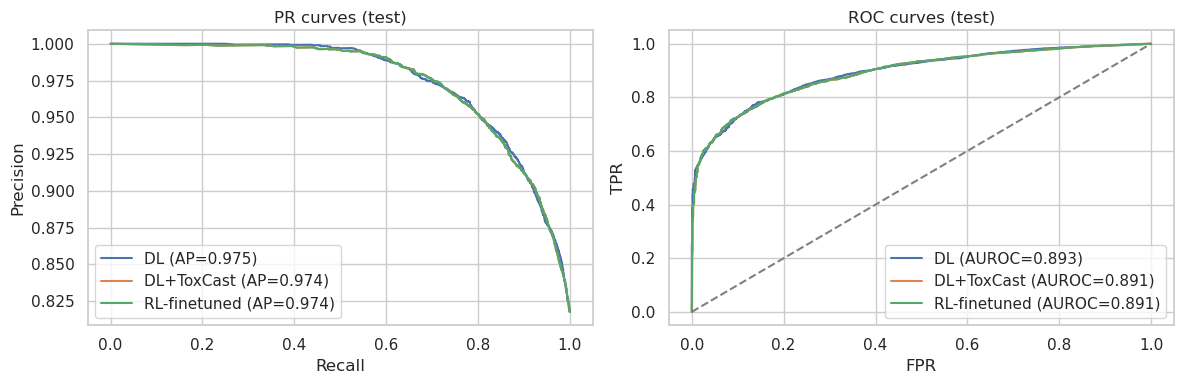

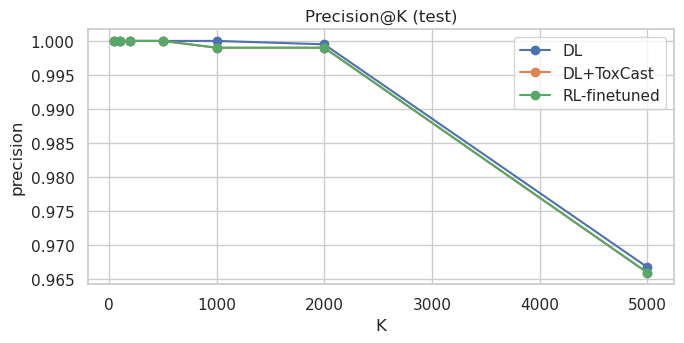

In [29]:
# --- C3) 统一对比：DL / DL+ToxCast / RL（PR/ROC + Precision@K）

if not bool(RUN_OPENFDA_RL):
    print("RUN_OPENFDA_RL=False; skip unified comparison.")
else:
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, roc_curve

    sns.set_theme(style="whitegrid")

    dl_tox_out = OPENFDA_DL_TOXCAST_OUT_DIFFUSED if TOXCAST_INCLUDE_DIFFUSED else OPENFDA_DL_TOXCAST_OUT
    base_kind = str(OPENFDA_RL_BASE_MODEL).strip().lower()
    rl_out = OPENFDA_RL_OUT_PLAIN if base_kind == "plain" else OPENFDA_RL_OUT_TOXCAST

    series = []
    p_plain = OPENFDA_DL_OUT / "test_eval.npz"
    if p_plain.exists():
        series.append(("DL", np.load(p_plain)))

    p_tox = dl_tox_out / "test_eval.npz"
    if p_tox.exists():
        series.append(("DL+ToxCast" + ("+diffused" if TOXCAST_INCLUDE_DIFFUSED else ""), np.load(p_tox)))

    p_rl = rl_out / "test_eval_rl.npz"
    if p_rl.exists():
        series.append(("RL-finetuned", np.load(p_rl)))

    if not series:
        raise FileNotFoundError("No eval npz found; run C1/C2/C3 first.")

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    for name, arr in series:
        y = arr["y_true"].astype(int)
        p = arr["y_prob"].astype(float)
        ap = float(average_precision_score(y, p)) if len(np.unique(y)) > 1 else float("nan")
        prec, rec, _ = precision_recall_curve(y, p)
        ax[0].plot(rec, prec, label=f"{name} (AP={ap:.3f})")
    ax[0].set_title("PR curves (test)")
    ax[0].set_xlabel("Recall")
    ax[0].set_ylabel("Precision")
    ax[0].legend()

    for name, arr in series:
        y = arr["y_true"].astype(int)
        p = arr["y_prob"].astype(float)
        auroc = float(roc_auc_score(y, p)) if len(np.unique(y)) > 1 else float("nan")
        fpr, tpr, _ = roc_curve(y, p)
        ax[1].plot(fpr, tpr, label=f"{name} (AUROC={auroc:.3f})")
    ax[1].plot([0, 1], [0, 1], linestyle="--", color="gray")
    ax[1].set_title("ROC curves (test)")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    # Precision@K curves
    ks = [50, 100, 200, 500, 1000, 2000, 5000]
    fig, ax = plt.subplots(1, 1, figsize=(7, 3.6))
    for name, arr in series:
        y = arr["y_true"].astype(int)
        p = arr["y_prob"].astype(float)
        order = np.argsort(-p)
        k_use = [k for k in ks if k <= y.size]
        vals = [float(y[order[:k]].mean()) for k in k_use]
        ax.plot(k_use, vals, marker="o", label=name)
    ax.set_title("Precision@K (test)")
    ax.set_xlabel("K")
    ax.set_ylabel("precision")
    ax.legend()
    plt.tight_layout()
    plt.show()


### C3.5) 指标偏低的诊断与改进建议

openFDA 早预警任务往往呈现**极端类别不平衡**：在候选集合上，正例比例可能只有千分级；因此：

- **AUPRC 的随机基线≈正例比例**（`pos_rate`），数值会非常小；
- **precision@200 也可能频繁为 0**（即 top-200 里没有真阳性），尤其在 `min_next_count` 较大/候选集合很稀疏时。

如果出现 `val` 指标合理、但 `test AUROC < 0.5` 的情况，常见原因是 **时间漂移（concept drift）**。
下面的诊断 cell 会同时计算 `p` 与 `1-p` 的指标，以快速识别“测试集排序方向反转”的现象，并给出阈值敏感性扫描（基于保存的 `a/a_next`）。

建议优先尝试：
- 使用最近若干年的建模窗口（见配置区 `OPENFDA_MODEL_*`），减少历史分布差异；
- 适度放宽 `min_next_count / max_current_count`，让候选集合有足够的正例密度；
- checkpoint 选择默认用 `auprc`（更稳定），再在 `precision@K` 上做报告/对比。


In [30]:
# --- C3.5) Diagnostics: base rate + inversion check + threshold sensitivity (uses saved eval arrays)

import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.linear_model import LogisticRegression


def _safe_auroc(y: np.ndarray, p: np.ndarray) -> float:
    y = y.astype(int)
    if y.size == 0 or np.unique(y).size < 2:
        return float("nan")
    return float(roc_auc_score(y, p))


def _safe_auprc(y: np.ndarray, p: np.ndarray) -> float:
    y = y.astype(int)
    if y.size == 0 or np.unique(y).size < 2:
        return float("nan")
    return float(average_precision_score(y, p))


def _p_at_k(y: np.ndarray, p: np.ndarray, k: int) -> float:
    y = y.astype(int)
    if y.size == 0:
        return float("nan")
    k = int(min(int(k), int(y.size)))
    if k <= 0:
        return float("nan")
    order = np.argsort(-p)[:k]
    return float(y[order].mean())


def _logit(p: np.ndarray) -> np.ndarray:
    eps = 1e-6
    pp = np.clip(p.astype(np.float64), eps, 1.0 - eps)
    return np.log(pp / (1.0 - pp)).astype(np.float32)



def summarize_eval(path, *, name: str, split: str, k: int):
    z = np.load(path)
    y = z["y_true"].astype(np.int8)
    p = z["y_prob"].astype(np.float32)
    base = float(y.mean()) if y.size else float("nan")

    row = {
        "model": name,
        "split": split,
        "q_from": str(z["q_from"][0]) if "q_from" in z else "",
        "q_to": str(z["q_to"][0]) if "q_to" in z else "",
        "n": int(y.size),
        "pos": int(y.sum()),
        "pos_rate": base,
        "auroc": _safe_auroc(y, p),
        "auprc": _safe_auprc(y, p),
        f"p@{int(k)}": _p_at_k(y, p, int(k)),
        "auroc_inv": _safe_auroc(y, 1.0 - p),
        "auprc_inv": _safe_auprc(y, 1.0 - p),
        f"p@{int(k)}_inv": _p_at_k(y, 1.0 - p, int(k)),
        "random_auprc": base,
        "random_p@k": base,
    }
    if np.isfinite(row["auroc"]) and np.isfinite(row["auroc_inv"]):
        row["inv_better_auroc"] = bool(row["auroc_inv"] > row["auroc"] + 0.02)
    else:
        row["inv_better_auroc"] = False
    return row, z


rows = []
loaded = {}
k = int(OPENFDA_EVAL_TOPK)

# plain DL
plain_val = OPENFDA_DL_OUT / "val_eval.npz"
plain_test = OPENFDA_DL_OUT / "test_eval.npz"
if plain_val.exists():
    row, z = summarize_eval(plain_val, name="DL", split="val", k=k)
    rows.append(row)
    loaded[("DL", "val")] = z
if plain_test.exists():
    row, z = summarize_eval(plain_test, name="DL", split="test", k=k)
    rows.append(row)
    loaded[("DL", "test")] = z

# mechanism-informed DL
dl_tox_out = OPENFDA_DL_TOXCAST_OUT_DIFFUSED if TOXCAST_INCLUDE_DIFFUSED else OPENFDA_DL_TOXCAST_OUT
tox_val = dl_tox_out / "val_eval.npz"
tox_test = dl_tox_out / "test_eval.npz"
if tox_val.exists():
    row, z = summarize_eval(tox_val, name="DL+Mech", split="val", k=k)
    rows.append(row)
    loaded[("DL+Mech", "val")] = z
if tox_test.exists():
    row, z = summarize_eval(tox_test, name="DL+Mech", split="test", k=k)
    rows.append(row)
    loaded[("DL+Mech", "test")] = z

# RL
base_kind = str(OPENFDA_RL_BASE_MODEL).strip().lower()
rl_out = OPENFDA_RL_OUT_PLAIN if base_kind == "plain" else OPENFDA_RL_OUT_TOXCAST
rl_val = rl_out / "val_eval_rl.npz"
rl_test = rl_out / "test_eval_rl.npz"
if rl_val.exists():
    row, z = summarize_eval(rl_val, name="RL", split="val", k=k)
    rows.append(row)
    loaded[("RL", "val")] = z
if rl_test.exists():
    row, z = summarize_eval(rl_test, name="RL", split="test", k=k)
    rows.append(row)
    loaded[("RL", "test")] = z


# --- Optional stacking ensemble (val-fitted, test-evaluated)
stack_models = [m for m in ["DL", "DL+Mech", "RL"] if (m, "val") in loaded and (m, "test") in loaded]
if len(stack_models) >= 2:
    # alignment check on val/test
    def _aligned_eval(a, b):
        if "keys" in a and "keys" in b and not np.array_equal(a["keys"], b["keys"]):
            return False
        if a["y_true"].shape != b["y_true"].shape:
            return False
        if not np.array_equal(a["y_true"], b["y_true"]):
            return False
        return True

    base_val = loaded[(stack_models[0], "val")]
    base_test = loaded[(stack_models[0], "test")]
    aligned = True
    for m in stack_models[1:]:
        if not _aligned_eval(base_val, loaded[(m, "val")]) or not _aligned_eval(base_test, loaded[(m, "test")]):
            aligned = False
            break

    if aligned:
        yv = base_val["y_true"].astype(np.int8).reshape(-1)
        Xv = np.stack([_logit(loaded[(m, "val")]["y_prob"]) for m in stack_models], axis=1)
        clf = LogisticRegression(max_iter=2000, solver="lbfgs")
        clf.fit(Xv, yv.astype(int))

        yt = base_test["y_true"].astype(np.int8)
        Xt = np.stack([_logit(loaded[(m, "test")]["y_prob"]) for m in stack_models], axis=1)
        p_ens = clf.predict_proba(Xt)[:, 1].astype(np.float32)

        row = {
            "model": "Ensemble",
            "split": "test",
            "q_from": str(base_test["q_from"][0]) if "q_from" in base_test else "",
            "q_to": str(base_test["q_to"][0]) if "q_to" in base_test else "",
            "n": int(yt.size),
            "pos": int(yt.sum()),
            "pos_rate": float(yt.mean()) if yt.size else float("nan"),
            "auroc": _safe_auroc(yt, p_ens),
            "auprc": _safe_auprc(yt, p_ens),
            f"p@{int(k)}": _p_at_k(yt, p_ens, int(k)),
            "auroc_inv": _safe_auroc(yt, 1.0 - p_ens),
            "auprc_inv": _safe_auprc(yt, 1.0 - p_ens),
            f"p@{int(k)}_inv": _p_at_k(yt, 1.0 - p_ens, int(k)),
            "random_auprc": float(yt.mean()) if yt.size else float("nan"),
            "random_p@k": float(yt.mean()) if yt.size else float("nan"),
        }
        if np.isfinite(row["auroc"]) and np.isfinite(row["auroc_inv"]):
            row["inv_better_auroc"] = bool(row["auroc_inv"] > row["auroc"] + 0.02)
        else:
            row["inv_better_auroc"] = False
        rows.append(row)

if rows:
    diag = pd.DataFrame(rows).sort_values(["split", "model"]).reset_index(drop=True)
    display(diag)
else:
    print("No eval npz found. Run C1/C2/C3 first.")


# --- Threshold sensitivity (uses stored a/a_next; can only tighten max_current_count, cannot expand beyond saved candidate set)
def sweep_thresholds(z, *, min_next_list: list[int], max_current_list: list[int]) -> pd.DataFrame:
    if not all(k in z for k in ["a", "a_next", "y_prob"]):
        return pd.DataFrame()
    a = z["a"].astype(np.float32)
    a_next = z["a_next"].astype(np.float32)
    p = z["y_prob"].astype(np.float32)

    out = []
    max_a_available = float(np.nanmax(a)) if a.size else 0.0
    for max_a in max_current_list:
        if float(max_a) > max_a_available + 1e-6:
            continue
        mask = a <= float(max_a)
        if not bool(np.any(mask)):
            continue
        a_n = a_next[mask]
        p_n = p[mask]
        for mn in min_next_list:
            y = (a_n >= float(mn)).astype(np.int8)
            base = float(y.mean()) if y.size else float("nan")
            out.append(
                {
                    "max_current_count": int(max_a),
                    "min_next_count": int(mn),
                    "n": int(y.size),
                    "pos": int(y.sum()),
                    "pos_rate": base,
                    "auroc": _safe_auroc(y, p_n),
                    "auprc": _safe_auprc(y, p_n),
                    f"p@{int(k)}": _p_at_k(y, p_n, k),
                }
            )
    if not out:
        return pd.DataFrame()
    return pd.DataFrame(out).sort_values(["max_current_count", "min_next_count"]).reset_index(drop=True)


z_ref = loaded.get(("DL", "test")) or loaded.get(("DL", "val"))
if z_ref is not None:
    sweep_df = sweep_thresholds(z_ref, min_next_list=[5, 10, 20, 30], max_current_list=[1, 2, 3, 5, 8])
    if not sweep_df.empty:
        display(sweep_df)
    else:
        print("Threshold sweep produced no rows (candidate set may be too small).")
else:
    print("No reference eval arrays for threshold sweep.")


model split  q_from    q_to     n   pos  pos_rate     auroc     auprc  \
0        DL  test  2025q2  2025q3  7941  6494  0.817781  0.892673  0.975019   
1   DL+Mech  test  2025q2  2025q3  7941  6494  0.817781  0.891064  0.974300   
2  Ensemble  test  2025q2  2025q3  7941  6494  0.817781  0.895622  0.975813   
3        RL  test  2025q2  2025q3  7941  6494  0.817781  0.891064  0.974300   
4        DL   val  2025q1  2025q2  7631  6054  0.793343  0.890651  0.970226   
5   DL+Mech   val  2025q1  2025q2  7631  6054  0.793343  0.890601  0.970297   
6        RL   val  2025q1  2025q2  7631  6054  0.793343  0.890601  0.970297   

   p@200  auroc_inv  auprc_inv  p@200_inv  random_auprc  random_p@k  \
0    1.0   0.107327   0.654109       0.24      0.817781    0.817781   
1    1.0   0.108936   0.652919       0.23      0.817781    0.817781   
2    1.0   0.104378   0.650102       0.21      0.817781    0.817781   
3    1.0   0.108936   0.652919       0.23      0.817781    0.817781   
4    1.0   0.109349   0.621621       0.20      0.793343    0.793343   
5    1.0   0.109399   0.620698       0.22      0.793343    0.793343   
6    1.0   0.109399   0.620698       0.22      0.793343    0.793343   

   inv_better_auroc  
0             False  
1             False  
2             False  
3             False  
4             False  
5             False  
6             False

max_current_count  min_next_count     n   pos  pos_rate     auroc  \
0                   1               5  3845   355  0.092328  0.612000   
1                   1              10  3845    56  0.014564  0.651611   
2                   1              20  3845     4  0.001040  0.664768   
3                   1              30  3845     2  0.000520  0.646956   
4                   2               5  4806   524  0.109030  0.603248   
5                   2              10  4806    98  0.020391  0.633882   
6                   2              20  4806     9  0.001873  0.633116   
7                   2              30  4806     3  0.000624  0.638039   
8                   3               5  5406   692  0.128006  0.597164   
9                   3              10  5406   152  0.028117  0.613155   
10                  3              20  5406    15  0.002775  0.589637   
11                  3              30  5406     3  0.000555  0.648467   
12                  5               5  6151   975  0.158511  0.601478   
13                  5              10  6151   254  0.041294  0.618933   
14                  5              20  6151    36  0.005853  0.617580   
15                  5              30  6151     9  0.001463  0.635063   
16                  8               5  6748  1322  0.195910  0.614288   
17                  8              10  6748   404  0.059870  0.636481   
18                  8              20  6748    56  0.008299  0.648485   
19                  8              30  6748    13  0.001926  0.653132   

       auprc  p@200  
0   0.114943  0.115  
1   0.021186  0.015  
2   0.001695  0.000  
3   0.000880  0.000  
4   0.128137  0.110  
5   0.026317  0.025  
6   0.002533  0.005  
7   0.000991  0.000  
8   0.144704  0.120  
9   0.033397  0.015  
10  0.003263  0.005  
11  0.000922  0.005  
12  0.176461  0.100  
13  0.049101  0.030  
14  0.007340  0.005  
15  0.002014  0.005  
16  0.219777  0.100  
17  0.073850  0.015  
18  0.011332  0.000  
19  0.002736  0.000

### C3.6) 专家建议落地：按曝光度过滤（min_drug_reports / min_pt_reports）的敏感性

openFDA 的候选集合里会有大量低曝光（drug/PT 报告数极少）的组合，容易导致指标波动和不稳定。
下面的 cell 会基于保存的 `keys` + counts 中的 `drug_reports/pt_reports`，对不同阈值做后验过滤，
观察 AUPRC、P@K 与 lift（相对随机基线 pos_rate）的变化，用于选定更稳健的过滤阈值。


In [31]:
# --- C3.6) Exposure filter sensitivity (post-hoc on saved eval arrays)

import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from sklearn.metrics import average_precision_score, roc_auc_score

from scripts.train_openfda_early_warning_dl import _read_quarter_arrays  # type: ignore

def _safe_auroc(y: np.ndarray, p: np.ndarray) -> float:
    y = y.astype(int)
    if y.size == 0 or np.unique(y).size < 2:
        return float('nan')
    return float(roc_auc_score(y, p))

def _safe_auprc(y: np.ndarray, p: np.ndarray) -> float:
    y = y.astype(int)
    if y.size == 0 or np.unique(y).size < 2:
        return float('nan')
    return float(average_precision_score(y, p))

def _p_at_k(y: np.ndarray, p: np.ndarray, k: int) -> float:
    y = y.astype(int)
    if y.size == 0:
        return float('nan')
    k = int(min(int(k), int(y.size)))
    if k <= 0:
        return float('nan')
    idx = np.argpartition(-p, k - 1)[:k]
    return float(y[idx].mean())

def _load_vocab(vocab_dir: Path):
    v = read_json(vocab_dir / 'vocab.json')
    drugs = [str(x) for x in (v.get('drugs') or [])]
    pts = [str(x) for x in (v.get('pts') or [])]
    return drugs, pts

def _exposure_sweep(*, name: str, eval_path: Path, vocab_dir: Path, k: int, grid_drug: list[int], grid_pt: list[int]):
    z = np.load(eval_path)
    if 'keys' not in z:
        print('Missing keys in', eval_path)
        return pd.DataFrame()
    keys = z['keys'].astype(np.int64)
    y = z['y_true'].astype(np.int8)
    p = z['y_prob'].astype(np.float32)
    q_from = str(z['q_from'][0]) if 'q_from' in z else ''
    drugs, pts = _load_vocab(vocab_dir)
    drug_to_idx = {d: i for i, d in enumerate(drugs)}
    pt_to_idx = {pt: i for i, pt in enumerate(pts)}
    dr, pr, _pairs = _read_quarter_arrays(counts_dir=OPENFDA_COUNTS_DIR, quarter=q_from, drug_to_idx=drug_to_idx, pt_to_idx=pt_to_idx)
    did = (keys >> 32).astype(np.int64)
    pid = (keys & 0xFFFFFFFF).astype(np.int64)
    drug_rep = dr[did].astype(np.float32)
    pt_rep = pr[pid].astype(np.float32)

    out = []
    for md in grid_drug:
        for mp in grid_pt:
            mask = (drug_rep >= float(md)) & (pt_rep >= float(mp))
            if not bool(np.any(mask)):
                continue
            yy = y[mask]
            pp = p[mask]
            base = float(yy.mean()) if yy.size else float('nan')
            auprc = _safe_auprc(yy, pp)
            auroc = _safe_auroc(yy, pp)
            p_at = _p_at_k(yy, pp, int(k))
            lift_auprc = (auprc / base) if (np.isfinite(auprc) and base and base > 0) else float('nan')
            lift_p = (p_at / base) if (np.isfinite(p_at) and base and base > 0) else float('nan')
            out.append({
                'model': name,
                'q_from': q_from,
                'min_drug_reports': int(md),
                'min_pt_reports': int(mp),
                'n': int(yy.size),
                'pos': int(yy.sum()),
                'pos_rate': base,
                'auroc': auroc,
                'auprc': auprc,
                f'p@{int(k)}': p_at,
                'lift_auprc': lift_auprc,
                f'lift_p@{int(k)}': lift_p,
            })
    return pd.DataFrame(out).sort_values(['min_drug_reports','min_pt_reports']).reset_index(drop=True)

grid_drug = [0, 20, 50, 100, 200]
grid_pt = [0, 20, 50, 100, 200]
k = int(OPENFDA_EVAL_TOPK)

dl_tox_out = OPENFDA_DL_TOXCAST_OUT_DIFFUSED if TOXCAST_INCLUDE_DIFFUSED else OPENFDA_DL_TOXCAST_OUT
base_kind = str(OPENFDA_RL_BASE_MODEL).strip().lower()
rl_out = OPENFDA_RL_OUT_PLAIN if base_kind == 'plain' else OPENFDA_RL_OUT_TOXCAST
base_model_dir = OPENFDA_DL_OUT if base_kind == 'plain' else dl_tox_out

evals = []
if (OPENFDA_DL_OUT / 'test_eval.npz').exists():
    evals.append(('DL', OPENFDA_DL_OUT / 'test_eval.npz', OPENFDA_DL_OUT))
if (dl_tox_out / 'test_eval.npz').exists():
    evals.append(('DL+Mech', dl_tox_out / 'test_eval.npz', dl_tox_out))
if (rl_out / 'test_eval_rl.npz').exists():
    # RL uses the base model vocabulary
    evals.append(('RL', rl_out / 'test_eval_rl.npz', base_model_dir))

if not evals:
    print('No eval arrays found. Run C1/C2/C3 first.')
else:
    out_dir = Path('data/outputs')
    out_dir.mkdir(parents=True, exist_ok=True)
    for name, p_eval, vdir in evals:
        df = _exposure_sweep(name=name, eval_path=p_eval, vocab_dir=vdir, k=k, grid_drug=grid_drug, grid_pt=grid_pt)
        if df.empty:
            continue
        out_path = out_dir / f'openfda_exposure_sensitivity_{name}.tsv'
        df.to_csv(out_path, sep='	', index=False)
        display(Markdown(f'**{name}** exposure sweep exported: `{out_path}`'))
        display(df)


**DL** exposure sweep exported: `data/outputs/openfda_exposure_sensitivity_DL.tsv`

model  q_from  min_drug_reports  min_pt_reports     n   pos  pos_rate  \
0     DL  2025q2                 0               0  7941  6494  0.817781   
1     DL  2025q2                 0              20  7941  6494  0.817781   
2     DL  2025q2                 0              50  7941  6494  0.817781   
3     DL  2025q2                 0             100  7941  6494  0.817781   
4     DL  2025q2                 0             200  7246  6014  0.829975   
5     DL  2025q2                20               0  7941  6494  0.817781   
6     DL  2025q2                20              20  7941  6494  0.817781   
7     DL  2025q2                20              50  7941  6494  0.817781   
8     DL  2025q2                20             100  7941  6494  0.817781   
9     DL  2025q2                20             200  7246  6014  0.829975   
10    DL  2025q2                50               0  7941  6494  0.817781   
11    DL  2025q2                50              20  7941  6494  0.817781   
12    DL  2025q2                50              50  7941  6494  0.817781   
13    DL  2025q2                50             100  7941  6494  0.817781   
14    DL  2025q2                50             200  7246  6014  0.829975   
15    DL  2025q2               100               0  7941  6494  0.817781   
16    DL  2025q2               100              20  7941  6494  0.817781   
17    DL  2025q2               100              50  7941  6494  0.817781   
18    DL  2025q2               100             100  7941  6494  0.817781   
19    DL  2025q2               100             200  7246  6014  0.829975   
20    DL  2025q2               200               0  6533  5454  0.834839   
21    DL  2025q2               200              20  6533  5454  0.834839   
22    DL  2025q2               200              50  6533  5454  0.834839   
23    DL  2025q2               200             100  6533  5454  0.834839   
24    DL  2025q2               200             200  5915  5023  0.849197   

       auroc     auprc  p@200  lift_auprc  lift_p@200  
0   0.892673  0.975019    1.0    1.192274    1.222821  
1   0.892673  0.975019    1.0    1.192274    1.222821  
2   0.892673  0.975019    1.0    1.192274    1.222821  
3   0.892673  0.975019    1.0    1.192274    1.222821  
4   0.889876  0.976153    1.0    1.176123    1.204855  
5   0.892673  0.975019    1.0    1.192274    1.222821  
6   0.892673  0.975019    1.0    1.192274    1.222821  
7   0.892673  0.975019    1.0    1.192274    1.222821  
8   0.892673  0.975019    1.0    1.192274    1.222821  
9   0.889876  0.976153    1.0    1.176123    1.204855  
10  0.892673  0.975019    1.0    1.192274    1.222821  
11  0.892673  0.975019    1.0    1.192274    1.222821  
12  0.892673  0.975019    1.0    1.192274    1.222821  
13  0.892673  0.975019    1.0    1.192274    1.222821  
14  0.889876  0.976153    1.0    1.176123    1.204855  
15  0.892673  0.975019    1.0    1.192274    1.222821  
16  0.892673  0.975019    1.0    1.192274    1.222821  
17  0.892673  0.975019    1.0    1.192274    1.222821  
18  0.892673  0.975019    1.0    1.192274    1.222821  
19  0.889876  0.976153    1.0    1.176123    1.204855  
20  0.889850  0.976940    1.0    1.170214    1.197836  
21  0.889850  0.976940    1.0    1.170214    1.197836  
22  0.889850  0.976940    1.0    1.170214    1.197836  
23  0.889850  0.976940    1.0    1.170214    1.197836  
24  0.886347  0.978362    1.0    1.152102    1.177583

**DL+Mech** exposure sweep exported: `data/outputs/openfda_exposure_sensitivity_DL+Mech.tsv`

model  q_from  min_drug_reports  min_pt_reports     n   pos  pos_rate  \
0   DL+Mech  2025q2                 0               0  7941  6494  0.817781   
1   DL+Mech  2025q2                 0              20  7941  6494  0.817781   
2   DL+Mech  2025q2                 0              50  7941  6494  0.817781   
3   DL+Mech  2025q2                 0             100  7941  6494  0.817781   
4   DL+Mech  2025q2                 0             200  7246  6014  0.829975   
5   DL+Mech  2025q2                20               0  7941  6494  0.817781   
6   DL+Mech  2025q2                20              20  7941  6494  0.817781   
7   DL+Mech  2025q2                20              50  7941  6494  0.817781   
8   DL+Mech  2025q2                20             100  7941  6494  0.817781   
9   DL+Mech  2025q2                20             200  7246  6014  0.829975   
10  DL+Mech  2025q2                50               0  7941  6494  0.817781   
11  DL+Mech  2025q2                50              20  7941  6494  0.817781   
12  DL+Mech  2025q2                50              50  7941  6494  0.817781   
13  DL+Mech  2025q2                50             100  7941  6494  0.817781   
14  DL+Mech  2025q2                50             200  7246  6014  0.829975   
15  DL+Mech  2025q2               100               0  7941  6494  0.817781   
16  DL+Mech  2025q2               100              20  7941  6494  0.817781   
17  DL+Mech  2025q2               100              50  7941  6494  0.817781   
18  DL+Mech  2025q2               100             100  7941  6494  0.817781   
19  DL+Mech  2025q2               100             200  7246  6014  0.829975   
20  DL+Mech  2025q2               200               0  6533  5454  0.834839   
21  DL+Mech  2025q2               200              20  6533  5454  0.834839   
22  DL+Mech  2025q2               200              50  6533  5454  0.834839   
23  DL+Mech  2025q2               200             100  6533  5454  0.834839   
24  DL+Mech  2025q2               200             200  5915  5023  0.849197   

       auroc     auprc  p@200  lift_auprc  lift_p@200  
0   0.891064  0.974300  1.000    1.191395    1.222821  
1   0.891064  0.974300  1.000    1.191395    1.222821  
2   0.891064  0.974300  1.000    1.191395    1.222821  
3   0.891064  0.974300  1.000    1.191395    1.222821  
4   0.887371  0.975238  0.995    1.175021    1.198831  
5   0.891064  0.974300  1.000    1.191395    1.222821  
6   0.891064  0.974300  1.000    1.191395    1.222821  
7   0.891064  0.974300  1.000    1.191395    1.222821  
8   0.891064  0.974300  1.000    1.191395    1.222821  
9   0.887371  0.975238  0.995    1.175021    1.198831  
10  0.891064  0.974300  1.000    1.191395    1.222821  
11  0.891064  0.974300  1.000    1.191395    1.222821  
12  0.891064  0.974300  1.000    1.191395    1.222821  
13  0.891064  0.974300  1.000    1.191395    1.222821  
14  0.887371  0.975238  0.995    1.175021    1.198831  
15  0.891064  0.974300  1.000    1.191395    1.222821  
16  0.891064  0.974300  1.000    1.191395    1.222821  
17  0.891064  0.974300  1.000    1.191395    1.222821  
18  0.891064  0.974300  1.000    1.191395    1.222821  
19  0.887371  0.975238  0.995    1.175021    1.198831  
20  0.888966  0.976408  1.000    1.169577    1.197836  
21  0.888966  0.976408  1.000    1.169577    1.197836  
22  0.888966  0.976408  1.000    1.169577    1.197836  
23  0.888966  0.976408  1.000    1.169577    1.197836  
24  0.884928  0.977714  1.000    1.151339    1.177583

**RL** exposure sweep exported: `data/outputs/openfda_exposure_sensitivity_RL.tsv`

model  q_from  min_drug_reports  min_pt_reports     n   pos  pos_rate  \
0     RL  2025q2                 0               0  7941  6494  0.817781   
1     RL  2025q2                 0              20  7941  6494  0.817781   
2     RL  2025q2                 0              50  7941  6494  0.817781   
3     RL  2025q2                 0             100  7941  6494  0.817781   
4     RL  2025q2                 0             200  7246  6014  0.829975   
5     RL  2025q2                20               0  7941  6494  0.817781   
6     RL  2025q2                20              20  7941  6494  0.817781   
7     RL  2025q2                20              50  7941  6494  0.817781   
8     RL  2025q2                20             100  7941  6494  0.817781   
9     RL  2025q2                20             200  7246  6014  0.829975   
10    RL  2025q2                50               0  7941  6494  0.817781   
11    RL  2025q2                50              20  7941  6494  0.817781   
12    RL  2025q2                50              50  7941  6494  0.817781   
13    RL  2025q2                50             100  7941  6494  0.817781   
14    RL  2025q2                50             200  7246  6014  0.829975   
15    RL  2025q2               100               0  7941  6494  0.817781   
16    RL  2025q2               100              20  7941  6494  0.817781   
17    RL  2025q2               100              50  7941  6494  0.817781   
18    RL  2025q2               100             100  7941  6494  0.817781   
19    RL  2025q2               100             200  7246  6014  0.829975   
20    RL  2025q2               200               0  6533  5454  0.834839   
21    RL  2025q2               200              20  6533  5454  0.834839   
22    RL  2025q2               200              50  6533  5454  0.834839   
23    RL  2025q2               200             100  6533  5454  0.834839   
24    RL  2025q2               200             200  5915  5023  0.849197   

       auroc     auprc  p@200  lift_auprc  lift_p@200  
0   0.891064  0.974300  1.000    1.191395    1.222821  
1   0.891064  0.974300  1.000    1.191395    1.222821  
2   0.891064  0.974300  1.000    1.191395    1.222821  
3   0.891064  0.974300  1.000    1.191395    1.222821  
4   0.887371  0.975238  0.995    1.175021    1.198831  
5   0.891064  0.974300  1.000    1.191395    1.222821  
6   0.891064  0.974300  1.000    1.191395    1.222821  
7   0.891064  0.974300  1.000    1.191395    1.222821  
8   0.891064  0.974300  1.000    1.191395    1.222821  
9   0.887371  0.975238  0.995    1.175021    1.198831  
10  0.891064  0.974300  1.000    1.191395    1.222821  
11  0.891064  0.974300  1.000    1.191395    1.222821  
12  0.891064  0.974300  1.000    1.191395    1.222821  
13  0.891064  0.974300  1.000    1.191395    1.222821  
14  0.887371  0.975238  0.995    1.175021    1.198831  
15  0.891064  0.974300  1.000    1.191395    1.222821  
16  0.891064  0.974300  1.000    1.191395    1.222821  
17  0.891064  0.974300  1.000    1.191395    1.222821  
18  0.891064  0.974300  1.000    1.191395    1.222821  
19  0.887371  0.975238  0.995    1.175021    1.198831  
20  0.888966  0.976408  1.000    1.169577    1.197836  
21  0.888966  0.976408  1.000    1.169577    1.197836  
22  0.888966  0.976408  1.000    1.169577    1.197836  
23  0.888966  0.976408  1.000    1.169577    1.197836  
24  0.884928  0.977714  1.000    1.151339    1.177583

### C4) 滚动回测（rolling backtest）与时间漂移诊断

为了展示模型在不同时间窗口上的稳定性，我们对整个季度序列进行滚动回测：
对每个过渡 *(t → t+1)*，计算 AUROC/AUPRC/Precision@K 等指标，并可视化随时间的变化。

该部分既能作为“鲁棒性评估”，也能用于讨论 FAERS 数据的概念漂移（concept drift）现象。


In [32]:
# --- C4) Rolling backtest：逐过渡评估（默认使用 RL 模型；可按需切换）

import math
import time

import torch
from sklearn.metrics import average_precision_score, brier_score_loss, roc_auc_score

# 复用训练脚本中的模型与特征构造（避免重复实现）
from scripts.train_openfda_early_warning_dl import (  # type: ignore
    OpenFDADeepEarlyWarningNet,
    _compute_numeric_features,
    _read_quarter_arrays,
)


def load_tox_features_for_vocab(model_dir: Path, drugs: list[str], device: torch.device) -> torch.Tensor | None:
    cand = [
        model_dir / "drug_toxcast_features_diffused.tsv",
        model_dir / "drug_toxcast_features.tsv",
    ]
    feat_path = next((p for p in cand if p.exists()), None)
    if feat_path is None:
        return None
    feat = pd.read_csv(feat_path, sep="	", dtype={"drug": str})
    if "drug" not in feat.columns:
        raise ValueError(f"Invalid toxcast feature file: {feat_path}")

    feat = feat.set_index("drug")
    cols = [c for c in feat.columns]
    mat = np.zeros((len(drugs), len(cols)), dtype=np.float32)
    for i, d in enumerate(drugs):
        if d not in feat.index:
            continue
        mat[i] = feat.loc[d, cols].to_numpy(dtype=np.float32)
    return torch.tensor(mat, dtype=torch.float32, device=device)


def precision_at_k(y_true: np.ndarray, y_prob: np.ndarray, k: int) -> float:
    k = int(k)
    if k <= 0 or y_true.size == 0:
        return float("nan")
    idx = np.argsort(-y_prob)[:k]
    return float(y_true[idx].mean()) if idx.size > 0 else float("nan")


def score_transition(
    *,
    model: OpenFDADeepEarlyWarningNet,
    device: torch.device,
    counts_dir: Path,
    q_from: str,
    q_to: str,
    drug_to_idx: dict[str, int],
    pt_to_idx: dict[str, int],
    totals: dict[str, float],
    tox_by_drug: torch.Tensor | None,
    min_next_count: int,
    label_mode: str,
    max_current_count: int | None,
    pair_history_lags: int,
    quarter_to_pos: dict[str, int],
    quarters: list[str],
    batch_size: int,
    topk: int,
    max_pairs: int | None,
    cache: dict,
) -> dict:
    if q_from in cache:
        dr_from, pr_from, pairs_from, tot_from = cache[q_from]
    else:
        dr_from, pr_from, pairs_from = _read_quarter_arrays(
            counts_dir=counts_dir,
            quarter=q_from,
            drug_to_idx=drug_to_idx,
            pt_to_idx=pt_to_idx,
        )
        tot_from = float(totals.get(q_from) or 0.0)
        cache[q_from] = (dr_from, pr_from, pairs_from, tot_from)

    if q_to in cache:
        dr_to, pr_to, pairs_to, tot_to = cache[q_to]
    else:
        dr_to, pr_to, pairs_to = _read_quarter_arrays(
            counts_dir=counts_dir,
            quarter=q_to,
            drug_to_idx=drug_to_idx,
            pt_to_idx=pt_to_idx,
        )
        tot_to = float(totals.get(q_to) or 0.0)
        cache[q_to] = (dr_to, pr_to, pairs_to, tot_to)

    # History lags for pair counts (temporal numeric features)
    hist_pairs = []
    if int(pair_history_lags) > 0:
        pos = quarter_to_pos.get(str(q_from).strip().lower())
        for lag in range(1, int(pair_history_lags) + 1):
            j = int(pos) - int(lag) if pos is not None else -1
            if j < 0:
                hist_pairs.append(None)
                continue
            qh = str(quarters[int(j)]).strip().lower()
            if qh in cache:
                _dr_h, _pr_h, pairs_h, _tot_h = cache[qh]
            else:
                _dr_h, _pr_h, pairs_h = _read_quarter_arrays(
                    counts_dir=counts_dir,
                    quarter=qh,
                    drug_to_idx=drug_to_idx,
                    pt_to_idx=pt_to_idx,
                )
                _tot_h = float(totals.get(qh) or 0.0)
                cache[qh] = (_dr_h, _pr_h, pairs_h, _tot_h)
            hist_pairs.append(pairs_h)

    keys_from = np.fromiter((int(k) for k in pairs_from.keys()), dtype=np.int64)
    keys_to = np.fromiter((int(k) for k in pairs_to.keys()), dtype=np.int64)
    keys = np.unique(np.concatenate([keys_from, keys_to]))

    if max_pairs is not None and int(max_pairs) > 0 and keys.shape[0] > int(max_pairs):
        rng = np.random.default_rng(123)
        keys = keys[rng.choice(keys.shape[0], size=int(max_pairs), replace=False)]

    did = (keys >> 32).astype(np.int64)
    pid = (keys & 0xFFFFFFFF).astype(np.int64)

    # feature counts from q_from; labels from q_to
    a = np.fromiter((float(pairs_from.get(int(k), 0.0)) for k in keys), dtype=np.float32)
    a_next = np.fromiter((float(pairs_to.get(int(k), 0.0)) for k in keys), dtype=np.float32)
    y = (a_next >= float(min_next_count))
    if str(label_mode).strip().lower() == "emerging":
        if max_current_count is None:
            raise ValueError("label_mode='emerging' requires max_current_count")
        y = y & (a <= float(max_current_count))
    y = y.astype(np.int64)

    # Candidate-set evaluation for the emerging-label task (current-quarter a <= max_current_count)
    if str(label_mode).strip().lower() == "emerging":
        cand_mask = a <= float(max_current_count)
        keys = keys[cand_mask]
        did = did[cand_mask]
        pid = pid[cand_mask]
        a = a[cand_mask]
        a_next = a_next[cand_mask]
        y = y[cand_mask]

    model.eval()
    probs = np.zeros((keys.shape[0],), dtype=np.float32)
    with torch.no_grad():
        for i in range(0, keys.shape[0], int(batch_size)):
            sl = slice(i, i + int(batch_size))
            d_i = torch.tensor(did[sl], dtype=torch.long, device=device)
            p_i = torch.tensor(pid[sl], dtype=torch.long, device=device)
            a_i = torch.tensor(a[sl], dtype=torch.float32, device=device)

            dr = torch.tensor(dr_from[did[sl]], dtype=torch.float32, device=device)
            pr = torch.tensor(pr_from[pid[sl]], dtype=torch.float32, device=device)
            tr = torch.full((int(d_i.shape[0]),), float(tot_from), dtype=torch.float32, device=device)
            a_hist_t = None
            if int(pair_history_lags) > 0:
                a_hist_np = np.zeros((int(d_i.shape[0]), int(pair_history_lags)), dtype=np.float32)
                for li in range(int(pair_history_lags)):
                    pairs_h = hist_pairs[li] if li < len(hist_pairs) else None
                    if pairs_h is None:
                        continue
                    a_hist_np[:, li] = np.fromiter((float(pairs_h.get(int(k), 0.0)) for k in keys[sl]), dtype=np.float32)
                a_hist_t = torch.tensor(a_hist_np, dtype=torch.float32, device=device)

            num_feat = _compute_numeric_features(a=a_i, drug_reports=dr, pt_reports=pr, total_reports=tr, a_hist=a_hist_t)

            tox_feat = None
            if tox_by_drug is not None:
                tox_feat = tox_by_drug[d_i]

            logits = model(drug_idx=d_i, pt_idx=p_i, num_feat=num_feat, tox_feat=tox_feat)
            probs[sl] = torch.sigmoid(logits).detach().cpu().numpy().astype(np.float32)

    if len(np.unique(y)) > 1:
        auroc = float(roc_auc_score(y, probs))
        auprc = float(average_precision_score(y, probs))
    else:
        auroc = float("nan")
        auprc = float("nan")

    out = {
        "q_from": q_from,
        "q_to": q_to,
        "n": int(y.size),
        "pos": int(y.sum()),
        "pos_rate": float(y.mean()) if y.size > 0 else float("nan"),
        "auroc": float(auroc),
        "auprc": float(auprc),
        "brier": float(brier_score_loss(y.astype(int), probs.astype(float))),
        f"p@{int(topk)}": float(precision_at_k(y, probs, int(topk))),
    }
    return out


# choose which model to backtest
use_rl = bool(RUN_OPENFDA_RL)
base_kind = str(OPENFDA_RL_BASE_MODEL).strip().lower()
dl_tox_out = OPENFDA_DL_TOXCAST_OUT_DIFFUSED if TOXCAST_INCLUDE_DIFFUSED else OPENFDA_DL_TOXCAST_OUT

if base_kind == "toxcast" and not (dl_tox_out / "model.pt").exists():
    print("[openFDA] toxcast base model not found; falling back to plain for backtest.")
    base_kind = "plain"

if use_rl:
    model_dir = OPENFDA_RL_OUT_PLAIN if base_kind == "plain" else OPENFDA_RL_OUT_TOXCAST
    ckpt_path = model_dir / "model_rl.pt"
    ckpt = torch.load(ckpt_path, map_location="cpu")
    base_model_dir = Path(str(ckpt.get("base_model_dir") or (OPENFDA_DL_OUT if base_kind == "plain" else dl_tox_out)))
    vocab = read_json(base_model_dir / "vocab.json")
else:
    base_model_dir = OPENFDA_DL_OUT if base_kind == "plain" else dl_tox_out
    ckpt_path = base_model_dir / "model.pt"
    ckpt = torch.load(ckpt_path, map_location="cpu")
    vocab = read_json(base_model_dir / "vocab.json")

keep_drugs = [str(x) for x in vocab.get("drugs") or []]
keep_pts = [str(x) for x in vocab.get("pts") or []]

if not keep_drugs or not keep_pts:
    raise ValueError("Empty vocab; cannot run backtest")

model = OpenFDADeepEarlyWarningNet(**ckpt["model_kwargs"]).to(torch.device(DEVICE))
model.load_state_dict(ckpt["state_dict"])

# tox features are needed iff model expects them
need_tox = int(ckpt["model_kwargs"].get("tox_feat_dim") or 0) > 0
tox_by_drug = None
if need_tox:
    tox_by_drug = load_tox_features_for_vocab(base_model_dir, keep_drugs, torch.device(DEVICE))
    if tox_by_drug is None:
        raise FileNotFoundError("Model expects tox features, but drug_toxcast_features*.tsv not found.")

counts_dir = OPENFDA_COUNTS_DIR

drug_to_idx = {d: i for i, d in enumerate(keep_drugs)}
pt_to_idx = {pt: j for j, pt in enumerate(keep_pts)}

totals = total_reports.set_index("quarter")["n_reports"].astype(float).to_dict()

transitions = list(zip(openfda_quarters[:-1], openfda_quarters[1:], strict=False))
if OPENFDA_BACKTEST_LAST_N_TRANSITIONS is not None:
    n_keep = int(OPENFDA_BACKTEST_LAST_N_TRANSITIONS)
    if n_keep > 0 and len(transitions) > n_keep:
        transitions = transitions[-n_keep:]
        print(f"[openFDA] backtest: using last {n_keep} transitions")
quarter_to_pos = {str(q).strip().lower(): int(i) for i, q in enumerate(openfda_quarters)}
num_feat_dim = int(ckpt["model_kwargs"].get("num_feat_dim") or 7)
pair_history_lags = int(ckpt.get("pair_history_lags") or max(0, num_feat_dim - 7))
print("[openFDA] backtest pair_history_lags:", pair_history_lags)

rows = []
cache = {}
start = time.perf_counter()
for q_from, q_to in transitions:
    rows.append(
        score_transition(
            model=model,
            device=torch.device(DEVICE),
            counts_dir=counts_dir,
            q_from=q_from,
            q_to=q_to,
            drug_to_idx=drug_to_idx,
            pt_to_idx=pt_to_idx,
            totals=totals,
            tox_by_drug=tox_by_drug,
            min_next_count=int(OPENFDA_MIN_NEXT_COUNT),
            label_mode=str(OPENFDA_LABEL_MODE),
            max_current_count=(
                int(OPENFDA_MAX_CURRENT_COUNT) if str(OPENFDA_LABEL_MODE).strip().lower() == "emerging" else None
            ),
            pair_history_lags=int(pair_history_lags),
            quarter_to_pos=quarter_to_pos,
            quarters=openfda_quarters,
            batch_size=int(OPENFDA_RL_BATCH_SIZE if use_rl else OPENFDA_DL_BATCH_SIZE),
            topk=int(OPENFDA_EVAL_TOPK),
            max_pairs=OPENFDA_EVAL_MAX_PAIRS,
            cache=cache,
        )
    )

backtest = pd.DataFrame(rows)
print(f"rolling backtest finished: n_transitions={backtest.shape[0]} | time={time.perf_counter()-start:.1f}s")

out_path = Path("data/outputs/openfda_rolling_metrics.tsv")
out_path.parent.mkdir(parents=True, exist_ok=True)
backtest.to_csv(out_path, sep="	", index=False)
print("Saved:", out_path)
backtest.head()


[openFDA] backtest: using last 12 transitions
[openFDA] backtest pair_history_lags: 4
rolling backtest finished: n_transitions=12 | time=6.4s
Saved: data/outputs/openfda_rolling_metrics.tsv


q_from    q_to      n   pos  pos_rate     auroc     auprc     brier  p@200
0  2022q3  2022q4  12586  9111  0.723900  0.883813  0.952368  0.162668  0.975
1  2022q4  2023q1  12693  9248  0.728591  0.881118  0.954955  0.163568  0.990
2  2023q1  2023q2  12835  9184  0.715543  0.886435  0.955644  0.160784  1.000
3  2023q2  2023q3  12726  9202  0.723087  0.881896  0.953705  0.164099  1.000
4  2023q3  2023q4  12581  9065  0.720531  0.884865  0.955588  0.164244  1.000

In [33]:
# --- C4) 回测可视化：指标随时间变化（AUROC/AUPRC/Precision@K）

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

if "backtest" not in globals():
    raise RuntimeError("backtest DataFrame not found; run the previous cell first.")

import numpy as np

quarters = backtest["q_to"].astype(str).tolist()
x = np.arange(len(quarters))


# Quarter tick helper is defined in the utilities cell.

fig, ax = plt.subplots(3, 1, figsize=(16, 9.2), sharex=True)

ax[0].plot(x, backtest["auprc"].to_numpy(), marker="o", linewidth=1.5, markersize=4)
ax[0].set_title("Rolling backtest: AUPRC")
ax[0].set_ylabel("AUPRC")
ax[0].grid(True, alpha=0.3)

ax[1].plot(
    x,
    backtest[f"p@{int(OPENFDA_EVAL_TOPK)}"].to_numpy(),
    marker="o",
    linewidth=1.5,
    markersize=4,
    color="tab:orange",
)
ax[1].set_title(f"Rolling backtest: Precision@{int(OPENFDA_EVAL_TOPK)}")
ax[1].set_ylabel("precision")
ax[1].grid(True, alpha=0.3)

ax[2].plot(x, backtest["pos_rate"].to_numpy(), marker="o", linewidth=1.5, markersize=4, color="tab:purple")
ax[2].set_title("Rolling backtest: positive rate")
ax[2].set_xlabel("q_to")
ax[2].set_ylabel("pos_rate")
ax[2].grid(True, alpha=0.3)

ax[0].tick_params(axis="x", labelbottom=False)
ax[1].tick_params(axis="x", labelbottom=False)
apply_quarter_ticks(ax[2], quarters, max_labels=12)

plt.tight_layout()
plt.show()

from IPython.display import display

display(backtest.select_dtypes(include="number").describe().T.head(15))
display(backtest[["q_from", "q_to"]].drop_duplicates().head(15))


count          mean         std           min           25%  \
n          12.0  12599.583333  261.879729  12295.000000  12446.750000   
pos        12.0   9145.833333  312.776375   8851.000000   9000.750000   
pos_rate   12.0      0.725745    0.012174      0.710902      0.720165   
auroc      12.0      0.889240    0.005539      0.881118      0.884602   
auprc      12.0      0.958133    0.003860      0.952368      0.955430   
brier      12.0      0.159757    0.005154      0.149822      0.156276   
p@200      12.0      0.997083    0.007525      0.975000      1.000000   

                   50%           75%           max  
n         12562.000000  12701.250000  13255.000000  
pos        9088.000000   9188.500000  10051.000000  
pos_rate      0.722321      0.729115      0.758280  
auroc         0.890027      0.893500      0.898264  
auprc         0.958472      0.960227      0.965570  
brier         0.159664      0.163701      0.168275  
p@200         1.000000      1.000000      1.000000

q_from    q_to
0   2022q3  2022q4
1   2022q4  2023q1
2   2023q1  2023q2
3   2023q2  2023q3
4   2023q3  2023q4
5   2023q4  2024q1
6   2024q1  2024q2
7   2024q2  2024q3
8   2024q3  2024q4
9   2024q4  2025q1
10  2025q1  2025q2
11  2025q2  2025q3

In [34]:
# --- C5) Case study：top signals（RL vs base）

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

sns.set_theme(style="whitegrid")

# base model: prefer toxcast if available, otherwise fall back to plain
base_kind = str(OPENFDA_RL_BASE_MODEL).strip().lower()
dl_tox_out = OPENFDA_DL_TOXCAST_OUT_DIFFUSED if TOXCAST_INCLUDE_DIFFUSED else OPENFDA_DL_TOXCAST_OUT

if base_kind == "toxcast" and (dl_tox_out / "top_predictions.tsv").exists():
    base_model_dir = dl_tox_out
else:
    base_model_dir = OPENFDA_DL_OUT

base_top = pd.read_csv(base_model_dir / "top_predictions.tsv", sep="	")
print("Base top predictions:", base_top.shape, "| dir=", base_model_dir)

rl_top = None
if bool(RUN_OPENFDA_RL):
    rl_out = OPENFDA_RL_OUT_PLAIN if base_kind == "plain" else OPENFDA_RL_OUT_TOXCAST
    rl_top_path = rl_out / "top_predictions_rl.tsv"
    if rl_top_path.exists():
        rl_top = pd.read_csv(rl_top_path, sep="	")
        print("RL top predictions:", rl_top.shape, "| dir=", rl_out)

# overlap diagnostic
if rl_top is not None:
    base_pairs = set(zip(base_top["drug"].astype(str), base_top["pt"].astype(str), strict=False))
    rl_pairs = set(zip(rl_top["drug"].astype(str), rl_top["pt"].astype(str), strict=False))
    inter = len(base_pairs & rl_pairs)
    print(f"Top list overlap: {inter}/{len(base_pairs)}")

print("Base head:")
display(base_top.head(10))
if rl_top is not None:
    print("RL head:")
    display(rl_top.head(10))


Base top predictions: (5000, 8) | dir= data/models/openfda_ew_dl_toxcast_2020q4_2025q3_threshold_next1_hist4_embint1_bce_bpr_trainlast8
RL top predictions: (5000, 8) | dir= data/models/openfda_policy_rl_toxcast_2020q4_2025q3_threshold_next1_hist4_embint1_bce_bpr_trainlast8
Top list overlap: 5000/5000
Base head:


q_from    q_to                  drug            pt    a  a_next  y_true  \
0  2025q2  2025q3             LINEZOLID       MALAISE  0.0     3.0       1   
1  2025q2  2025q3  ESCITALOPRAM OXALATE      ASPHYXIA  0.0     1.0       1   
2  2025q2  2025q3              MORPHINE  HYPOKALAEMIA  0.0     2.0       1   
3  2025q2  2025q3      DARBEPOETIN ALFA          RASH  0.0     1.0       1   
4  2025q2  2025q3            AMLODIPINE      EPILEPSY  0.0     2.0       1   
5  2025q2  2025q3    MONTELUKAST SODIUM      DIPLOPIA  0.0     1.0       1   
6  2025q2  2025q3      INSULIN GLARGINE         POLYP  0.0     1.0       1   
7  2025q2  2025q3     ALBUTEROL SULFATE      ALOPECIA  0.0     2.0       1   
8  2025q2  2025q3            LORATADINE       AGEUSIA  0.0     1.0       1   
9  2025q2  2025q3           EPINEPHRINE       MYALGIA  0.0     1.0       1   

   y_pred  
0     1.0  
1     1.0  
2     1.0  
3     1.0  
4     1.0  
5     1.0  
6     1.0  
7     1.0  
8     1.0  
9     1.0

RL head:


q_from    q_to                            drug           pt    a  a_next  \
0  2025q2  2025q3                    TRIMETHOPRIM   HYPOACUSIS  0.0     1.0   
1  2025q2  2025q3                        NICOTINE     EPILEPSY  0.0     2.0   
2  2025q2  2025q3                     AMOXICILLIN         MASS  0.0     1.0   
3  2025q2  2025q3                        DIAZEPAM     ASPHYXIA  0.0     9.0   
4  2025q2  2025q3       PROPRANOLOL HYDROCHLORIDE      MYALGIA  0.0     1.0   
5  2025q2  2025q3                      AMIODARONE       SEPSIS  0.0     2.0   
6  2025q2  2025q3                      BORTEZOMIB     ALOPECIA  0.0     1.0   
7  2025q2  2025q3  MOMETASONE FUROATE MONOHYDRATE  FACE OEDEMA  0.0     1.0   
8  2025q2  2025q3                 LITHIUM CITRATE      MYALGIA  0.0     1.0   
9  2025q2  2025q3               DIVALPROEX SODIUM        COUGH  0.0     1.0   

   y_true  y_pred  
0       1     1.0  
1       1     1.0  
2       1     1.0  
3       1     1.0  
4       1     1.0  
5       1     1.0  
6       1     1.0  
7       1     1.0  
8       1     1.0  
9       1     1.0

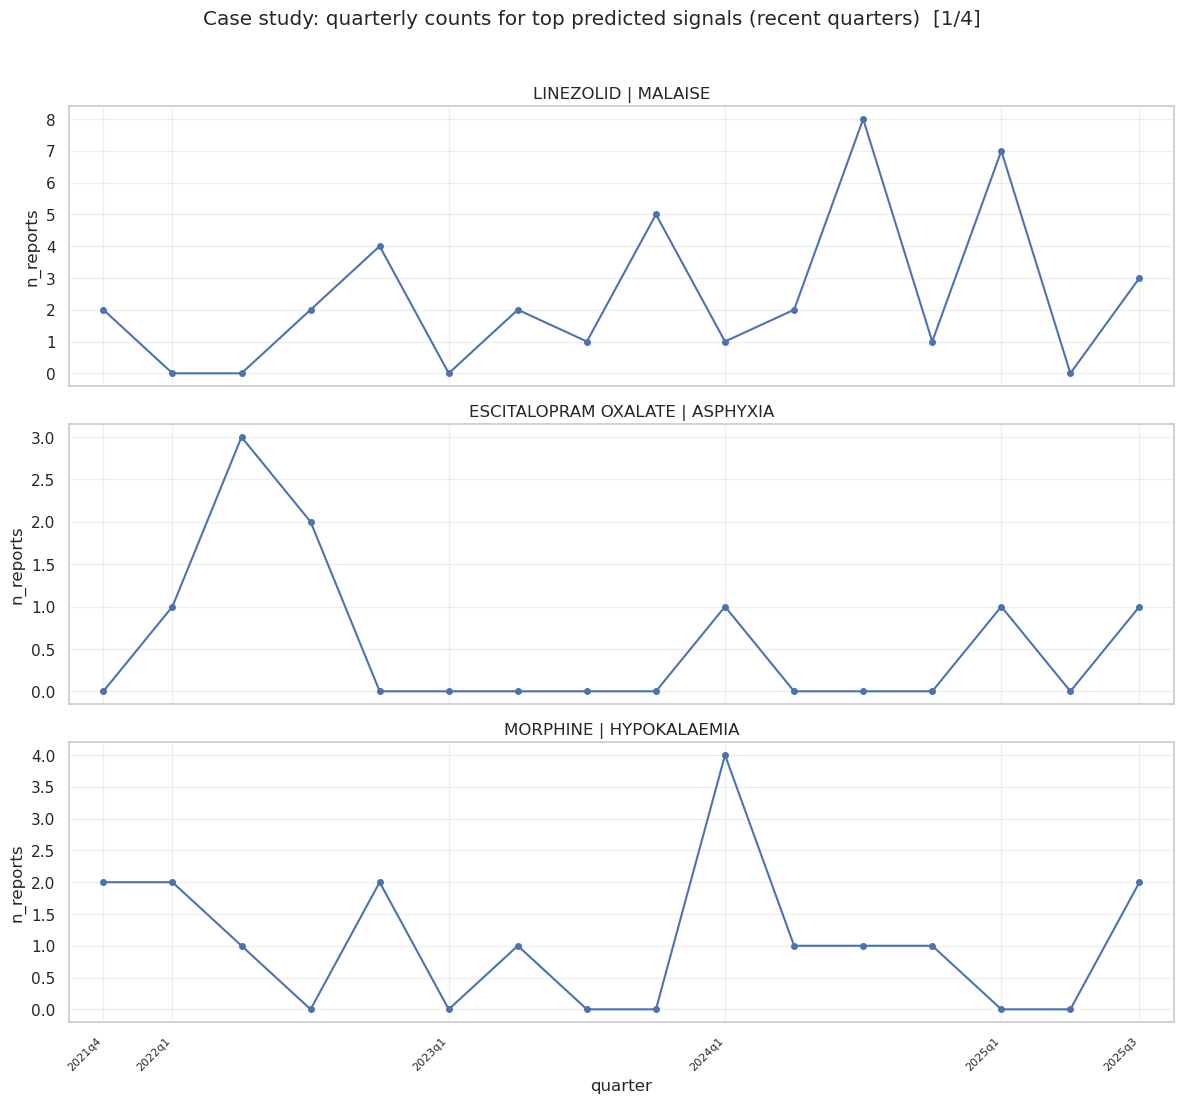

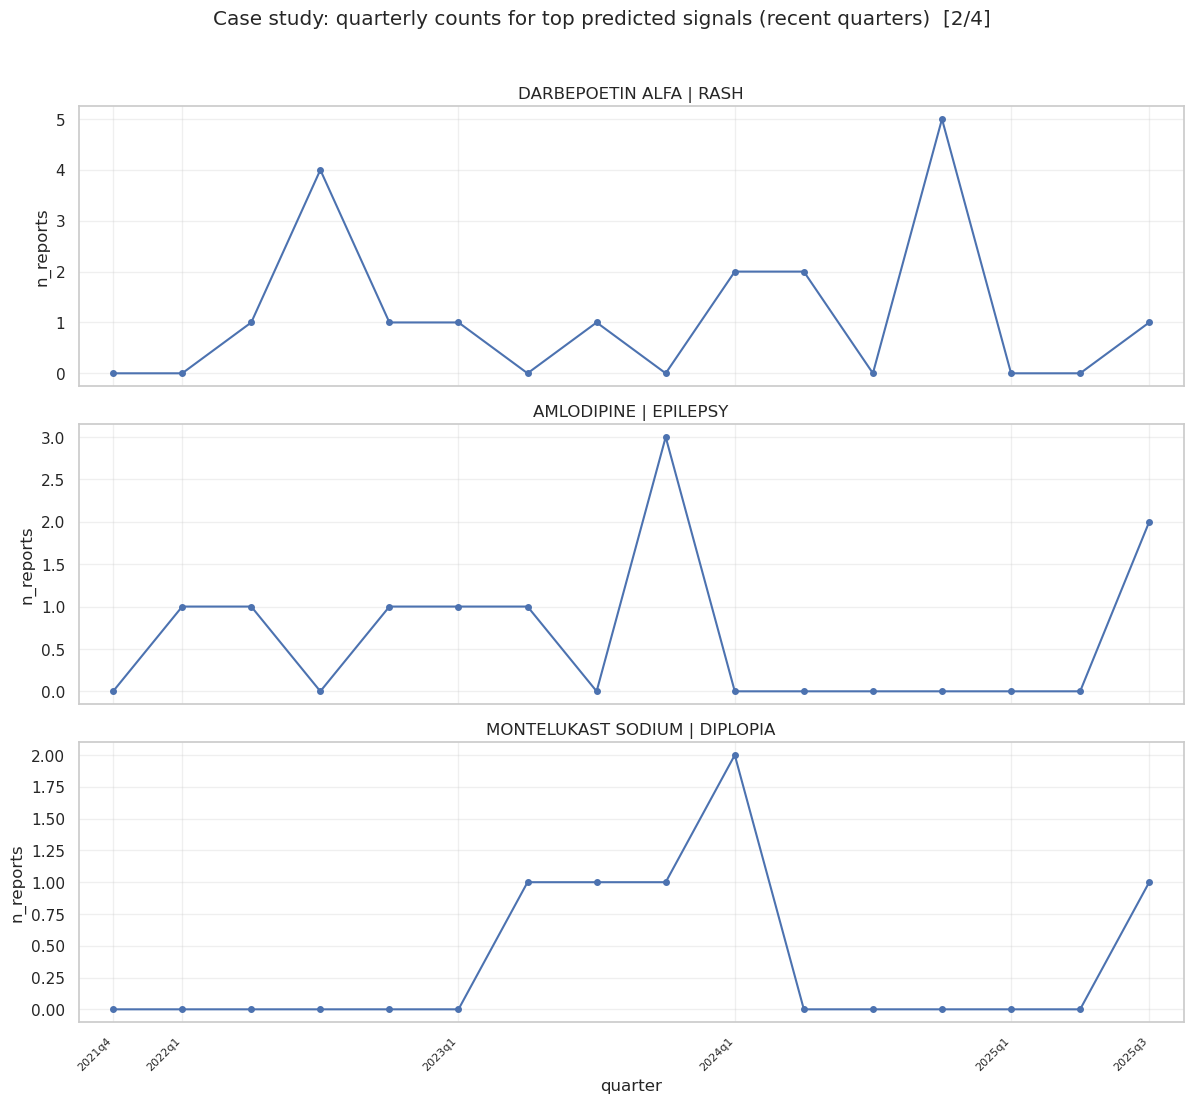

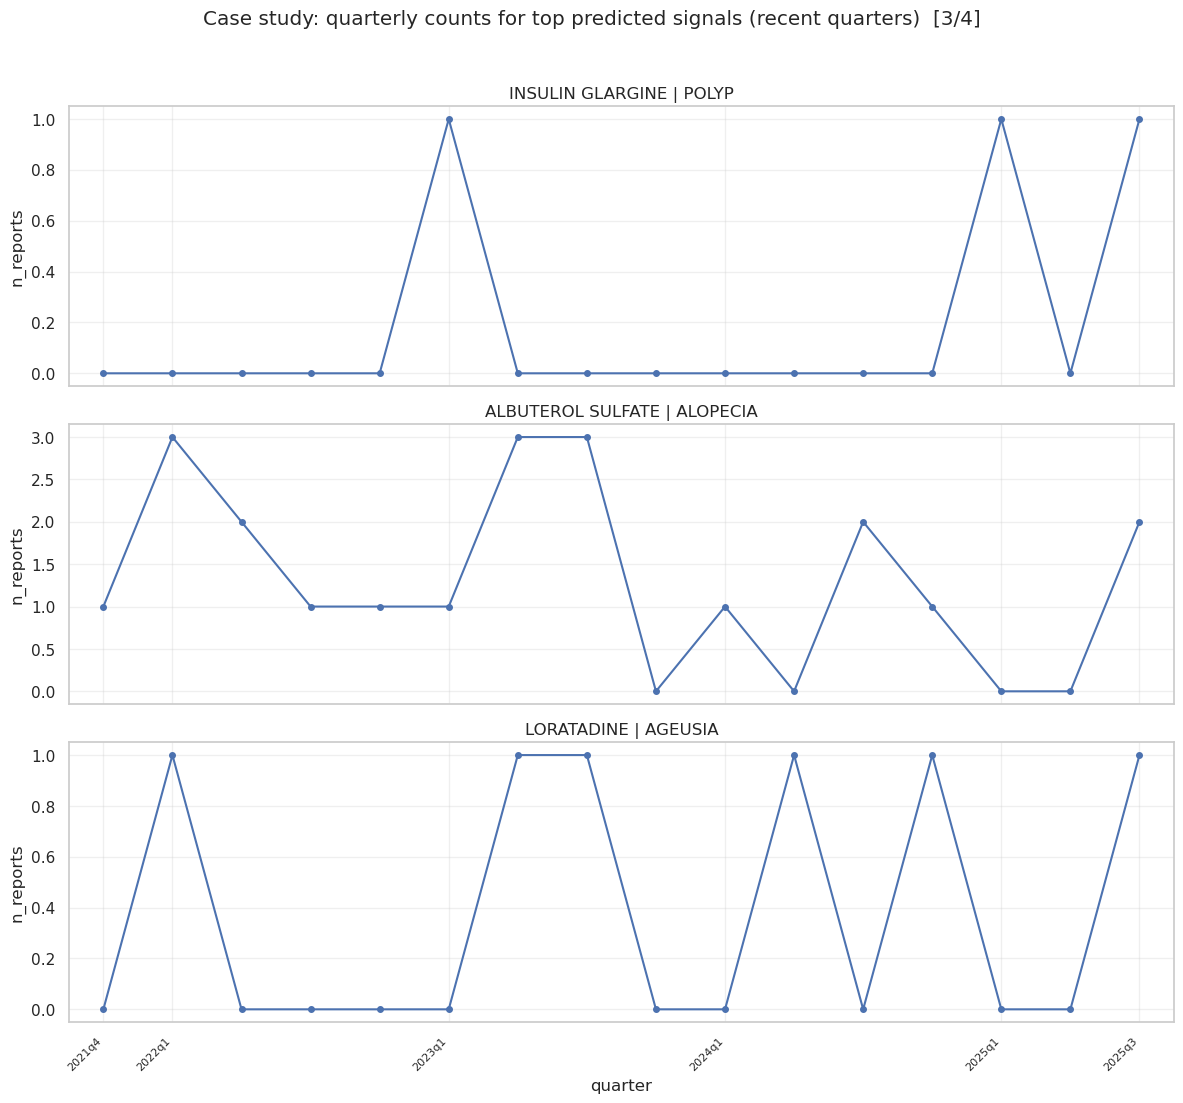

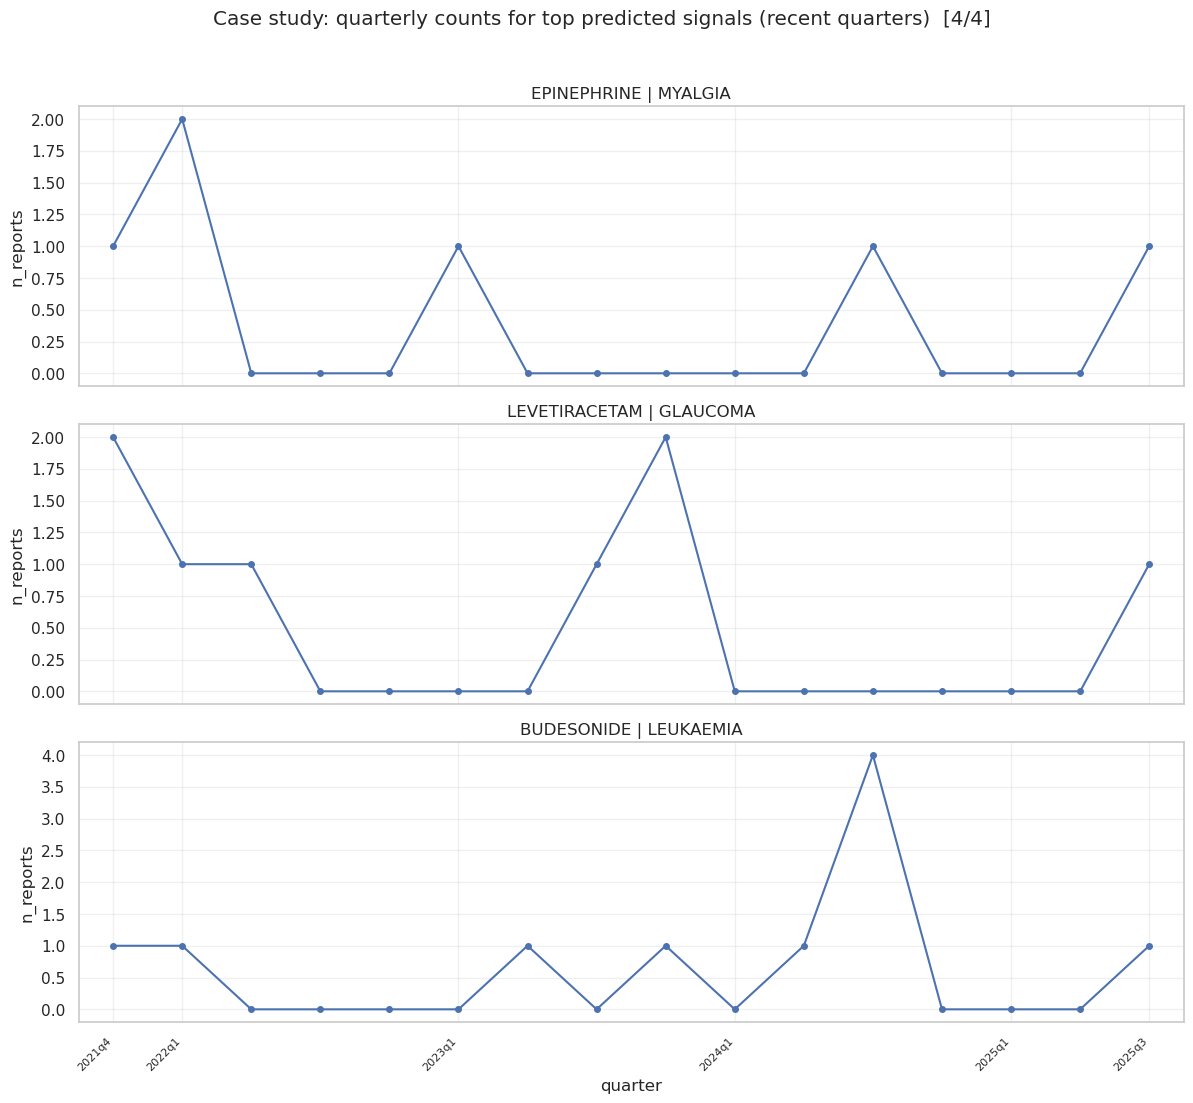

In [35]:
# --- C5) Case study：信号随时间的计数轨迹（展示“早预警”含义）

import csv
import math
import matplotlib.pyplot as plt

# 只对最近若干季度做轨迹展示（用于论文图；避免扫描全历史的全部 drug–PT 文件导致运行过久）
last_n = 16
qs = openfda_quarters[-last_n:]

dl_tox_out = OPENFDA_DL_TOXCAST_OUT_DIFFUSED if TOXCAST_INCLUDE_DIFFUSED else OPENFDA_DL_TOXCAST_OUT
base_kind = str(OPENFDA_RL_BASE_MODEL).strip().lower()
base_model_dir = dl_tox_out if base_kind == "toxcast" and (dl_tox_out / "top_predictions.tsv").exists() else OPENFDA_DL_OUT

base_top = pd.read_csv(base_model_dir / "top_predictions.tsv", sep="	").head(12)
pairs = list(zip(base_top["drug"].astype(str), base_top["pt"].astype(str), strict=False))

traj = {pair: [0.0 for _ in qs] for pair in pairs}
pair_set = set(pairs)

for qi, q in enumerate(qs):
    path = OPENFDA_COUNTS_DIR / "quarters" / q / "drug_pt_counts.tsv"
    if not path.exists():
        continue
    found = {pair: 0.0 for pair in pairs}
    with path.open("r", encoding="utf-8", newline="") as f:
        r = csv.DictReader(f, delimiter="	")
        for row in r:
            d = str(row.get("drug") or "").strip()
            pt = str(row.get("pt") or "").strip()
            k = (d, pt)
            if k not in pair_set:
                continue
            found[k] = float(row.get("n_reports") or 0.0)
    for pair in pairs:
        traj[pair][qi] = float(found.get(pair, 0.0))

n = len(pairs)
per_fig = 3  # 1 列 3 排，避免横向子图导致刻度拥挤
n_fig = int(math.ceil(n / per_fig)) if n > 0 else 0

if n_fig == 0:
    raise RuntimeError("No (drug, PT) pairs found for case study plotting.")

for fi in range(n_fig):
    group = pairs[fi * per_fig : (fi + 1) * per_fig]
    fig, axes = plt.subplots(len(group), 1, figsize=(12, 3.6 * len(group)), sharex=True)
    if len(group) == 1:
        axes = [axes]

    for ax, (d, pt) in zip(axes, group, strict=False):
        ys = traj[(d, pt)]
        ax.plot(qs, ys, marker="o", linewidth=1.5, markersize=4)
        ax.set_title(f"{d} | {pt}")
        ax.set_ylabel("n_reports")
        ax.grid(True, alpha=0.3)
        apply_quarter_ticks(ax, qs, max_labels=10)

    axes[-1].set_xlabel("quarter")
    fig.suptitle(
        f"Case study: quarterly counts for top predicted signals (recent quarters)  [{fi+1}/{n_fig}]",
        y=1.02,
    )
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_779249/6506676.py:107: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1767964447771/work/torch/csrc/utils/tensor_new.cpp:253.)
  tox_feat = torch.tensor([tox_vec], dtype=torch.float32, device=torch.device(DEVICE))
/tmp/ipykernel_779249/6506676.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=attr_df.sort_values("attr"), x="attr", y="feature", palette="coolwarm")


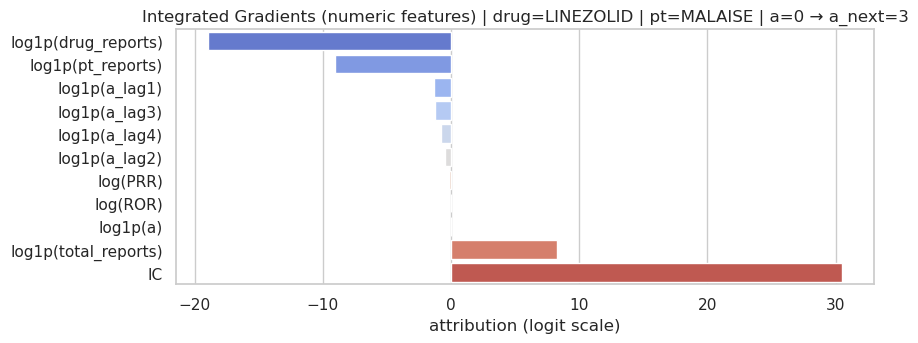

In [36]:
# --- C6) Explainability：Integrated Gradients（数值特征 + toxcast 特征）

import torch
import seaborn as sns
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients

from scripts.train_openfda_early_warning_dl import OpenFDADeepEarlyWarningNet, _compute_numeric_features  # type: ignore

sns.set_theme(style="whitegrid")

# choose a sample from the base model top list
base_kind = str(OPENFDA_RL_BASE_MODEL).strip().lower()
dl_tox_out = OPENFDA_DL_TOXCAST_OUT_DIFFUSED if TOXCAST_INCLUDE_DIFFUSED else OPENFDA_DL_TOXCAST_OUT
base_model_dir = OPENFDA_DL_OUT if base_kind == "plain" else dl_tox_out

ckpt = torch.load(base_model_dir / "model.pt", map_location="cpu")
vocab = read_json(base_model_dir / "vocab.json")
keep_drugs = [str(x) for x in vocab.get("drugs") or []]
keep_pts = [str(x) for x in vocab.get("pts") or []]

model = OpenFDADeepEarlyWarningNet(**ckpt["model_kwargs"]).to(torch.device(DEVICE))
model.load_state_dict(ckpt["state_dict"])
model.eval()

need_tox = int(ckpt["model_kwargs"].get("tox_feat_dim") or 0) > 0

# pick a high-scoring sample from top_predictions.tsv
pred = pd.read_csv(base_model_dir / "top_predictions.tsv", sep="	").iloc[0]
drug = str(pred["drug"]).strip()
pt = str(pred["pt"]).strip()

q_from = str(pred.get("q_from") or openfda_quarters[-2]).strip().lower()
q_to = str(pred.get("q_to") or openfda_quarters[-1]).strip().lower()

# build single-sample feature tensors
from scripts.train_openfda_early_warning_dl import _read_quarter_arrays  # type: ignore

drug_to_idx = {d: i for i, d in enumerate(keep_drugs)}
pt_to_idx = {p: i for i, p in enumerate(keep_pts)}

did = int(drug_to_idx.get(drug, -1))
pid = int(pt_to_idx.get(pt, -1))
if did < 0 or pid < 0:
    raise ValueError("Selected (drug,pt) not in vocab; try another sample.")

qdir = OPENFDA_COUNTS_DIR

# quarter arrays
_dr, _pr, pairs_from = _read_quarter_arrays(counts_dir=qdir, quarter=q_from, drug_to_idx=drug_to_idx, pt_to_idx=pt_to_idx)
_dr2, _pr2, pairs_to = _read_quarter_arrays(counts_dir=qdir, quarter=q_to, drug_to_idx=drug_to_idx, pt_to_idx=pt_to_idx)

a = float(pairs_from.get((did << 32) | pid, 0.0))
a_next = float(pairs_to.get((did << 32) | pid, 0.0))

# pair-history lags inferred from model config
num_feat_dim = int(ckpt["model_kwargs"].get("num_feat_dim") or 7)
pair_history_lags = int(ckpt.get("pair_history_lags") or max(0, num_feat_dim - 7))
a_hist_vals = []
if int(pair_history_lags) > 0:
    q_pos = {str(q).strip().lower(): int(i) for i, q in enumerate(openfda_quarters)}.get(q_from, None)
    for lag in range(1, int(pair_history_lags) + 1):
        j = int(q_pos) - int(lag) if q_pos is not None else -1
        if j < 0:
            a_hist_vals.append(0.0)
            continue
        qh = str(openfda_quarters[int(j)]).strip().lower()
        _dr_h, _pr_h, pairs_h = _read_quarter_arrays(counts_dir=qdir, quarter=qh, drug_to_idx=drug_to_idx, pt_to_idx=pt_to_idx)
        a_hist_vals.append(float(pairs_h.get((did << 32) | pid, 0.0)))

# numeric features
num_names = [
    "log1p(a)",
    "log1p(drug_reports)",
    "log1p(pt_reports)",
    "log1p(total_reports)",
    "log(ROR)",
    "log(PRR)",
    "IC",
]
if int(pair_history_lags) > 0:
    num_names += [f"log1p(a_lag{lag})" for lag in range(1, int(pair_history_lags) + 1)]

total_map = total_reports.set_index("quarter")["n_reports"].astype(float).to_dict()
total_from = float(total_map.get(q_from) or 0.0)

d_t = torch.tensor([did], dtype=torch.long, device=torch.device(DEVICE))
p_t = torch.tensor([pid], dtype=torch.long, device=torch.device(DEVICE))
a_t = torch.tensor([a], dtype=torch.float32, device=torch.device(DEVICE))
dr_t = torch.tensor([_dr[did]], dtype=torch.float32, device=torch.device(DEVICE))
pr_t = torch.tensor([_pr[pid]], dtype=torch.float32, device=torch.device(DEVICE))
tr_t = torch.tensor([total_from], dtype=torch.float32, device=torch.device(DEVICE))

a_hist_t = None
if int(pair_history_lags) > 0:
    a_hist_t = torch.tensor([a_hist_vals], dtype=torch.float32, device=torch.device(DEVICE))

num_feat = _compute_numeric_features(a=a_t, drug_reports=dr_t, pt_reports=pr_t, total_reports=tr_t, a_hist=a_hist_t)

# tox features (optional)
tox_feat = None
if need_tox:
    feat_path = base_model_dir / ("drug_toxcast_features_diffused.tsv" if TOXCAST_INCLUDE_DIFFUSED else "drug_toxcast_features.tsv")
    tox_df = pd.read_csv(feat_path, sep="	", dtype={"drug": str}).set_index("drug")
    cols = [c for c in tox_df.columns if c != "drug"]
    tox_vec = tox_df.loc[drug, cols].to_numpy(dtype=np.float32) if drug in tox_df.index else np.zeros((len(cols),), dtype=np.float32)
    tox_feat = torch.tensor([tox_vec], dtype=torch.float32, device=torch.device(DEVICE))

# IG on numeric features (holding embeddings fixed)

def forward_num(x_num: torch.Tensor) -> torch.Tensor:
    bsz = int(x_num.shape[0])
    d = d_t.expand(bsz)
    p = p_t.expand(bsz)
    t = None if tox_feat is None else tox_feat.expand(bsz, -1)
    logits = model(drug_idx=d, pt_idx=p, num_feat=x_num, tox_feat=t)
    return logits

ig = IntegratedGradients(forward_num)
attr = ig.attribute(num_feat, baselines=torch.zeros_like(num_feat), n_steps=64)
attr_np = attr.detach().cpu().numpy().reshape(-1)

attr_df = pd.DataFrame({"feature": num_names, "attr": attr_np})
attr_df["abs_attr"] = attr_df["attr"].abs()

plt.figure(figsize=(9, 3.6))
sns.barplot(data=attr_df.sort_values("attr"), x="attr", y="feature", palette="coolwarm")
plt.title(f"Integrated Gradients (numeric features) | drug={drug} | pt={pt} | a={a:.0f} → a_next={a_next:.0f}")
plt.xlabel("attribution (logit scale)")
plt.ylabel("")
plt.tight_layout()
plt.show()


/tmp/ipykernel_779249/2436935503.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=show, x="attr", y="feature", palette="coolwarm")


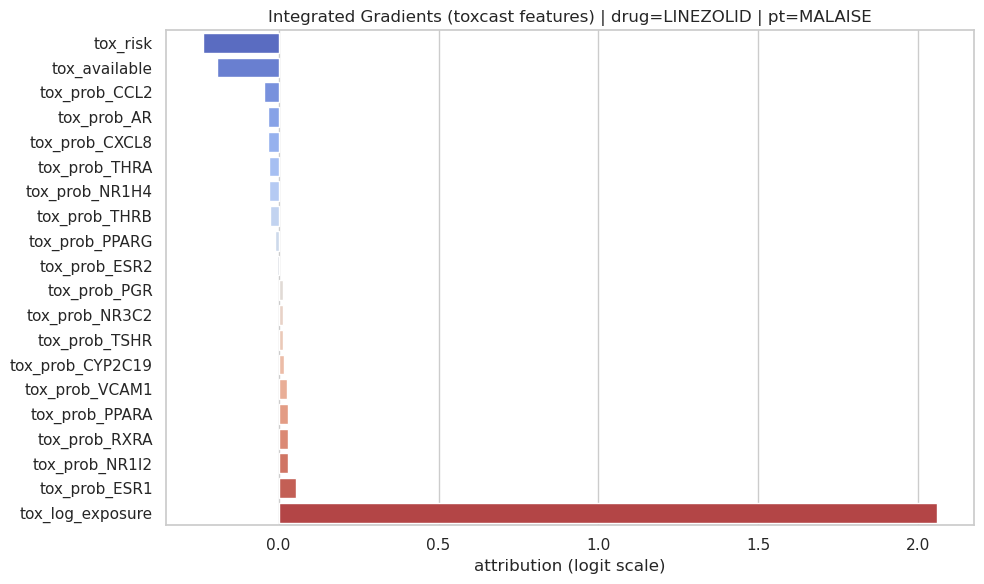

In [37]:
# --- C6) IG on toxcast feature block（展示机制层面的贡献）

import torch
import seaborn as sns
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
from scripts.train_openfda_early_warning_dl import OpenFDADeepEarlyWarningNet, _compute_numeric_features, _read_quarter_arrays  # type: ignore

sns.set_theme(style="whitegrid")

if not (OPENFDA_DL_TOXCAST_OUT.exists() or OPENFDA_DL_TOXCAST_OUT_DIFFUSED.exists()):
    print("No toxcast DL model outputs found; skip tox attribution.")
else:
    base_kind = str(OPENFDA_RL_BASE_MODEL).strip().lower()
    dl_tox_out = OPENFDA_DL_TOXCAST_OUT_DIFFUSED if TOXCAST_INCLUDE_DIFFUSED else OPENFDA_DL_TOXCAST_OUT

    ckpt = torch.load(dl_tox_out / "model.pt", map_location="cpu")
    vocab = read_json(dl_tox_out / "vocab.json")
    keep_drugs = [str(x) for x in vocab.get("drugs") or []]
    keep_pts = [str(x) for x in vocab.get("pts") or []]

    model = OpenFDADeepEarlyWarningNet(**ckpt["model_kwargs"]).to(torch.device(DEVICE))
    model.load_state_dict(ckpt["state_dict"])
    model.eval()

    pred = pd.read_csv(dl_tox_out / "top_predictions.tsv", sep="	").iloc[0]
    drug = str(pred["drug"]).strip()
    pt = str(pred["pt"]).strip()

    drug_to_idx = {d: i for i, d in enumerate(keep_drugs)}
    pt_to_idx = {p: i for i, p in enumerate(keep_pts)}

    did = int(drug_to_idx.get(drug, -1))
    pid = int(pt_to_idx.get(pt, -1))
    if did < 0 or pid < 0:
        raise ValueError("Selected (drug,pt) not in vocab; try another sample.")

    q_from = str(pred.get("q_from") or openfda_quarters[-2]).strip().lower()

    _dr, _pr, pairs_from = _read_quarter_arrays(
        counts_dir=OPENFDA_COUNTS_DIR, quarter=q_from, drug_to_idx=drug_to_idx, pt_to_idx=pt_to_idx
    )
    a = float(pairs_from.get((did << 32) | pid, 0.0))

    # pair-history lags inferred from model config
    num_feat_dim = int(ckpt["model_kwargs"].get("num_feat_dim") or 7)
    pair_history_lags = int(ckpt.get("pair_history_lags") or max(0, num_feat_dim - 7))
    a_hist_vals = []
    if int(pair_history_lags) > 0:
        q_pos = {str(q).strip().lower(): int(i) for i, q in enumerate(openfda_quarters)}.get(q_from, None)
        for lag in range(1, int(pair_history_lags) + 1):
            j = int(q_pos) - int(lag) if q_pos is not None else -1
            if j < 0:
                a_hist_vals.append(0.0)
                continue
            qh = str(openfda_quarters[int(j)]).strip().lower()
            _dr_h, _pr_h, pairs_h = _read_quarter_arrays(
                counts_dir=OPENFDA_COUNTS_DIR, quarter=qh, drug_to_idx=drug_to_idx, pt_to_idx=pt_to_idx
            )
            a_hist_vals.append(float(pairs_h.get((did << 32) | pid, 0.0)))

    total_map = total_reports.set_index("quarter")["n_reports"].astype(float).to_dict()
    total_from = float(total_map.get(q_from) or 0.0)

    d_t = torch.tensor([did], dtype=torch.long, device=torch.device(DEVICE))
    p_t = torch.tensor([pid], dtype=torch.long, device=torch.device(DEVICE))
    a_t = torch.tensor([a], dtype=torch.float32, device=torch.device(DEVICE))
    dr_t = torch.tensor([_dr[did]], dtype=torch.float32, device=torch.device(DEVICE))
    pr_t = torch.tensor([_pr[pid]], dtype=torch.float32, device=torch.device(DEVICE))
    tr_t = torch.tensor([total_from], dtype=torch.float32, device=torch.device(DEVICE))
    a_hist_t = None
    if int(pair_history_lags) > 0:
        a_hist_t = torch.tensor([a_hist_vals], dtype=torch.float32, device=torch.device(DEVICE))
    num_feat = _compute_numeric_features(a=a_t, drug_reports=dr_t, pt_reports=pr_t, total_reports=tr_t, a_hist=a_hist_t)

    feat_path = dl_tox_out / ("drug_toxcast_features_diffused.tsv" if TOXCAST_INCLUDE_DIFFUSED else "drug_toxcast_features.tsv")
    tox_df = pd.read_csv(feat_path, sep="	", dtype={"drug": str})
    tox_cols = [c for c in tox_df.columns if c != "drug"]
    tox_df = tox_df.set_index("drug")

    tox_vec = tox_df.loc[drug, tox_cols].to_numpy(dtype=np.float32) if drug in tox_df.index else np.zeros((len(tox_cols),), dtype=np.float32)
    tox_feat = torch.tensor([tox_vec], dtype=torch.float32, device=torch.device(DEVICE))

    def forward_tox(x_tox: torch.Tensor) -> torch.Tensor:
        bsz = int(x_tox.shape[0])
        d = d_t.expand(bsz)
        p = p_t.expand(bsz)
        n = num_feat.expand(bsz, -1)
        logits = model(drug_idx=d, pt_idx=p, num_feat=n, tox_feat=x_tox)
        return logits

    ig = IntegratedGradients(forward_tox)
    attr = ig.attribute(tox_feat, baselines=torch.zeros_like(tox_feat), n_steps=64)
    attr_np = attr.detach().cpu().numpy().reshape(-1)

    df = pd.DataFrame({"feature": tox_cols, "attr": attr_np})
    df["abs_attr"] = df["attr"].abs()
    show = df.sort_values("abs_attr", ascending=False).head(20).sort_values("attr")

    plt.figure(figsize=(10, 6))
    sns.barplot(data=show, x="attr", y="feature", palette="coolwarm")
    plt.title(f"Integrated Gradients (toxcast features) | drug={drug} | pt={pt}")
    plt.xlabel("attribution (logit scale)")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()


In [38]:
# --- C6) 解释性小结（便于论文写作）

print("解释性总结（可直接用于论文方法/讨论）：")
print("- 数值特征 IG：识别哪些 disproportionality/计数项在当前样本上主导了 logit。")
print("- 机制特征 IG：在 risk/targets/diffused-targets 维度上给出可操作的机制假设线索（用于后续验证与讨论）。")


解释性总结（可直接用于论文方法/讨论）：
- 数值特征 IG：识别哪些 disproportionality/计数项在当前样本上主导了 logit。
- 机制特征 IG：在 risk/targets/diffused-targets 维度上给出可操作的机制假设线索（用于后续验证与讨论）。


### C7) 肠癌（结直肠癌）研究：预测下一季度候选 (drug, PT)

本单元格会基于 **openFDA(FAERS) 早预警模型**（优先使用 RL 微调模型；若缺失则回退 DL 基线），
在最新可用季度 `q_from` 上对“结直肠癌相关药物”做 **下一季度 `q_pred` 的候选 PT 事件排序**。

你后续做实验验证时，建议优先挑选：
- `drug_reports / pt_reports` 不太低（避免极端稀疏导致不稳定）
- `current_count` 很低但 `score` 很高（典型 early-warning 场景）
- 生物学/机制上可解释、且能在你的实验体系中模拟/测量的 PT


In [39]:
# --- C7) Predict next-quarter CRC-related signals (drug -> PT)

from IPython.display import Markdown, display

# choose model: prefer val-fitted stacking ensemble if available; else fallback to single model (RL>DL)
dl_tox_out = OPENFDA_DL_TOXCAST_OUT_DIFFUSED if TOXCAST_INCLUDE_DIFFUSED else OPENFDA_DL_TOXCAST_OUT
base_kind = str(OPENFDA_RL_BASE_MODEL).strip().lower()
base_model_dir = OPENFDA_DL_OUT if base_kind == 'plain' else dl_tox_out
rl_out_dir = OPENFDA_RL_OUT_PLAIN if base_kind == 'plain' else OPENFDA_RL_OUT_TOXCAST
rl_dir = rl_out_dir if (rl_out_dir / 'model_rl.pt').exists() else None

use_ensemble = (
    (rl_dir is not None)
    and (OPENFDA_DL_OUT / 'val_eval.npz').exists()
    and (dl_tox_out / 'val_eval.npz').exists()
    and ((rl_dir / 'val_eval_rl.npz').exists() or (rl_dir / 'val_eval.npz').exists())
)

crc_out = Path('data/outputs/openfda_crc_next_quarter_crc_drugs.tsv')
crc_meta = Path('data/outputs/openfda_crc_next_quarter_crc_drugs.meta.json')
meta_ranker = Path('data/outputs/openfda_meta_ranker.json')

cmd = [
    PY,
    'scripts/predict_openfda_crc_next_quarter.py',
    '--counts-dir', str(OPENFDA_COUNTS_DIR),
    '--out-tsv', str(crc_out),
    '--out-meta', str(crc_meta),
    '--q-from', str(OPENFDA_END_QUARTER),
    '--min-drug-reports', str(int(OPENFDA_MIN_DRUG_REPORTS)),
    '--min-pt-reports', str(int(OPENFDA_MIN_PT_REPORTS)),
    '--target-mode', 'crc_drugs',
    '--top-n', '200',
    '--device', str(DEVICE),
]
if use_ensemble:
    cmd += [
        '--ensemble-dl-dir', str(OPENFDA_DL_OUT),
        '--ensemble-toxcast-dir', str(dl_tox_out),
        '--ensemble-rl-dir', str(rl_dir),
    ]
    if meta_ranker.exists():
        cmd += ['--meta-ranker', str(meta_ranker)]
else:
    model_dir = rl_dir if rl_dir is not None else base_model_dir
    cmd += ['--model-dir', str(model_dir)]
run(cmd)

display(Markdown(f'CRC next-quarter predictions saved to `{crc_out}` (meta: `{crc_meta}`)'))
crc_df = pd.read_csv(crc_out, sep='	')
display(Markdown('### Top (drug, PT) pairs'))
display(crc_df.head(30))

# 按 drug 聚合：避免 top 列表被单一化合物“刷屏”而看起来像只展现了 1 个化合物
per_drug_topk = 5
tmp = crc_df.sort_values(['drug', 'score'], ascending=[True, False]).groupby('drug', sort=False).head(per_drug_topk)
drug_summary = (
    tmp.groupby('drug', as_index=False)
    .agg(
        max_score=('score', 'max'),
        n_top_pairs=('pt', 'nunique'),
        top_pts=('pt', lambda s: '; '.join(list(s)[:per_drug_topk])),
    )
    .sort_values('max_score', ascending=False)
)
display(Markdown('### Top drugs (aggregated across PTs)'))
display(drug_summary.head(30))

# --- 生成最终风险报告（含实验建议）
report_md = Path('data/outputs/openfda_crc_risk_report.md')
ind_tsv = Path('data/outputs/openfda_05_25_drug_disease_adr_sample.tsv')
cmd = [
    PY,
    'scripts/generate_openfda_crc_risk_report.py',
    '--predictions-tsv', str(crc_out),
    '--out-md', str(report_md),
    '--top-drugs', '15',
    '--top-pts-per-drug', '8',
]
if ind_tsv.exists():
    cmd += ['--drug-disease-adr-tsv', str(ind_tsv)]
run(cmd)
display(Markdown(f'### Risk report saved to `{report_md}`'))



$ /home/xuchengjie/miniconda3/envs/toxcast-risk/bin/python scripts/predict_openfda_crc_next_quarter.py --counts-dir data/processed/openfda_counts_2004q1_2025q3 --out-tsv data/outputs/openfda_crc_next_quarter_crc_drugs.tsv --out-meta data/outputs/openfda_crc_next_quarter_crc_drugs.meta.json --q-from 2025q3 --min-drug-reports 100 --min-pt-reports 100 --target-mode crc_drugs --top-n 200 --device cuda --ensemble-dl-dir data/models/openfda_ew_dl_2020q4_2025q3_threshold_next1_hist4_embint1_bce_bpr_trainlast8 --ensemble-toxcast-dir data/models/openfda_ew_dl_toxcast_2020q4_2025q3_threshold_next1_hist4_embint1_bce_bpr_trainlast8 --ensemble-rl-dir data/models/openfda_policy_rl_toxcast_2020q4_2025q3_threshold_next1_hist4_embint1_bce_bpr_trainlast8 --meta-ranker data/outputs/openfda_meta_ranker.json
[crc-next-quarter] wrote: data/outputs/openfda_crc_next_quarter_crc_drugs.tsv (top_n=200, candidates=572)
[crc-next-quarter] wrote: data/outputs/openfda_crc_next_quarter_crc_drugs.meta.json


CRC next-quarter predictions saved to `data/outputs/openfda_crc_next_quarter_crc_drugs.tsv` (meta: `data/outputs/openfda_crc_next_quarter_crc_drugs.meta.json`)

### Top (drug, PT) pairs

rank  q_from  q_pred  drug_idx  pt_idx                      drug  \
0      1  2025q3  2025q4       204     118              CAPECITABINE   
1      2  2025q3  2025q4       308     118               BEVACIZUMAB   
2      3  2025q3  2025q4       115      54  IRINOTECAN HYDROCHLORIDE   
3      4  2025q3  2025q4       308    1294               BEVACIZUMAB   
4      5  2025q3  2025q4        37     118               TRASTUZUMAB   
5      6  2025q3  2025q4       204     167              CAPECITABINE   
6      7  2025q3  2025q4       331     249                IRINOTECAN   
7      8  2025q3  2025q4       205     344               OXALIPLATIN   
8      9  2025q3  2025q4       205    1294               OXALIPLATIN   
9     10  2025q3  2025q4      1186    1294          BEVACIZUMAB-TNJN   
10    11  2025q3  2025q4       221     167              FLUOROURACIL   
11    12  2025q3  2025q4       205     118               OXALIPLATIN   
12    13  2025q3  2025q4       205     167               OXALIPLATIN   
13    14  2025q3  2025q4       331     159                IRINOTECAN   
14    15  2025q3  2025q4       205     999               OXALIPLATIN   
15    16  2025q3  2025q4       205     617               OXALIPLATIN   
16    17  2025q3  2025q4       205    1928               OXALIPLATIN   
17    18  2025q3  2025q4       204     344              CAPECITABINE   
18    19  2025q3  2025q4      2322     190                LEUCOVORIN   
19    20  2025q3  2025q4       331     167                IRINOTECAN   
20    21  2025q3  2025q4       331      77                IRINOTECAN   
21    22  2025q3  2025q4       221     999              FLUOROURACIL   
22    23  2025q3  2025q4       204    1294              CAPECITABINE   
23    24  2025q3  2025q4       205     829               OXALIPLATIN   
24    25  2025q3  2025q4       204      17              CAPECITABINE   
25    26  2025q3  2025q4       205    1558               OXALIPLATIN   
26    27  2025q3  2025q4       308     753               BEVACIZUMAB   
27    28  2025q3  2025q4      2322     427                LEUCOVORIN   
28    29  2025q3  2025q4       221     118              FLUOROURACIL   
29    30  2025q3  2025q4      2322     167                LEUCOVORIN   

                pt     score  current_count  drug_reports  ...  target_mode  \
0           NAUSEA  0.999921           80.0        1072.0  ...    crc_drugs   
1           NAUSEA  0.999866           63.0        2448.0  ...    crc_drugs   
2             RASH  0.999853            0.0         392.0  ...    crc_drugs   
3       HYPOACUSIS  0.999812            0.0        2448.0  ...    crc_drugs   
4           NAUSEA  0.999804           35.0        1393.0  ...    crc_drugs   
5        DYSPEPSIA  0.999797            0.0        1072.0  ...    crc_drugs   
6        DYSPHAGIA  0.999785            0.0         457.0  ...    crc_drugs   
7   RHABDOMYOLYSIS  0.999752            0.0        1716.0  ...    crc_drugs   
8       HYPOACUSIS  0.999751            0.0        1716.0  ...    crc_drugs   
9       HYPOACUSIS  0.999751            0.0        1642.0  ...    crc_drugs   
10       DYSPEPSIA  0.999751            0.0        1462.0  ...    crc_drugs   
11          NAUSEA  0.999750          104.0        1716.0  ...    crc_drugs   
12       DYSPEPSIA  0.999748            0.0        1716.0  ...    crc_drugs   
13        HEADACHE  0.999747            0.0         457.0  ...    crc_drugs   
14         AGEUSIA  0.999734            0.0        1716.0  ...    crc_drugs   
15            COMA  0.999701            0.0        1716.0  ...    crc_drugs   
16        DIPLOPIA  0.999687            0.0        1716.0  ...    crc_drugs   
17  RHABDOMYOLYSIS  0.999672            0.0        1072.0  ...    crc_drugs   
18            FALL  0.999657            0.0         427.0  ...    crc_drugs   
19       DYSPEPSIA  0.999639            0.0         457.0  ...    crc_drugs   
20         MYALGIA  0.999631            0.0         457.0  ...    crc_drugs   
21         AGEUSIA  0.999628     

### Top drugs (aggregated across PTs)

drug  max_score  n_top_pairs  \
2               CAPECITABINE   0.999921            5   
0                BEVACIZUMAB   0.999866            5   
6   IRINOTECAN HYDROCHLORIDE   0.999853            5   
10               TRASTUZUMAB   0.999804            5   
5                 IRINOTECAN   0.999785            5   
9                OXALIPLATIN   0.999752            5   
1           BEVACIZUMAB-TNJN   0.999751            5   
4               FLUOROURACIL   0.999751            5   
7                 LEUCOVORIN   0.999657            5   
3                  CETUXIMAB   0.999194            5   
8         LEUCOVORIN CALCIUM   0.997967            5   

                                              top_pts  
2   NAUSEA; DYSPEPSIA; RHABDOMYOLYSIS; HYPOACUSIS;...  
0         NAUSEA; HYPOACUSIS; LYMPHOMA; AGEUSIA; RASH  
6                 RASH; DIPLOPIA; SHOCK; COMA; ECZEMA  
10  NAUSEA; RHABDOMYOLYSIS; LYMPHOMA; EYELID OEDEM...  
5       DYSPHAGIA; HEADACHE; DYSPEPSIA; MYALGIA; FALL  
9   RHABDOMYOLYSIS; HYPOACUSIS; NAUSEA; DYSPEPSIA;...  
1   HYPOACUSIS; NAUSEA; AGEUSIA; RHABDOMYOLYSIS; RASH  
4      DYSPEPSIA; AGEUSIA; NAUSEA; DIPLOPIA; LYMPHOMA  
7          FALL; OEDEMA; DYSPEPSIA; MYALGIA; DIPLOPIA  
3        COMA; DYSPHAGIA; EPILEPSY; SHOCK; HAEMOLYSIS  
8   DYSPEPSIA; NAUSEA; ALOPECIA; EYELID OEDEMA; SHOCK


$ /home/xuchengjie/miniconda3/envs/toxcast-risk/bin/python scripts/generate_openfda_crc_risk_report.py --predictions-tsv data/outputs/openfda_crc_next_quarter_crc_drugs.tsv --out-md data/outputs/openfda_crc_risk_report.md --top-drugs 15 --top-pts-per-drug 8 --drug-disease-adr-tsv data/outputs/openfda_05_25_drug_disease_adr_sample.tsv
[risk-report] wrote: data/outputs/openfda_crc_risk_report.md


### Risk report saved to `data/outputs/openfda_crc_risk_report.md`

## D) 产物索引（用于论文复现与补充材料）

- ToxCast/CTX bundle：`data/models/toxcast_risk_target_bundle/`
- SIDER 数据：`data/processed/sider/`
- SIDER baseline 模型：`data/models/sider_adr_pt/`
- SIDER 机制增强模型：`data/models/sider_adr_pt_toxcast/` 或 `data/models/sider_adr_pt_toxcast_diffused/`
- openFDA 季度计数：`data/processed/openfda_counts_<start>_<end>/`（对应 `OPENFDA_COUNTS_DIR`）
- openFDA 深度学习模型：`data/models/openfda_ew_dl_<start>_<end>/`（对应 `OPENFDA_DL_OUT`，含 `test_eval.npz` 与 `embeddings.npz`）
- openFDA 机制增强深度模型：`data/models/openfda_ew_dl_toxcast_<start>_<end>/`（或 diffused 版本，对应 `OPENFDA_DL_TOXCAST_OUT*`，包含 drug-level toxcast 特征缓存）
- openFDA 强化学习微调：`data/models/openfda_policy_rl_<plain|toxcast>_<start>_<end>/`（对应 `OPENFDA_RL_OUT_*`，含 `test_eval_rl.npz` 与 `top_predictions_rl.tsv`）

建议在论文中报告并对比：
- SIDER：baseline vs mechanism-informed（以及可选 diffused）的 micro-AUROC / micro-AUPRC
- openFDA：DL vs DL+ToxCast vs RL 的 AUROC / AUPRC / Precision@K，并配合 rolling backtest 展示随时间的稳定性


## E) 论文插图包（自动导出）

本节会基于已训练的模型与落盘的评估结果，自动导出一组可直接用于论文/补充材料的图表（含方法示意图、对照曲线、rolling backtest 与诊断图等），并保存为 PNG/PDF。



$ /home/xuchengjie/miniconda3/envs/toxcast-risk/bin/python scripts/export_mechsignal_figures.py --out-dir data/figures/mechsignal --formats png,pdf --stack-max-points 200000 --platt-max-points 200000 --sider-baseline-dir data/models/sider_adr_pt --sider-toxcast-dir data/models/sider_adr_pt_toxcast --openfda-dl-dir data/models/openfda_ew_dl_2020q4_2025q3_threshold_next1_hist4_embint1_bce_bpr_trainlast8 --openfda-toxcast-dir data/models/openfda_ew_dl_toxcast_2020q4_2025q3_threshold_next1_hist4_embint1_bce_bpr_trainlast8 --openfda-rl-dir data/models/openfda_policy_rl_toxcast_2020q4_2025q3_threshold_next1_hist4_embint1_bce_bpr_trainlast8 --openfda-rolling-path data/outputs/openfda_rolling_metrics.tsv
/media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/JHM/scripts/export_mechsignal_figures.py:1825: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df.loc[~mapped, "tox_risk"].astype(float), ax=ax[1], label="u

Figure index: `data/figures/mechsignal/figure_index.tsv`

figure  \
0                  fig01_mechsignal_pipeline   
1                   fig02_openfda_model_arch   
2                    fig03_rl_precision_at_k   
3                fig10_sider_training_curves   
4                   fig11_sider_micro_curves   
5               fig12_sider_per_label_deltas   
6                fig13_sider_per_label_auroc   
7                  fig14_sider_label_support   
8              fig20_openfda_training_curves   
9                    fig21_openfda_rl_curves   
10                 fig22_openfda_test_curves   
11              fig23_openfda_precision_at_k   
12               fig27_openfda_embedding_pca   
13              fig28_openfda_count_dynamics   
14  fig29_openfda_top_prediction_composition   
15                  fig31_openfda_gains_lift   
16            fig24_openfda_rolling_backtest   
17        fig25_openfda_backtest_diagnostics   
18      fig30_openfda_backtest_distributions   
19                    fig26_toxcast_coverage   

                                              caption  \
0   MechSignal 总览示意图：体外（ToxCast/CTX）→ 机制表征（risk/ta...   
1   openFDA 早预警模型结构示意：drug/PT embedding + 数值特征（计数与...   
2   RL 排序优化示意：将每个季度过渡视为一个环境，基于当前模型对候选集合打分，从策略分布中无放...   
3   SIDER 训练曲线：对比 baseline 与机制增强模型的训练损失（loss）与验证 m...   
4   SIDER 测试集 micro‑PR / micro‑ROC：将所有标签展开后计算整体 PR...   
5   SIDER 按标签（PT）逐项对比：机制特征加入后，各 PT 的 AUPRC 变化（ΔAUP...   
6   SIDER 按标签（PT）逐项 AUROC 对比：baseline vs 机制增强的散点图与...   
7   SIDER 标签支持度（train）：展示每个 PT 覆盖的药物数（#drugs per P...   
8   openFDA 早预警训练曲线：比较 DL 与 DL+Mech 的训练损失、验证 AUPRC...   
9   openFDA RL 微调曲线：展示策略梯度训练过程中的平均奖励（reward）与验证 pr...   
10  openFDA 测试过渡（test transition）综合评估：PR/ROC/校准曲线与...   
11  openFDA 测试过渡 Precision@K 曲线：对比 DL、DL+Mech、RL 以...   
12  openFDA 模型 embedding 的二维投影（PCA，随机子采样）：分别对 drug...   
13  openFDA 标签动力学（评估样本）：对比负例/正例在当前季度计数 a 与下一季度计数 a...   
14  Top‑N 预测列表的组成：统计排名前 top‑2000 的信号中最常出现的 PT 与 dr...   
15  排序效用曲线（test transition）：横轴为检查的 top‑fraction（候选...   
16  openFDA 滚动回测（rolling backtest）：沿时间逐季度过渡评估，展示 A...   
17  回测诊断散点：将 AUPRC 与正例比例（类不均衡）关联；将 Precision@K 与候选...   
18  回测指标分布：对所有季度过渡的 AUPRC 与 Precision@K 做直方图汇总，用于报...   
19  ToxCast/CTX 机制特征覆盖度：统计 openFDA 词表中有多少药物可以映射到机制...   

                                             data_tsv  
0                                                 NaN  
1                                                 NaN  
2                                                 NaN  
3         figure_data/fig10_sider_training_curves.tsv  
4            figure_data/fig11_sider_micro_curves.tsv  
5        figure_data/fig12_sider_per_label_deltas.tsv  
6         figure_data/fig13_sider_per_label_auroc.tsv  
7           figure_data/fig14_sider_label_support.tsv  
8       figure_data/fig20_openfda_training_curves.tsv  
9             figure_data/fig21_openfda_rl_curves.tsv  
10          figure_data/fig22_openfda_test_curves.tsv  
11       figure_data/fig23_openfda_precision_at_k.tsv  
12        figure_data/fig27_openfda_embedding_pca.tsv  
13       figure_data/fig28_openfda_count_dynamics.tsv  
14  figure_data/fig29_openfda_top_prediction_compo...  
15           figure_data/fig31_openfda_gains_lift.tsv  
16     figure_data/fig24_openfda_rolling_backtest.tsv  
17  figure_data/fig25_openfda_backtest_diagnostics...  
18  figure_data/fig30_openfda_backtest_distributio...  
19             figure_data/fig26_toxcast_coverage.tsv

Generated `20` PNG figures under `data/figures/mechsignal`

`fig01_mechsignal_pipeline.png`

`fig02_openfda_model_arch.png`

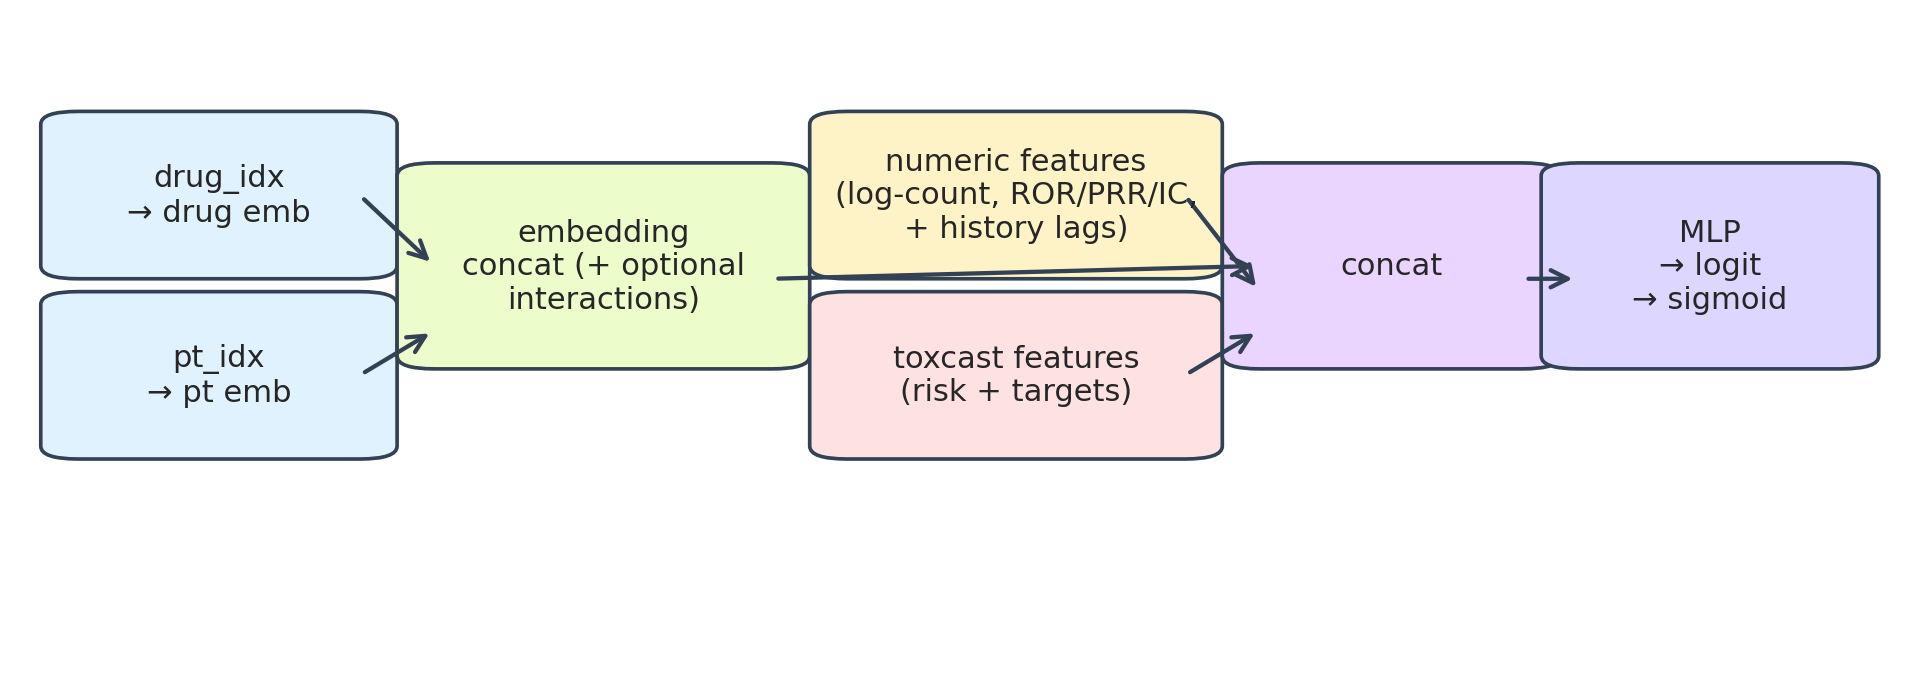

`fig03_rl_precision_at_k.png`

`fig10_sider_training_curves.png`

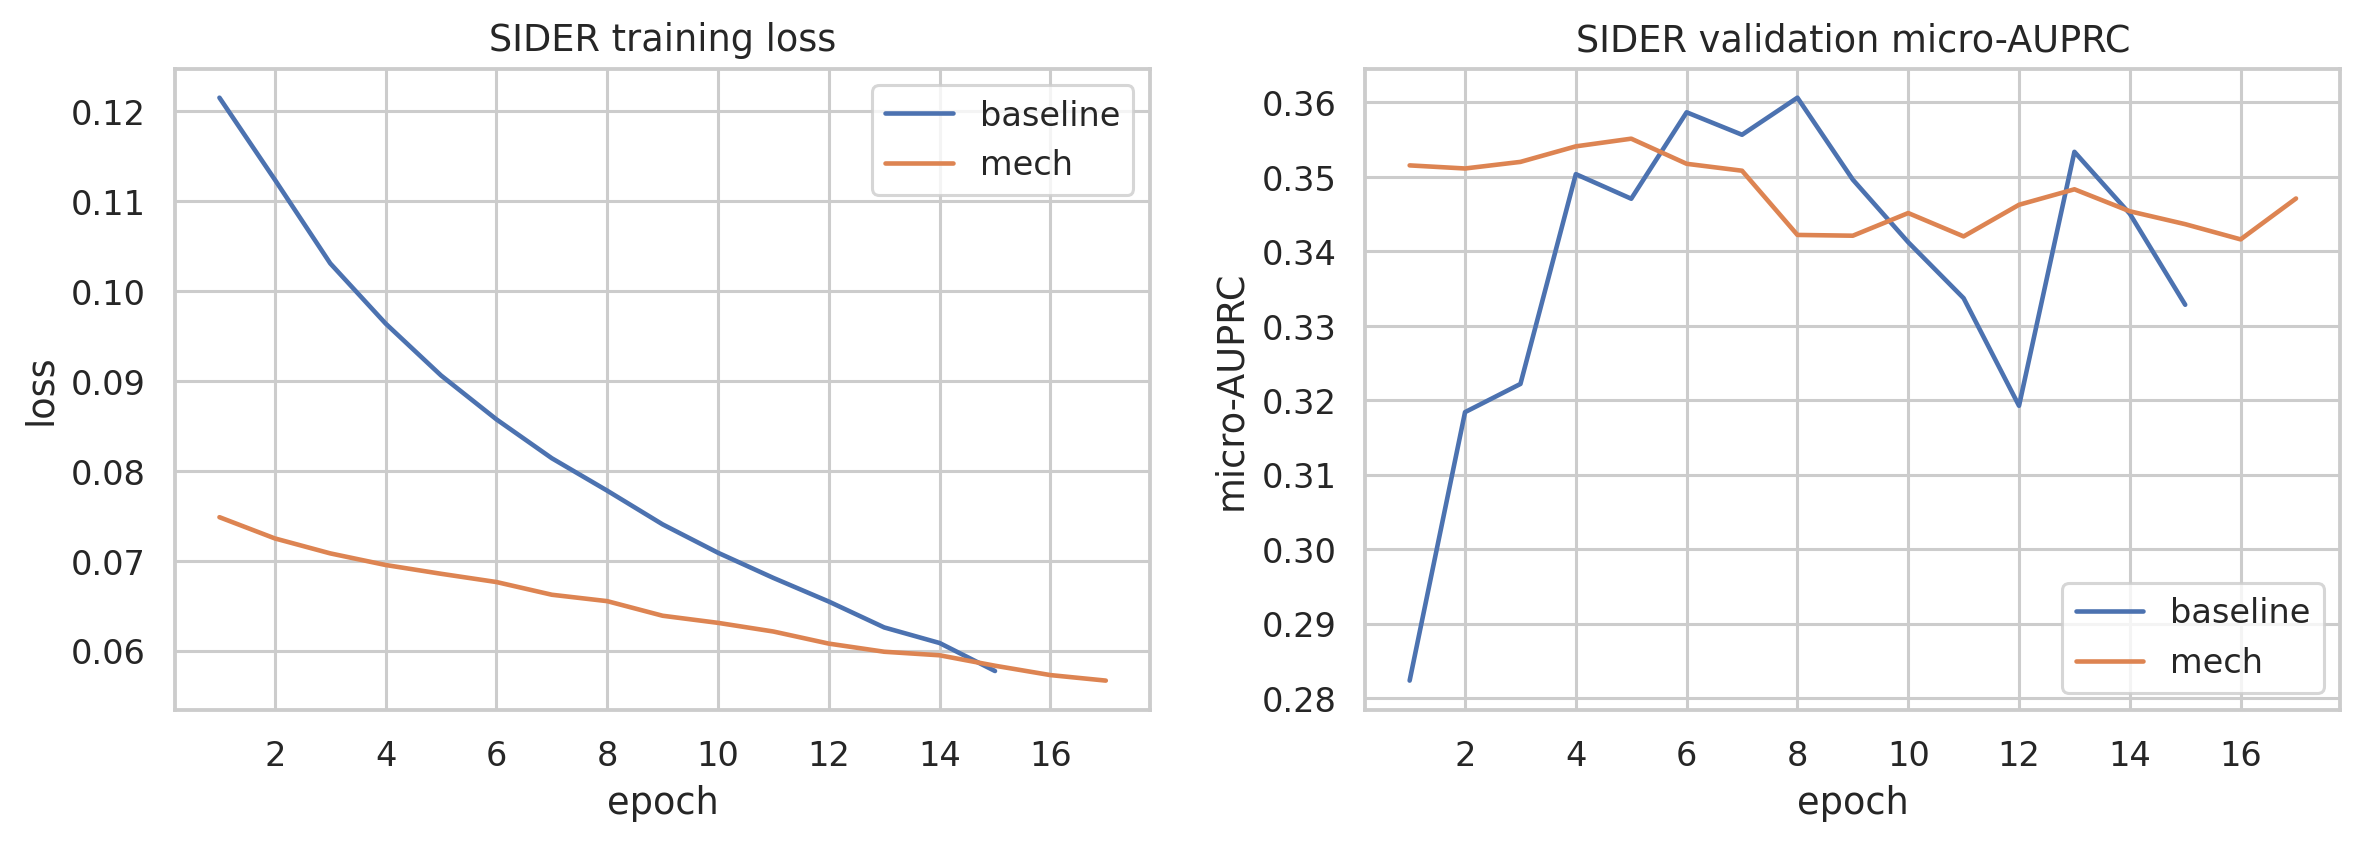

`fig11_sider_micro_curves.png`

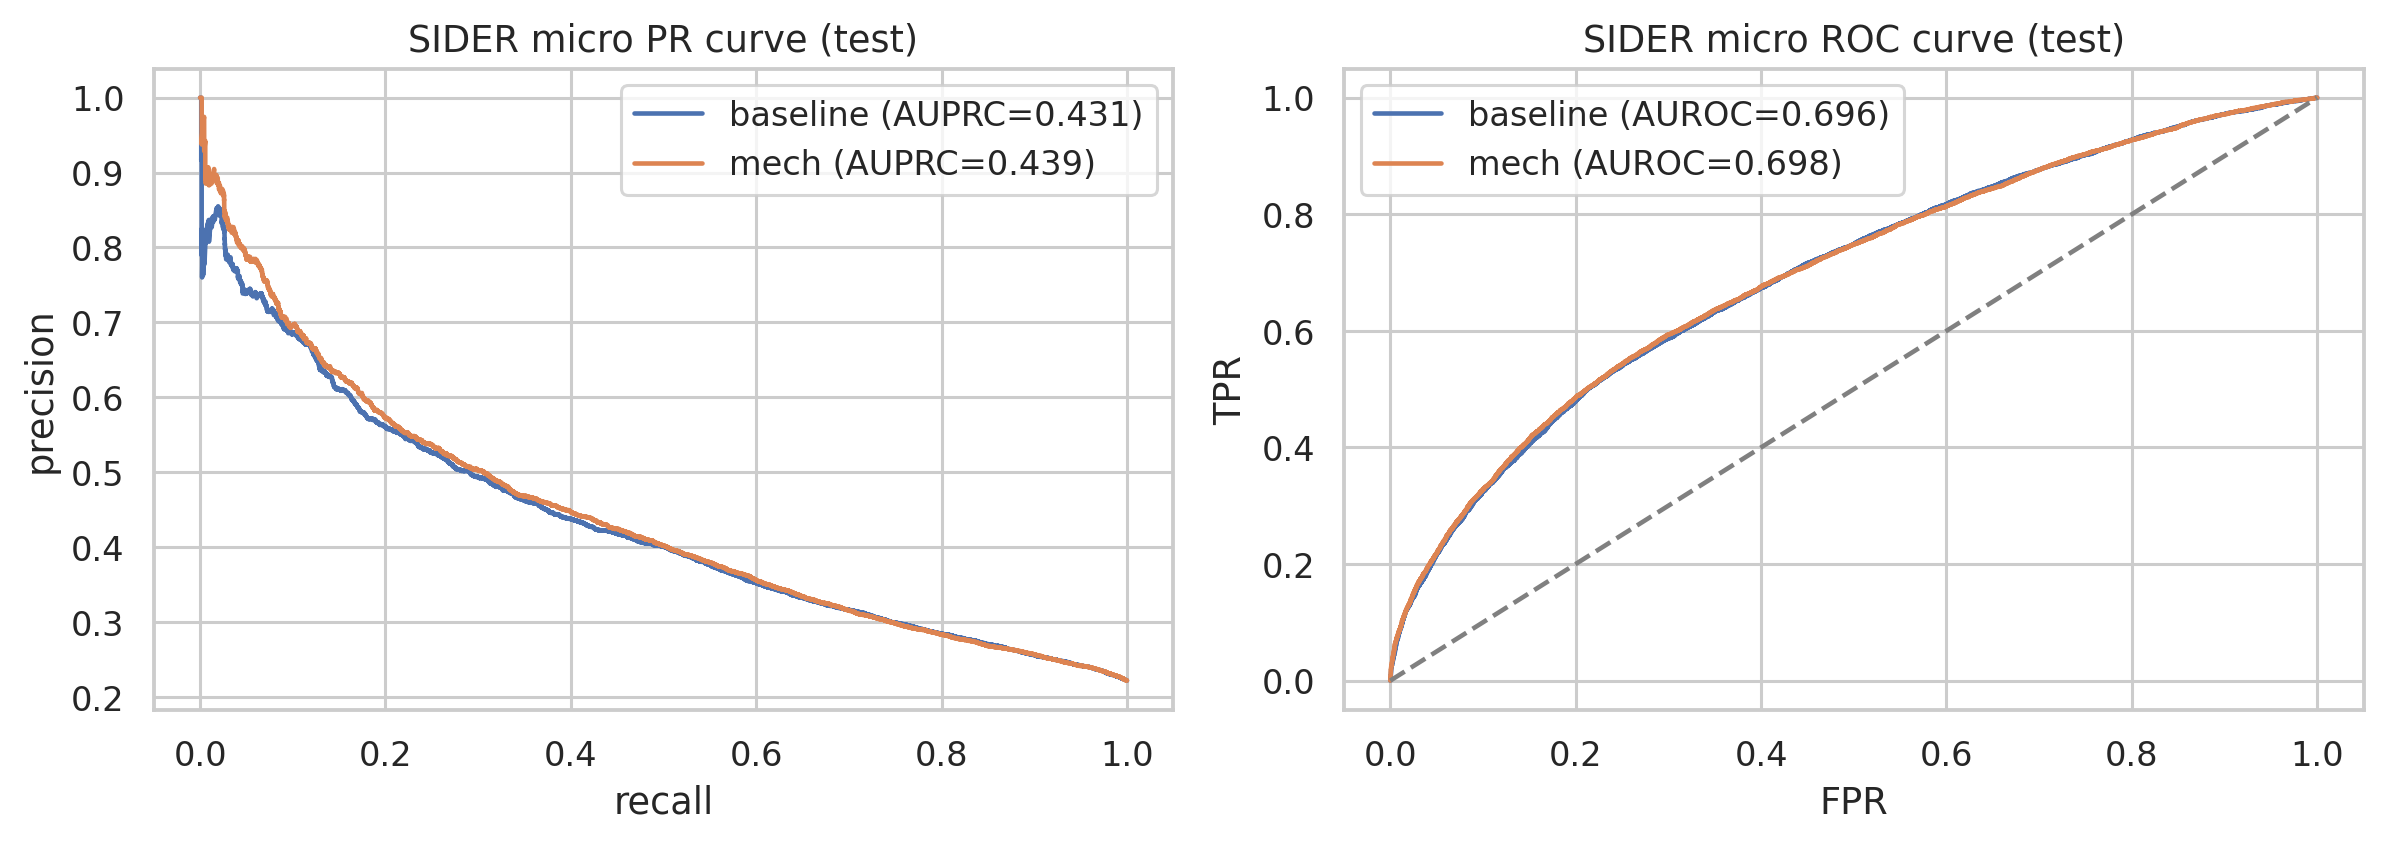

`fig12_sider_per_label_deltas.png`

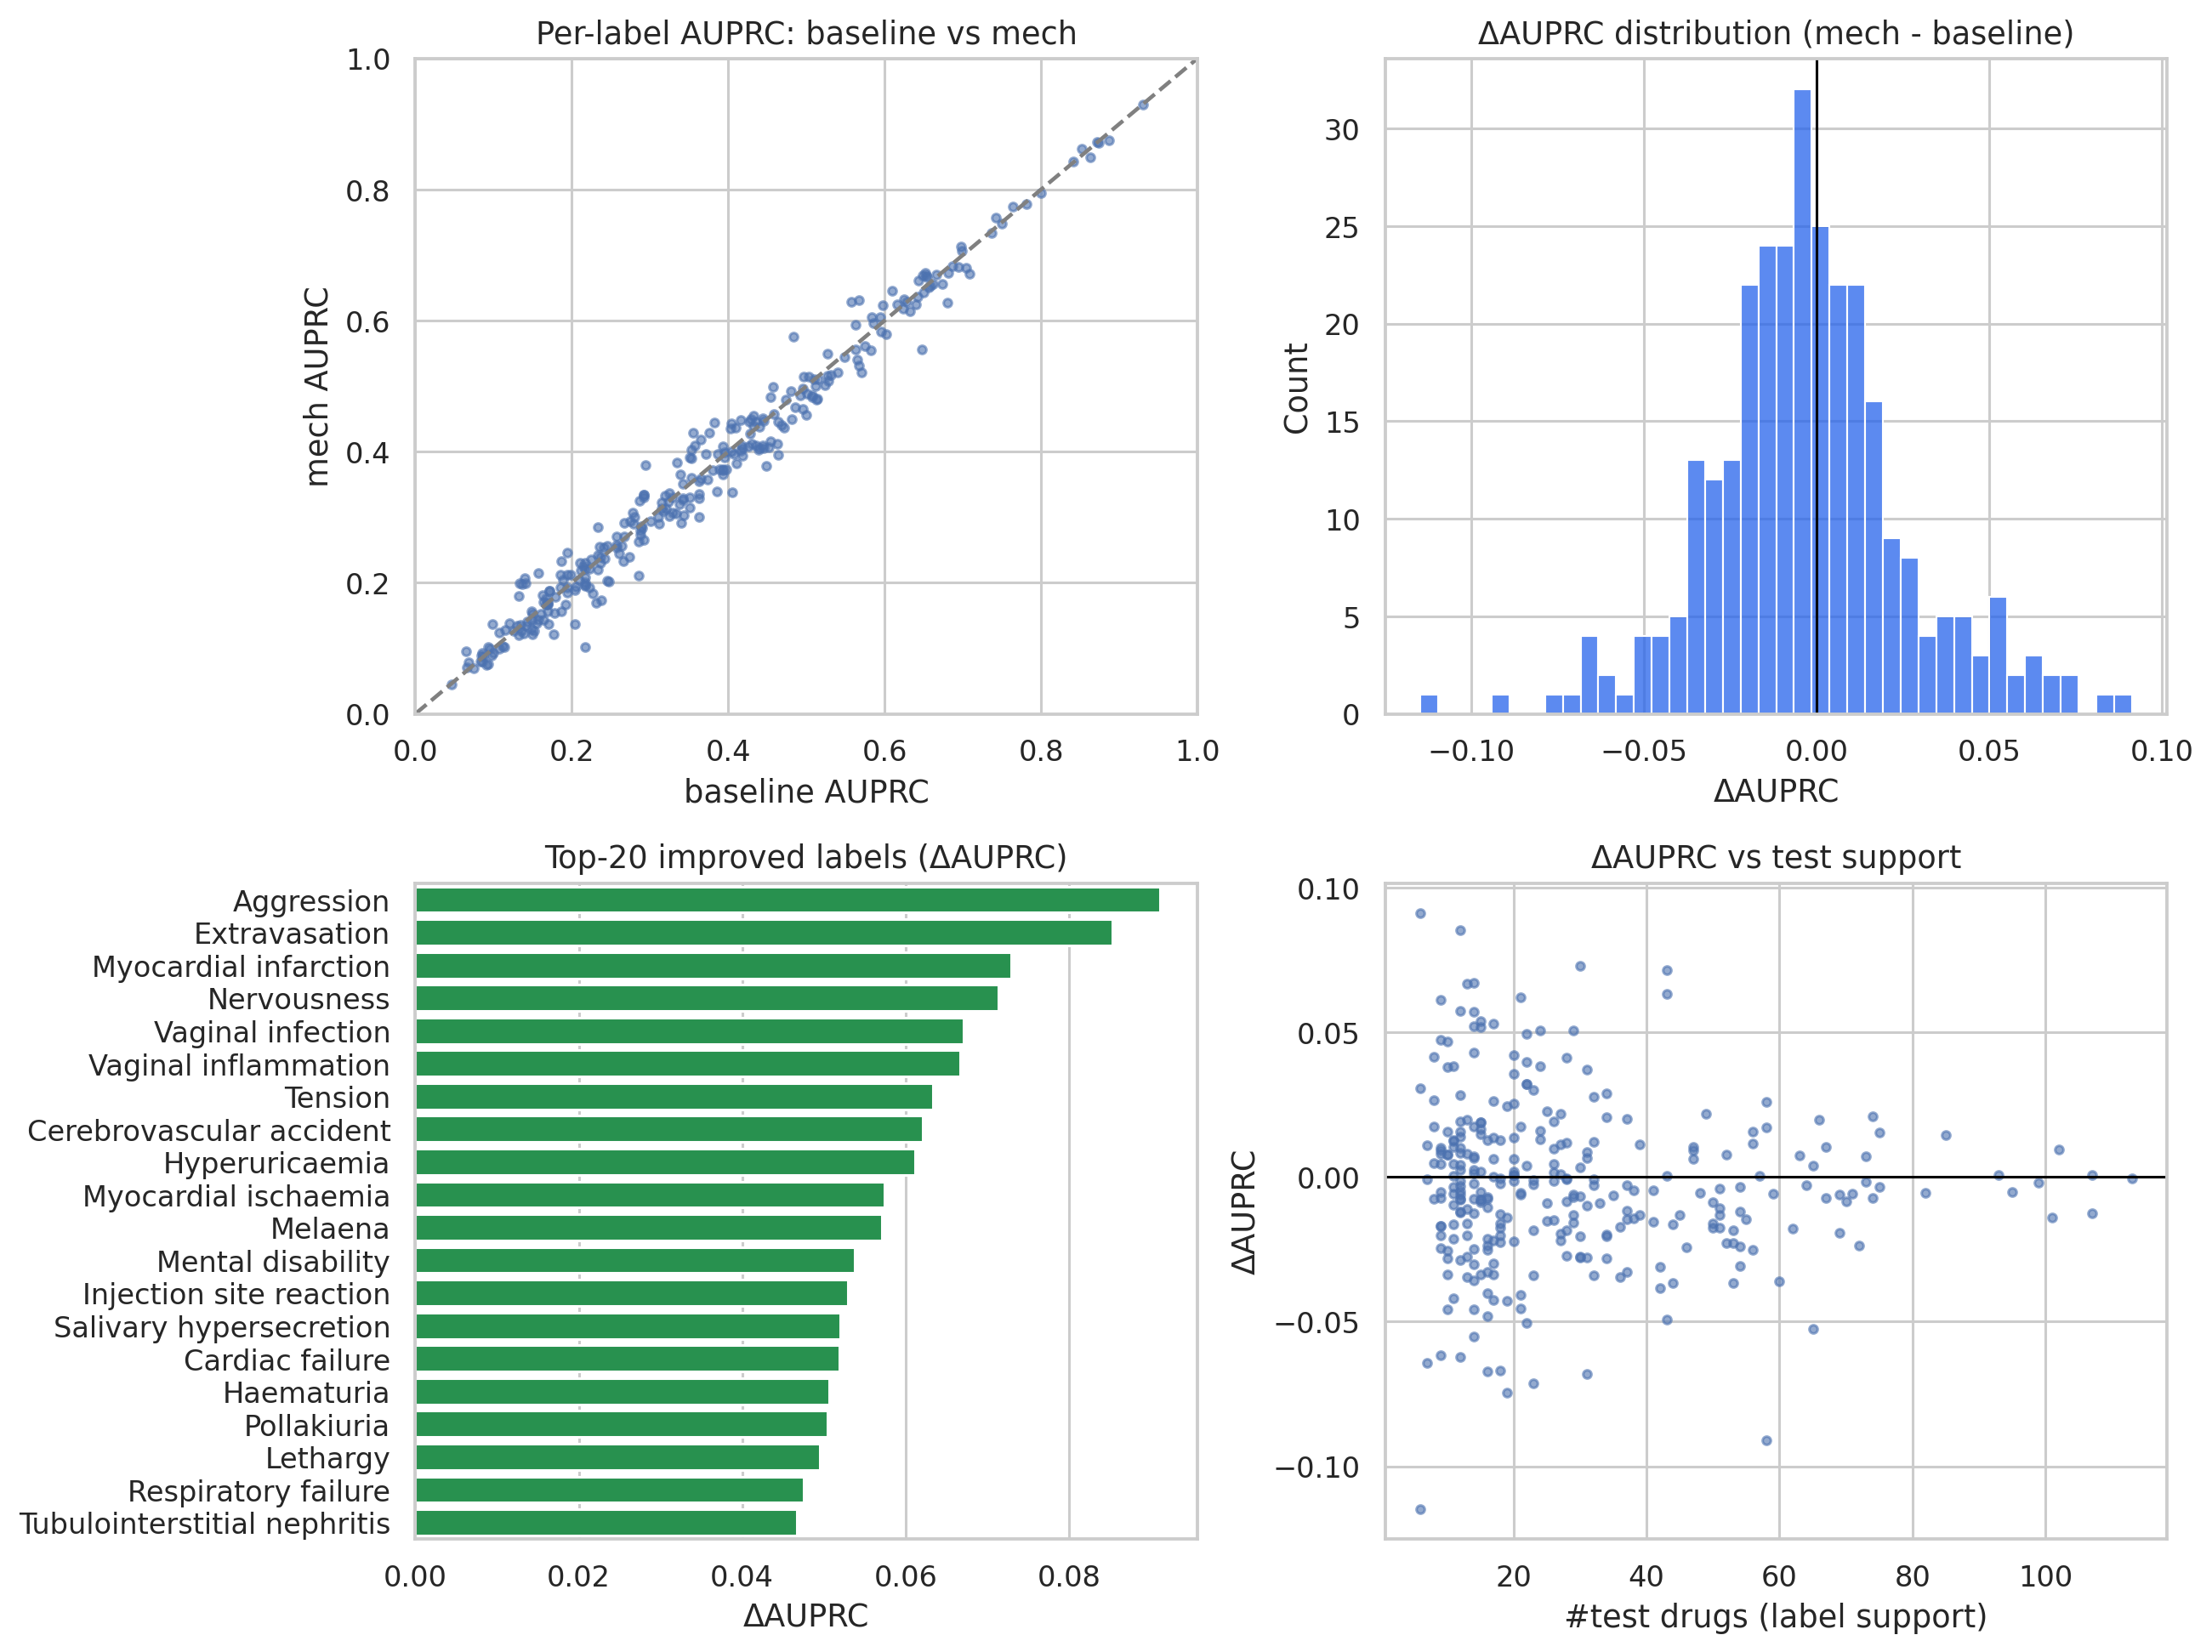

`fig13_sider_per_label_auroc.png`

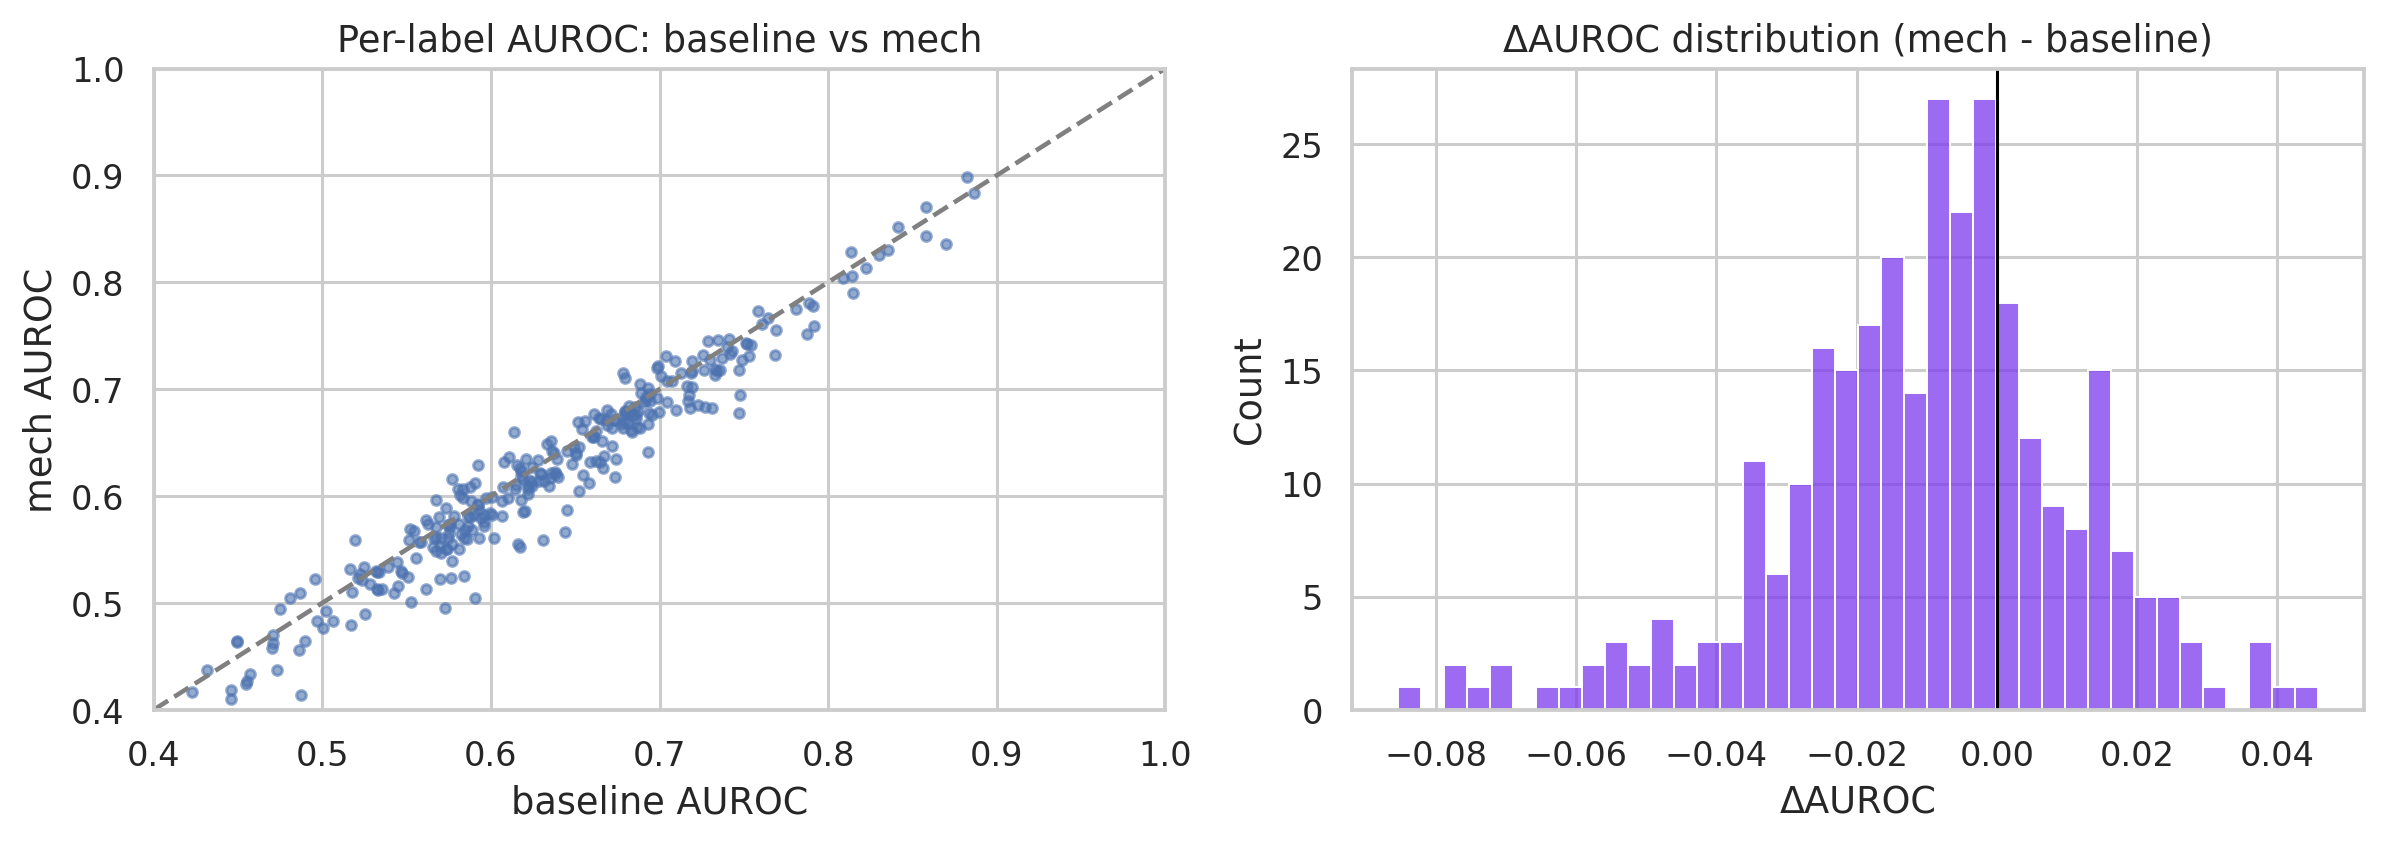

`fig14_sider_label_support.png`

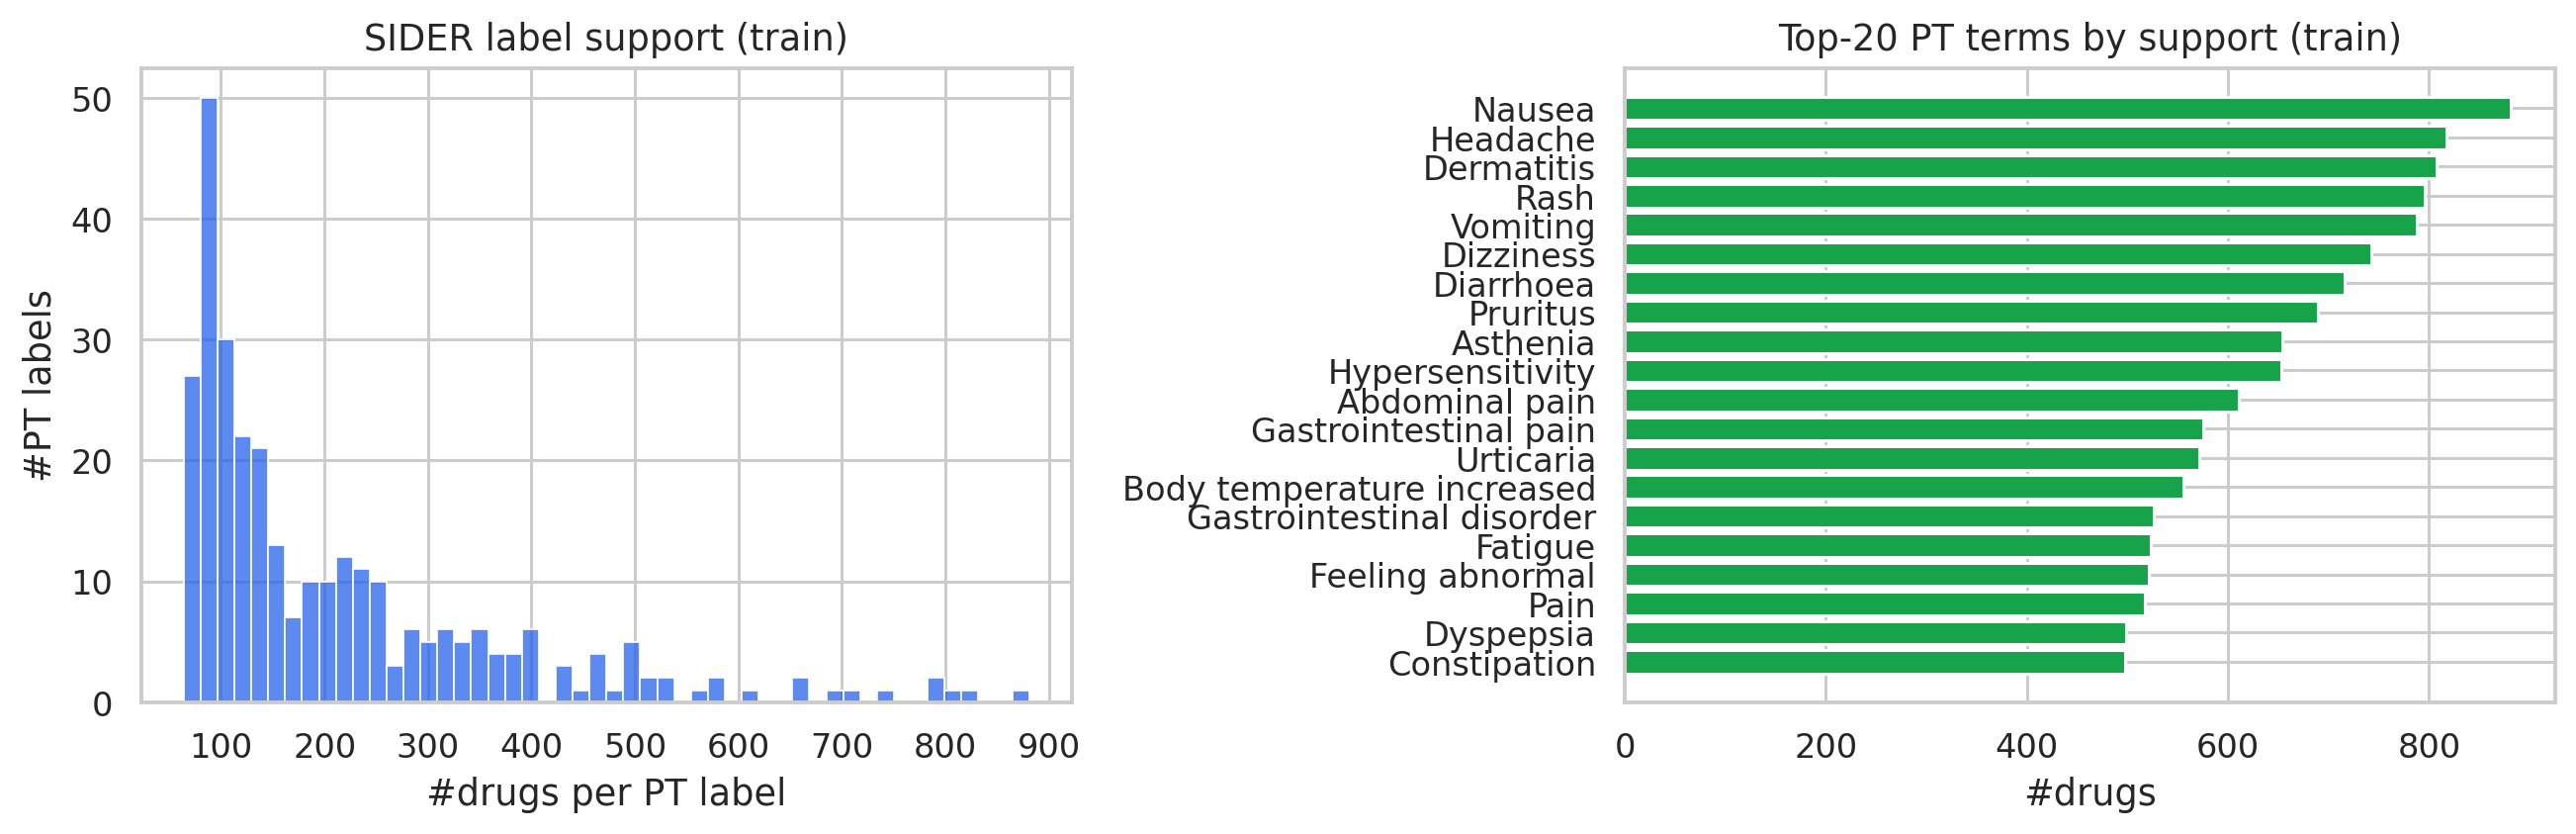

`fig20_openfda_training_curves.png`

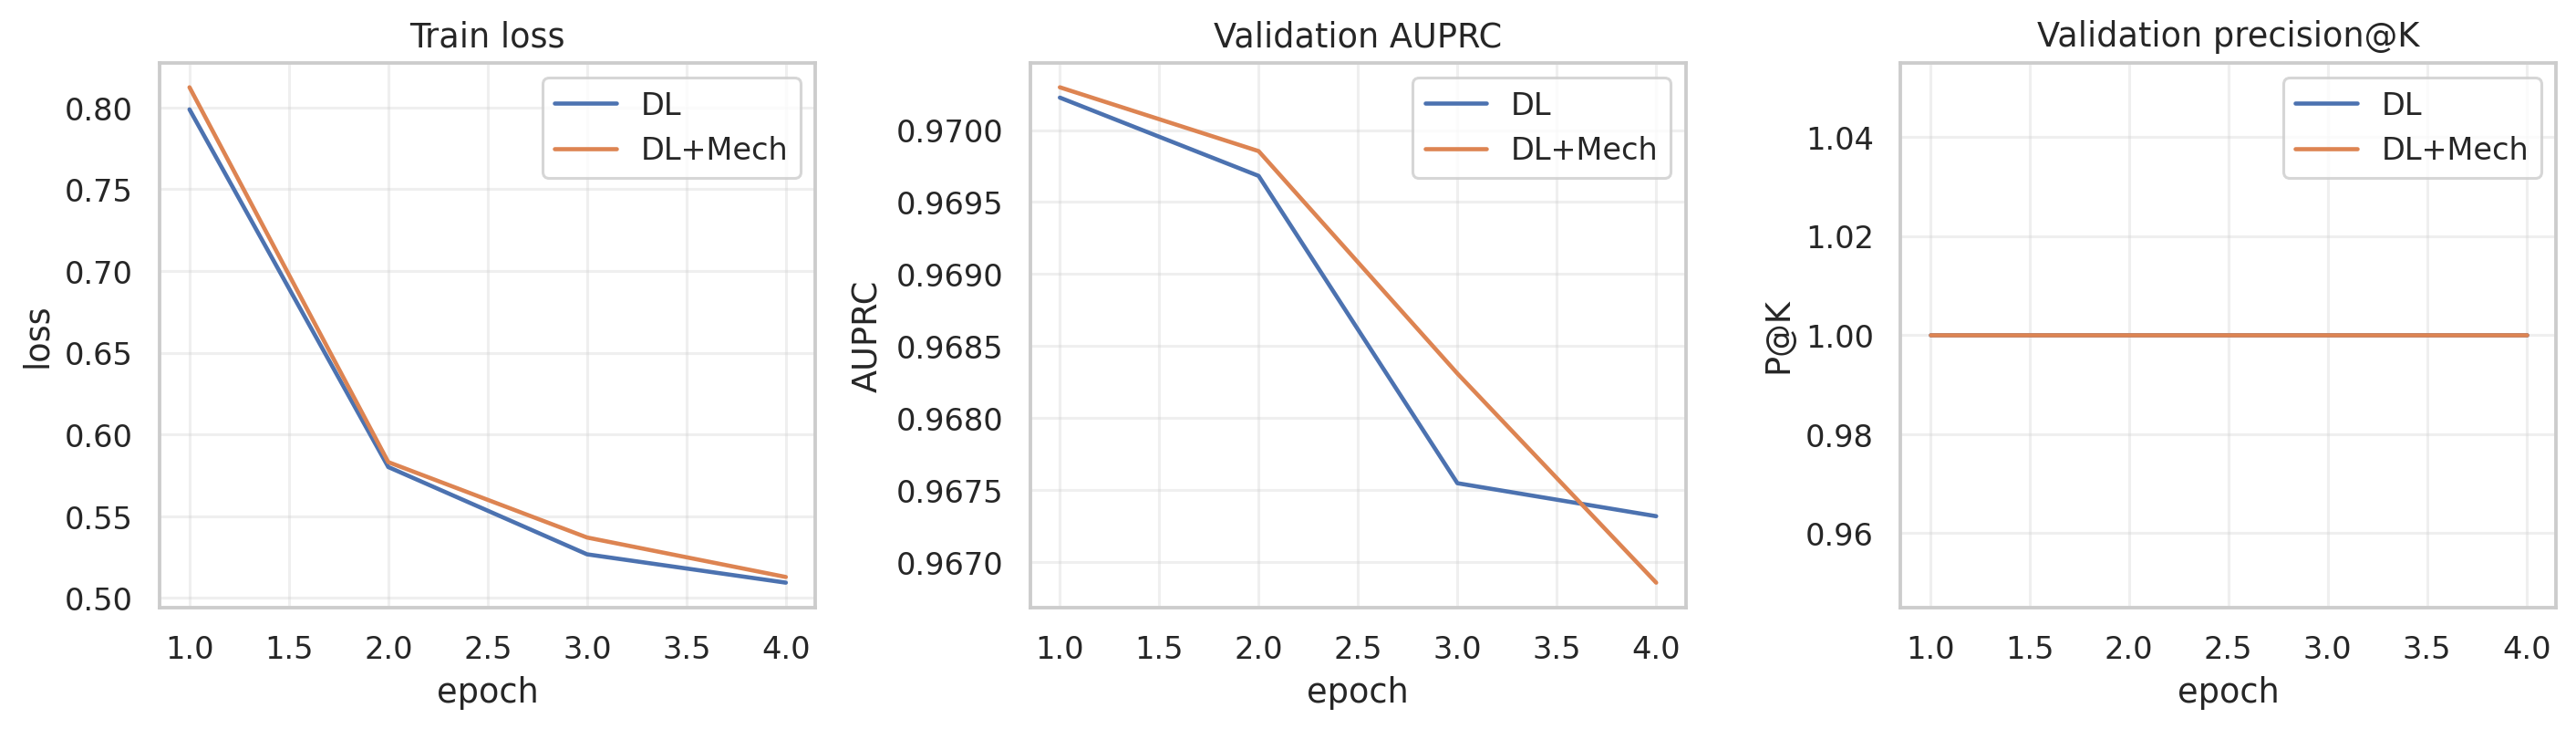

`fig21_openfda_rl_curves.png`

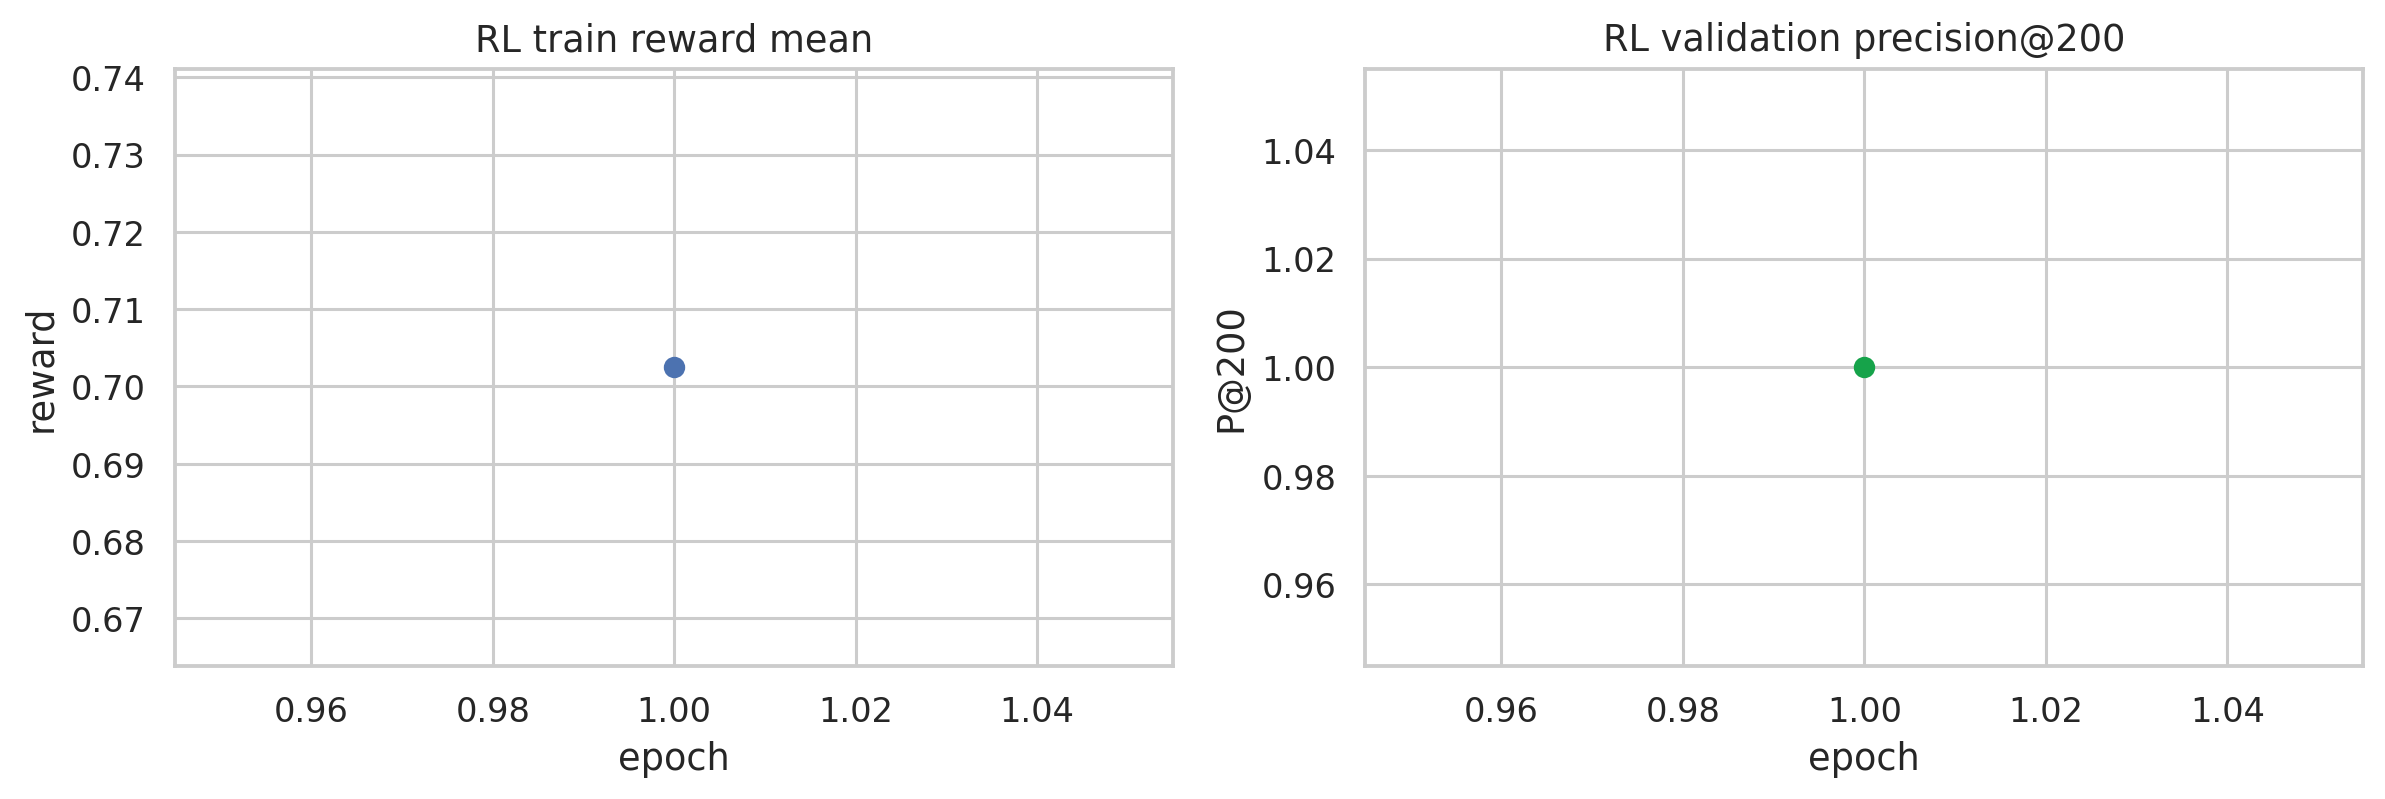

`fig22_openfda_test_curves.png`

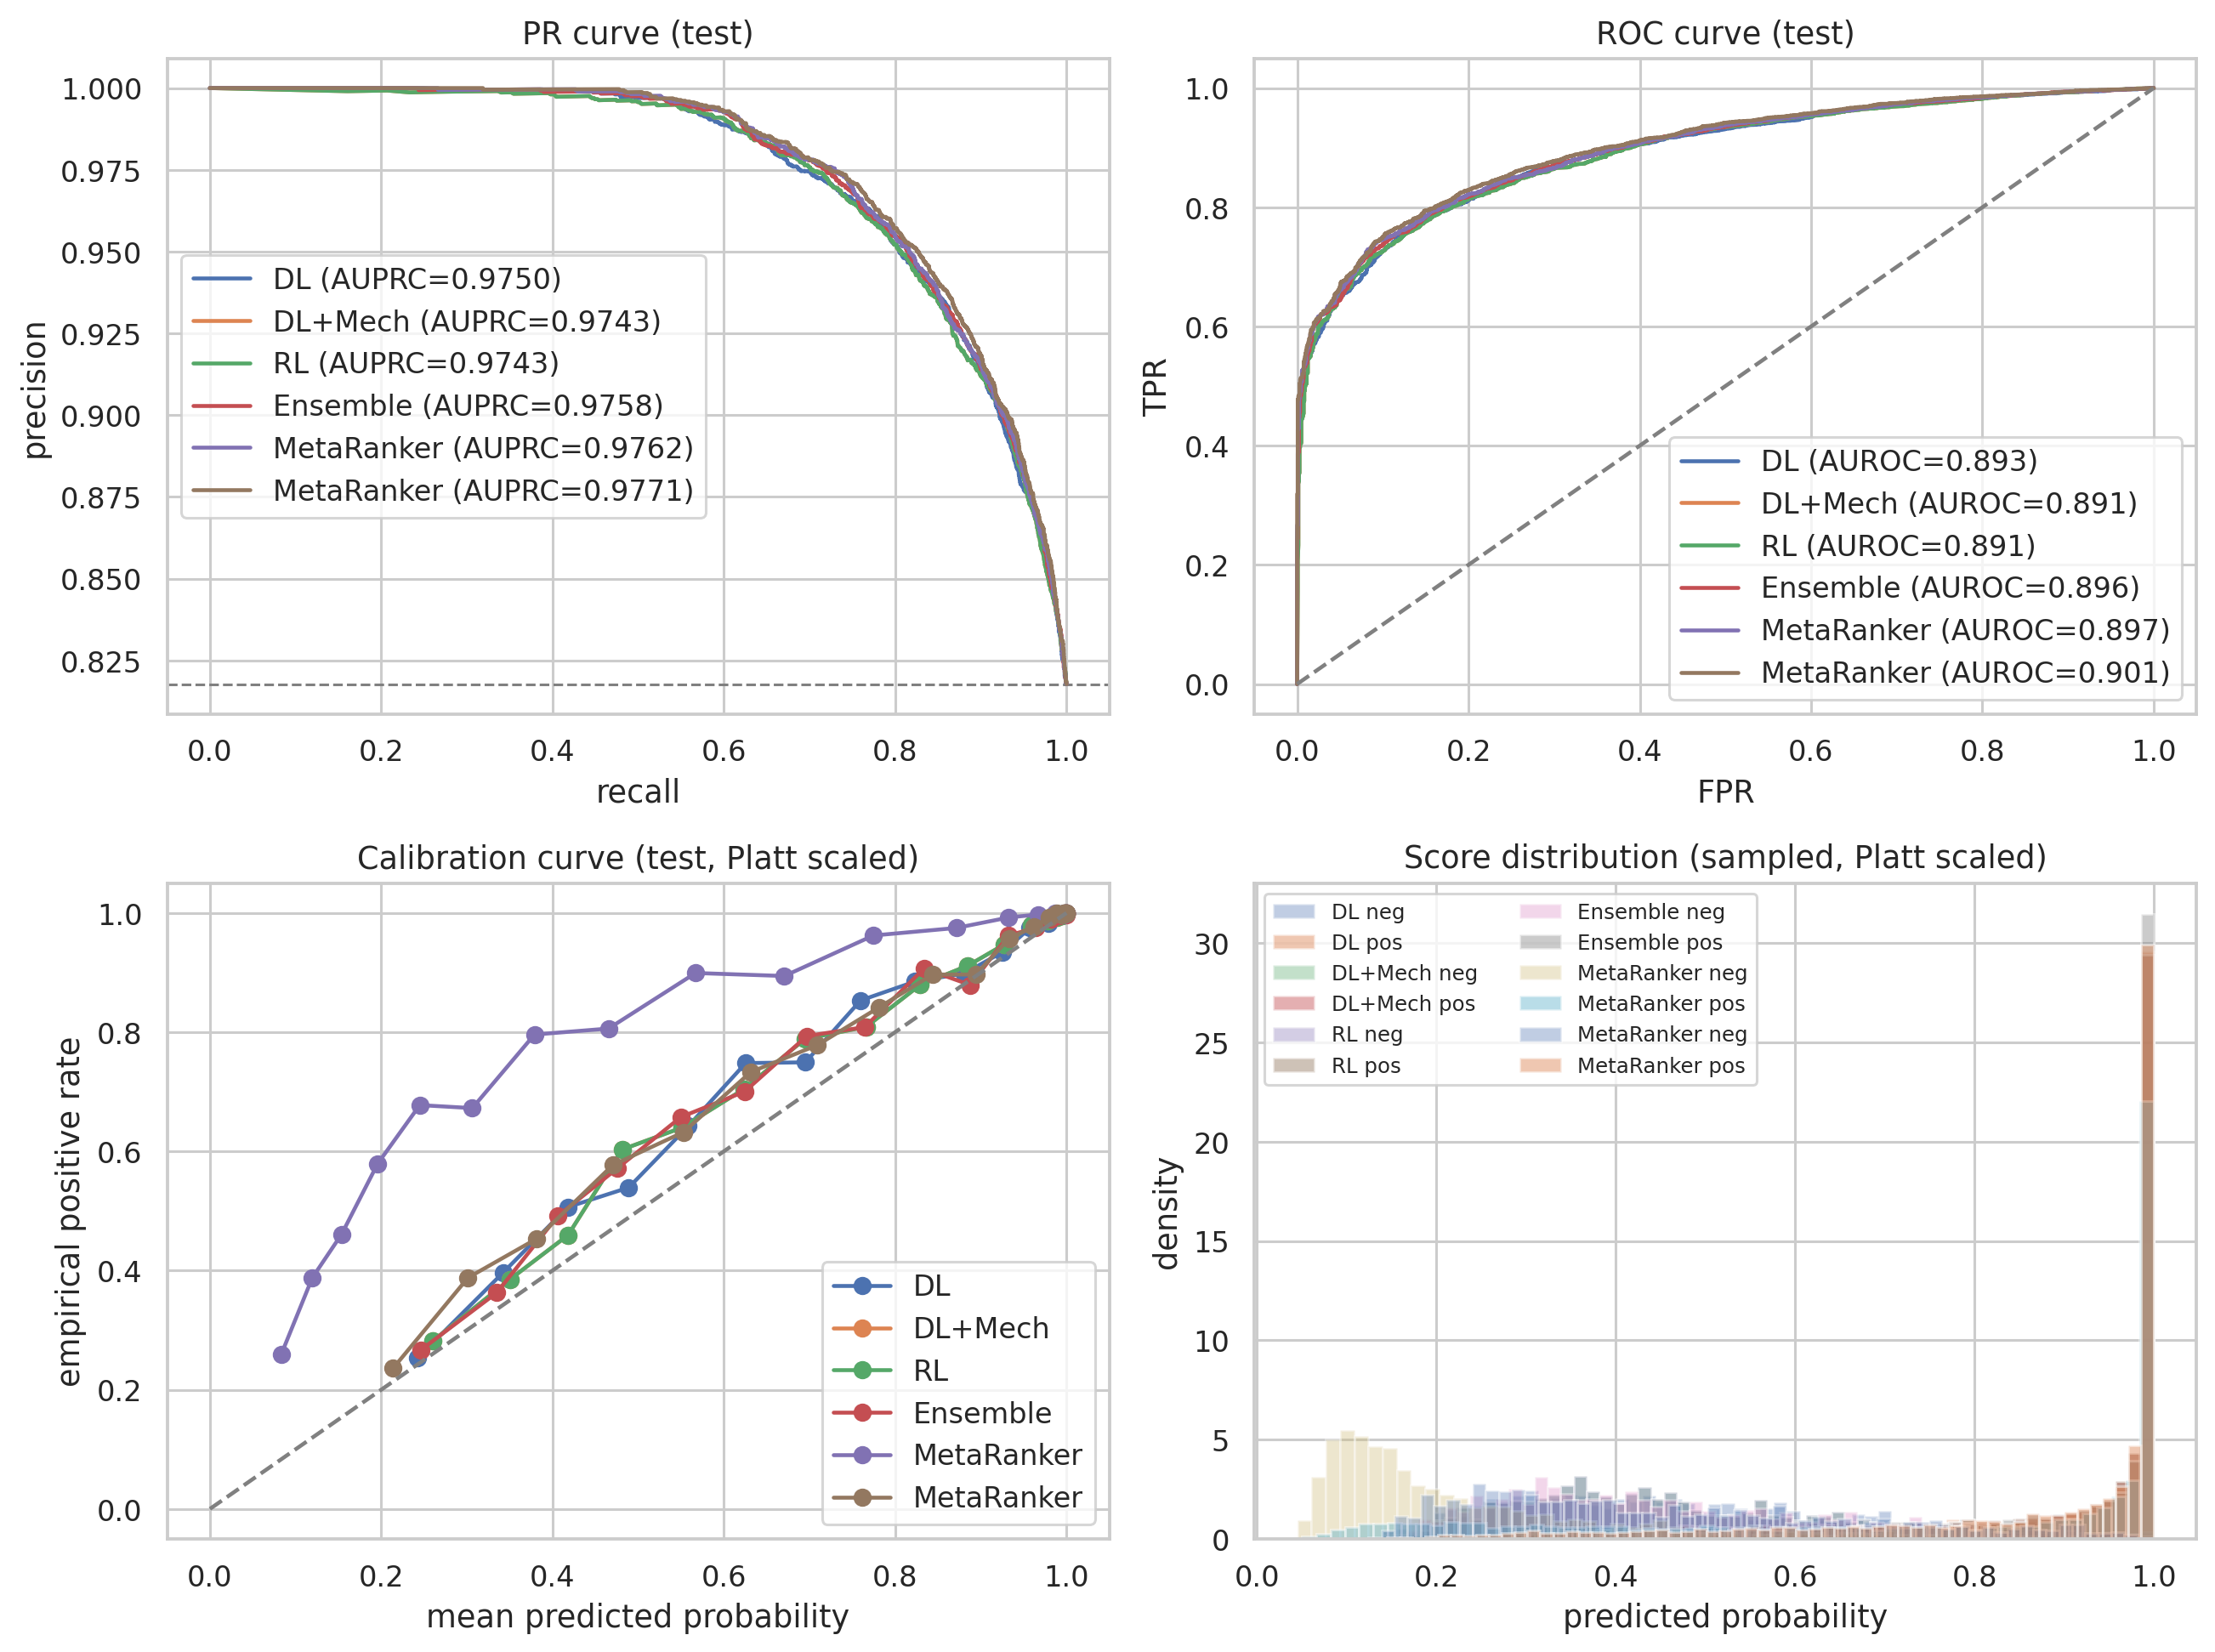

`fig23_openfda_precision_at_k.png`

... plus 8 more figures saved to `data/figures/mechsignal`

In [40]:
# --- E) Export figure pack (paper-ready)

from pathlib import Path

import pandas as pd
from IPython.display import Image, Markdown, display

FIG_DIR = Path("data/figures/mechsignal")
tox_sider_dir = SIDER_TOXCAST_OUT_DIFFUSED if TOXCAST_INCLUDE_DIFFUSED else SIDER_TOXCAST_OUT
openfda_tox_dir = OPENFDA_DL_TOXCAST_OUT_DIFFUSED if TOXCAST_INCLUDE_DIFFUSED else OPENFDA_DL_TOXCAST_OUT

# choose RL output dir (only used if present)
rl_dir = OPENFDA_RL_OUT_TOXCAST if str(OPENFDA_RL_BASE_MODEL).strip().lower() == "toxcast" else OPENFDA_RL_OUT_PLAIN

cmd = [
    PY,
    "scripts/export_mechsignal_figures.py",
    "--out-dir",
    str(FIG_DIR),
    "--formats",
    "png,pdf",
    "--stack-max-points",
    "200000",
    "--platt-max-points",
    "200000",
    "--sider-baseline-dir",
    str(SIDER_BASELINE_OUT),
    "--sider-toxcast-dir",
    str(tox_sider_dir),
    "--openfda-dl-dir",
    str(OPENFDA_DL_OUT),
    "--openfda-toxcast-dir",
    str(openfda_tox_dir),
    "--openfda-rl-dir",
    str(rl_dir),
    "--openfda-rolling-path",
    "data/outputs/openfda_rolling_metrics.tsv",
]
run(cmd)

index_path = FIG_DIR / "figure_index.tsv"
if index_path.exists():
    display(Markdown(f"Figure index: `{index_path}`"))
    display(pd.read_csv(index_path, sep="\t"))
else:
    print("No figure_index.tsv found:", index_path)

# Quick gallery (first 12 figures; the full set is saved on disk)
pngs = sorted(FIG_DIR.glob("*.png"))
display(Markdown(f"Generated `{len(pngs)}` PNG figures under `{FIG_DIR}`"))
for p in pngs[:12]:
    display(Markdown(f"`{p.name}`"))
    display(Image(filename=str(p), width=900))
if len(pngs) > 12:
    display(Markdown(f"... plus {len(pngs) - 12} more figures saved to `{FIG_DIR}`"))
